<h3 style="text-align:center">Time series analysis using RNN, LSTM, and Attention Mechanism</h3>

<p>First, I import libraries and load the input data. I begin by analysing Beijing Air Pollution data set.</p>

In [37]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import keras
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, LSTM, Dropout
from attention import Attention

np.random.seed(100)

In [38]:
# Input Data
input_data = pd.read_csv("input/idx-composite.csv")

<p>The data set contains observations from 01-01-2010 to 12-31-2014. Below I print several rows from the data set. I am interested in predicting value in <b>pm2.5</b> column. Next, I remove all rows with missing values.</p>

In [39]:
clean_data = input_data[input_data['close'].notnull()]
clean_data = clean_data.assign(date_time = pd.to_datetime(clean_data[['year', 'month', 'day', 'hour']]))
clean_data.set_index('date_time', inplace = True)

<p>Below, I plot the observed value of air pollution for 2014. The measurements were done each hour, so to avoid messy visualizations I plot the mean value of <b>pm2.5</b> for 3 days. We can observe that the air pollution increases during the winter months.</p>

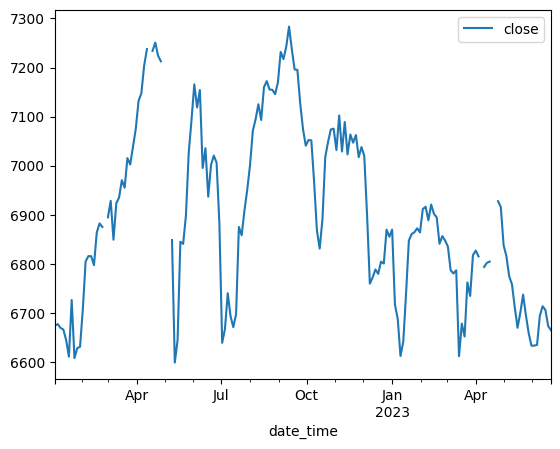

In [40]:
clean_data.loc['2022':'2023'].resample('3D').mean().plot(y = 'close')
plt.show()

<p>Next, I split the data up into train and test sets. I use observations for 2014 as a test data. The target variable <i>y</i> is a column <b>pm2.5</b>. To predict its value, each model will use the past value of <b>pm2.5</b>. Those past values are stored in valiable <i>x</i>. Constant <i>lookback</i> defines how many past observations are available for the model to make a prediction. It is defined in the number of days, and each day consists of 24 observations.</p>

In [41]:
def train_test_split(lookback, clean_data):
    """Splin the input data on train and test subsets.
    """
    y_train = clean_data['1990':'2020']['close']
    y_test = clean_data.loc['2021':'2023']['close']

    column_names = ['lag_1']
    x_train = y_train.shift()
    x_test = y_test.shift()
    for i in range(2, 24 * lookback + 1):
        x_train = pd.concat([x_train, y_train.shift(i)], axis = 1)
        x_test = pd.concat([x_test, y_test.shift(i)], axis = 1)
        column_names.append('lag_' + str(i))
    x_train = x_train[24 * lookback:]
    x_test = x_test[24 * lookback:]
    y_train = y_train[24 * lookback:]
    y_test = y_test[24 * lookback:]
    x_train.columns = column_names
    x_test.columns = column_names
    return [x_train, y_train, x_test, y_test]
    
def scale_train_test(x_train, x_test):
    """Normalize train and test subsets
    """
    scaler = StandardScaler()
    scaler.fit(x_train)
    x_train = scaler.transform(x_train)
    x_test = scaler.transform(x_test)
    return [x_train, x_test]

In [42]:
x_train, y_train, x_test, y_test = train_test_split(1, clean_data)

<p>Next, I define functions to compute Mean Square Error and Mean Absolute Error according to a baseline approach. Additionally, I plot the baseline predictions. I plot forecasts for several days in 2012 and 2014. The predicted values are plotted in orange and the true observations are plotted in blue.</p>

In [43]:
def base_line_mae(x, y):
    """Return mae for naive method to predict the outcome.
    Use value from the previouse day.
    """
    prediction = x['lag_1']
    return(np.mean(np.absolute(prediction - y)))

def base_line_mse(x, y):
    """Return mse for naive method to predict the outcome.
    Use value from the previouse day.
    """
    prediction = x['lag_1']
    return(np.mean(np.square(prediction - y)))

def plot_forecast(model, x_train, y_train, x_test, y_test):
    """Plot the model's forecast on the train and test datasets
    """
    if model == 'base':
        train_predict = pd.DataFrame(x_train['lag_1'])
        test_predict = pd.DataFrame(x_test['lag_1'])
    else:
        train_predict = pd.DataFrame(model.predict(x_train))
        test_predict = pd.DataFrame(model.predict(x_test))

    train_predict.columns = ['prediction']
    train_predict['date_time'] = y_train.index.values
    train_predict.set_index('date_time', inplace = True)
    train_plot = pd.concat([y_train, train_predict], axis = 1)

    test_predict.columns = ['prediction']
    test_predict['date_time'] = y_test.index.values
    test_predict.set_index('date_time', inplace = True)
    test_plot = pd.concat([y_test, test_predict], axis = 1)

    fig, axs = plt.subplots(2, 2, figsize = (15, 10))
    
    train_plot.loc['2019'].plot(ax = axs[0, 0])
    test_plot.loc['2022'].plot(ax = axs[0, 1])
    train_plot.loc['2020'].plot(ax = axs[1, 0])
    test_plot.loc['2023'].plot(ax = axs[1, 1])
    
    axs[0, 0].title.set_text('Train dataset')
    axs[0, 1].title.set_text('Test dataset')
    plt.show()

base_mae = base_line_mae(x_train, y_train)
base_mse = base_line_mse(x_train, y_train)
print("Mean absolute error of a naive predictor", base_mae)
print("Mean squared error of a naive predictor", base_mse)

plot_forecast('base', x_train, y_train, x_test, y_test)

<h3 style="text-align:center">Fully Connected ANN</h3>

<p>In this section, I build Fully Connected ANNs. First, I compare two loss functions: Mean Absolute Error and Mean Square Error. I begin by training the networks on time series consisting of one-day observations. So, as an input, the networks receive 24 air pollution measurements.</p>

In [44]:
def plot_loss(history):
    """Plot the learning curve
    """
    plt.plot(range(1, len(history.history['loss']) + 1), history.history['loss'])
    plt.plot(range(1, len(history.history['val_loss']) + 1), history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['train', 'val'], loc = 'best')
    plt.show()

In [45]:
# Scale the input data
x_train, x_test = scale_train_test(x_train, x_test)

# Observations for 1 day only
lookback = 1 

# Build the model
ann_1 = Sequential()
ann_1.add(Dense(32, activation = 'relu', input_dim = 24 * lookback))
ann_1.add(Dense(16, activation = 'relu'))
ann_1.add(Dense(1))
ann_1.summary()

C:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_7 (Dense)                      │ (None, 32)                  │             800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,345 (5.25 KB)

 Trainable params: 1,345 (5.25 KB)

 Non-trainable params: 0 (0.00 B)

In [46]:
ann_1.compile(optimizer = 'rmsprop', loss = 'mean_absolute_error')
history_ann_1 = ann_1.fit(x_train, y_train, epochs = 100, batch_size = 256, verbose = 1, validation_split = 0.1)

Epoch 1/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 1849.6243 - val_loss: 5860.3403
Epoch 2/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1866.3346 - val_loss: 5851.3184
Epoch 3/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1874.1222 - val_loss: 5838.5454
Epoch 4/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1894.3976 - val_loss: 5821.2866
Epoch 5/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1869.6664 - val_loss: 5798.6460
Epoch 6/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1836.7952 - val_loss: 5770.0664
Epoch 7/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1821.9370 - val_loss: 5734.7974
Epoch 8/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1855.2610 - val_loss: 5692.4653
Epoch 9/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1760.5386 - val_loss: 5642.0493
Epoch 10/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1781.4904 - val_loss: 5583.0781
Epoch 11/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1753.7057 - val_loss: 5516.

27/27 [==============================] - 0s 7ms/step - loss: 24.4349 - val_loss: 70.4929
Epoch 135/500
27/27 [==============================] - 0s 7ms/step - loss: 24.5709 - val_loss: 77.8673
Epoch 136/500
27/27 [==============================] - 0s 8ms/step - loss: 24.4491 - val_loss: 64.8271
Epoch 137/500
27/27 [==============================] - 0s 6ms/step - loss: 24.5572 - val_loss: 65.2250
Epoch 138/500
27/27 [==============================] - 0s 7ms/step - loss: 24.8033 - val_loss: 64.3031
Epoch 139/500
27/27 [==============================] - 0s 6ms/step - loss: 24.5433 - val_loss: 70.1399
Epoch 140/500
27/27 [==============================] - 0s 6ms/step - loss: 24.5988 - val_loss: 64.4402
Epoch 141/500
27/27 [==============================] - 0s 6ms/step - loss: 24.5879 - val_loss: 68.8060
Epoch 142/500
27/27 [==============================] - 0s 6ms/step - loss: 24.4696 - val_loss: 68.4567
Epoch 143/500
27/27 [==============================] - 0s 6ms/step - loss: 24.4818 - va

27/27 [==============================] - 0s 7ms/step - loss: 23.8019 - val_loss: 63.6364
Epoch 293/500
27/27 [==============================] - 0s 8ms/step - loss: 23.6481 - val_loss: 63.9860
Epoch 294/500
27/27 [==============================] - 0s 7ms/step - loss: 23.7010 - val_loss: 69.9875
Epoch 295/500
27/27 [==============================] - 0s 6ms/step - loss: 24.1187 - val_loss: 70.4322
Epoch 296/500
27/27 [==============================] - 0s 6ms/step - loss: 23.6042 - val_loss: 61.4821
Epoch 297/500
27/27 [==============================] - 0s 7ms/step - loss: 23.7965 - val_loss: 67.0525
Epoch 298/500
27/27 [==============================] - 0s 7ms/step - loss: 23.6291 - val_loss: 61.7018
Epoch 299/500
27/27 [==============================] - 0s 8ms/step - loss: 24.0220 - val_loss: 61.0933
Epoch 300/500
27/27 [==============================] - 0s 7ms/step - loss: 23.8764 - val_loss: 62.1898
Epoch 301/500
27/27 [==============================] - 0s 7ms/step - loss: 23.5783 - va

27/27 [==============================] - 0s 7ms/step - loss: 22.7668 - val_loss: 60.0067
Epoch 451/500
27/27 [==============================] - 0s 7ms/step - loss: 23.3007 - val_loss: 61.3719
Epoch 452/500
27/27 [==============================] - 0s 7ms/step - loss: 23.1288 - val_loss: 59.3094
Epoch 453/500
27/27 [==============================] - 0s 6ms/step - loss: 23.0213 - val_loss: 60.7234
Epoch 454/500
27/27 [==============================] - 0s 7ms/step - loss: 22.8940 - val_loss: 59.6698
Epoch 455/500
27/27 [==============================] - 0s 11ms/step - loss: 23.1064 - val_loss: 59.2629
Epoch 456/500
27/27 [==============================] - 0s 7ms/step - loss: 23.4733 - val_loss: 59.5949
Epoch 457/500
27/27 [==============================] - 0s 7ms/step - loss: 23.0935 - val_loss: 61.0306
Epoch 458/500
27/27 [==============================] - 0s 7ms/step - loss: 23.2500 - val_loss: 61.6879
Epoch 459/500
27/27 [==============================] - 0s 7ms/step - loss: 23.0086 - v

27/27 [==============================] - 0s 7ms/step - loss: 22.6724 - val_loss: 64.2101
Epoch 31/500
27/27 [==============================] - 0s 7ms/step - loss: 22.9007 - val_loss: 59.7846
Epoch 32/500
27/27 [==============================] - 0s 7ms/step - loss: 23.1274 - val_loss: 58.1039
Epoch 33/500
27/27 [==============================] - 0s 8ms/step - loss: 22.7838 - val_loss: 63.0204
Epoch 34/500
27/27 [==============================] - 0s 6ms/step - loss: 22.8784 - val_loss: 57.8712
Epoch 35/500
27/27 [==============================] - 0s 6ms/step - loss: 22.9905 - val_loss: 60.5118
Epoch 36/500
27/27 [==============================] - 0s 6ms/step - loss: 22.9189 - val_loss: 58.3138
Epoch 37/500
27/27 [==============================] - 0s 6ms/step - loss: 22.9116 - val_loss: 60.5327
Epoch 38/500
27/27 [==============================] - 0s 6ms/step - loss: 22.9543 - val_loss: 57.9933
Epoch 39/500
27/27 [==============================] - 0s 7ms/step - loss: 22.6356 - val_loss: 6

27/27 [==============================] - 0s 7ms/step - loss: 22.5969 - val_loss: 62.9226
Epoch 190/500
27/27 [==============================] - 0s 6ms/step - loss: 22.7114 - val_loss: 57.3223
Epoch 191/500
27/27 [==============================] - 0s 7ms/step - loss: 22.6292 - val_loss: 64.0618
Epoch 192/500
27/27 [==============================] - 0s 7ms/step - loss: 22.2710 - val_loss: 58.5637
Epoch 193/500
27/27 [==============================] - 0s 7ms/step - loss: 22.6149 - val_loss: 61.3985
Epoch 194/500
27/27 [==============================] - 0s 7ms/step - loss: 22.5975 - val_loss: 60.4034
Epoch 195/500
27/27 [==============================] - 0s 7ms/step - loss: 22.3654 - val_loss: 57.6977
Epoch 196/500
27/27 [==============================] - 0s 7ms/step - loss: 22.4637 - val_loss: 60.1677
Epoch 197/500
27/27 [==============================] - 0s 7ms/step - loss: 22.1165 - val_loss: 64.7271
Epoch 198/500
27/27 [==============================] - 0s 7ms/step - loss: 22.4646 - va

27/27 [==============================] - 0s 7ms/step - loss: 22.2426 - val_loss: 56.0077
Epoch 348/500
27/27 [==============================] - 0s 7ms/step - loss: 22.0751 - val_loss: 55.6681
Epoch 349/500
27/27 [==============================] - 0s 7ms/step - loss: 22.2662 - val_loss: 59.5222
Epoch 350/500
27/27 [==============================] - 0s 7ms/step - loss: 21.9236 - val_loss: 56.8683
Epoch 351/500
27/27 [==============================] - 0s 7ms/step - loss: 22.1996 - val_loss: 55.9229
Epoch 352/500
27/27 [==============================] - 0s 7ms/step - loss: 22.2867 - val_loss: 63.3825
Epoch 353/500
27/27 [==============================] - 0s 7ms/step - loss: 22.0568 - val_loss: 63.4141
Epoch 354/500
27/27 [==============================] - 0s 7ms/step - loss: 22.1610 - val_loss: 64.0590
Epoch 355/500
27/27 [==============================] - 0s 7ms/step - loss: 22.1681 - val_loss: 57.8015
Epoch 356/500
27/27 [==============================] - 0s 8ms/step - loss: 22.0589 - va

27/27 [==============================] - 0s 7ms/step - loss: 22.0616 - val_loss: 55.5738
Epoch 6/500
27/27 [==============================] - 0s 7ms/step - loss: 21.8246 - val_loss: 54.6885
Epoch 7/500
27/27 [==============================] - 0s 7ms/step - loss: 21.7609 - val_loss: 61.5302
Epoch 8/500
27/27 [==============================] - 0s 7ms/step - loss: 21.8163 - val_loss: 59.7275
Epoch 9/500
27/27 [==============================] - 0s 7ms/step - loss: 21.8019 - val_loss: 61.6048
Epoch 10/500
27/27 [==============================] - 0s 7ms/step - loss: 21.7103 - val_loss: 54.3117
Epoch 11/500
27/27 [==============================] - 0s 7ms/step - loss: 22.0251 - val_loss: 58.7267
Epoch 12/500
27/27 [==============================] - 0s 7ms/step - loss: 21.6805 - val_loss: 55.5146
Epoch 13/500
27/27 [==============================] - 0s 7ms/step - loss: 22.0462 - val_loss: 57.9033
Epoch 14/500
27/27 [==============================] - 0s 7ms/step - loss: 21.8976 - val_loss: 59.97

Epoch 165/500
27/27 [==============================] - 0s 7ms/step - loss: 21.8015 - val_loss: 54.2394
Epoch 166/500
27/27 [==============================] - 0s 7ms/step - loss: 21.4720 - val_loss: 53.8729
Epoch 167/500
27/27 [==============================] - 0s 7ms/step - loss: 21.5984 - val_loss: 57.8645
Epoch 168/500
27/27 [==============================] - 0s 7ms/step - loss: 21.5716 - val_loss: 55.1438
Epoch 169/500
27/27 [==============================] - 0s 7ms/step - loss: 21.5929 - val_loss: 65.3439
Epoch 170/500
27/27 [==============================] - 0s 7ms/step - loss: 21.6335 - val_loss: 56.3817
Epoch 171/500
27/27 [==============================] - 0s 7ms/step - loss: 21.5764 - val_loss: 63.4181
Epoch 172/500
27/27 [==============================] - 0s 7ms/step - loss: 21.6568 - val_loss: 54.2509
Epoch 173/500
27/27 [==============================] - 0s 7ms/step - loss: 21.7368 - val_loss: 60.2410
Epoch 174/500
27/27 [==============================] - 0s 7ms/step - loss

27/27 [==============================] - 0s 7ms/step - loss: 21.3400 - val_loss: 59.7896
Epoch 324/500
27/27 [==============================] - 0s 7ms/step - loss: 21.4130 - val_loss: 55.9038
Epoch 325/500
27/27 [==============================] - 0s 7ms/step - loss: 21.4074 - val_loss: 54.3985
Epoch 326/500
27/27 [==============================] - 0s 7ms/step - loss: 21.2444 - val_loss: 55.5877
Epoch 327/500
27/27 [==============================] - 0s 7ms/step - loss: 21.3732 - val_loss: 56.3228
Epoch 328/500
27/27 [==============================] - 0s 7ms/step - loss: 21.4004 - val_loss: 56.5011
Epoch 329/500
27/27 [==============================] - 0s 7ms/step - loss: 21.4841 - val_loss: 61.9552
Epoch 330/500
27/27 [==============================] - 0s 7ms/step - loss: 21.2898 - val_loss: 53.0022
Epoch 331/500
27/27 [==============================] - 0s 7ms/step - loss: 21.5214 - val_loss: 53.5149
Epoch 332/500
27/27 [==============================] - 0s 7ms/step - loss: 21.4807 - va

27/27 [==============================] - 0s 7ms/step - loss: 21.1233 - val_loss: 63.5537
Epoch 482/500
27/27 [==============================] - 0s 7ms/step - loss: 21.2114 - val_loss: 52.8329
Epoch 483/500
27/27 [==============================] - 0s 7ms/step - loss: 21.3022 - val_loss: 52.9232
Epoch 484/500
27/27 [==============================] - 0s 7ms/step - loss: 21.1724 - val_loss: 59.6346
Epoch 485/500
27/27 [==============================] - 0s 7ms/step - loss: 21.0816 - val_loss: 52.7111
Epoch 486/500
27/27 [==============================] - 0s 7ms/step - loss: 21.1962 - val_loss: 56.3870
Epoch 487/500
27/27 [==============================] - 0s 7ms/step - loss: 21.2514 - val_loss: 57.4885
Epoch 488/500
27/27 [==============================] - 0s 7ms/step - loss: 21.1927 - val_loss: 52.9281
Epoch 489/500
27/27 [==============================] - 0s 7ms/step - loss: 21.1442 - val_loss: 60.4727
Epoch 490/500
27/27 [==============================] - 0s 7ms/step - loss: 21.1587 - va

27/27 [==============================] - 0s 7ms/step - loss: 21.1136 - val_loss: 51.9966
Epoch 142/500
27/27 [==============================] - 0s 7ms/step - loss: 21.0279 - val_loss: 62.7181
Epoch 143/500
27/27 [==============================] - 0s 7ms/step - loss: 21.1530 - val_loss: 53.5304
Epoch 144/500
27/27 [==============================] - 0s 7ms/step - loss: 20.8151 - val_loss: 51.9491
Epoch 145/500
27/27 [==============================] - 0s 7ms/step - loss: 21.2777 - val_loss: 52.2645
Epoch 146/500
27/27 [==============================] - 0s 7ms/step - loss: 20.9855 - val_loss: 53.7165
Epoch 147/500
27/27 [==============================] - 0s 7ms/step - loss: 21.4719 - val_loss: 64.8983
Epoch 148/500
27/27 [==============================] - 0s 7ms/step - loss: 20.8581 - val_loss: 56.5119
Epoch 149/500
27/27 [==============================] - 0s 6ms/step - loss: 21.1212 - val_loss: 51.9791
Epoch 150/500
27/27 [==============================] - 0s 7ms/step - loss: 21.1821 - va

27/27 [==============================] - 0s 7ms/step - loss: 21.0172 - val_loss: 65.6312
Epoch 300/500
27/27 [==============================] - 0s 7ms/step - loss: 21.0910 - val_loss: 51.5797
Epoch 301/500
27/27 [==============================] - 0s 7ms/step - loss: 20.8320 - val_loss: 63.1328
Epoch 302/500
27/27 [==============================] - 0s 7ms/step - loss: 20.9001 - val_loss: 54.3125
Epoch 303/500
27/27 [==============================] - 0s 8ms/step - loss: 20.9415 - val_loss: 53.3834
Epoch 304/500
27/27 [==============================] - 0s 6ms/step - loss: 21.2031 - val_loss: 56.6922
Epoch 305/500
27/27 [==============================] - 0s 6ms/step - loss: 20.7281 - val_loss: 54.1678
Epoch 306/500
27/27 [==============================] - 0s 6ms/step - loss: 20.9466 - val_loss: 53.5595
Epoch 307/500
27/27 [==============================] - 0s 6ms/step - loss: 20.7284 - val_loss: 51.6448
Epoch 308/500
27/27 [==============================] - 0s 7ms/step - loss: 21.0583 - va

27/27 [==============================] - 0s 7ms/step - loss: 20.6253 - val_loss: 54.7997
Epoch 458/500
27/27 [==============================] - 0s 7ms/step - loss: 20.9126 - val_loss: 53.8174
Epoch 459/500
27/27 [==============================] - 0s 7ms/step - loss: 20.6514 - val_loss: 54.4412
Epoch 460/500
27/27 [==============================] - 0s 12ms/step - loss: 20.9572 - val_loss: 51.2168
Epoch 461/500
27/27 [==============================] - 0s 7ms/step - loss: 20.8907 - val_loss: 52.1090
Epoch 462/500
27/27 [==============================] - 0s 7ms/step - loss: 20.9171 - val_loss: 52.0574
Epoch 463/500
27/27 [==============================] - 0s 7ms/step - loss: 20.8017 - val_loss: 56.4406
Epoch 464/500
27/27 [==============================] - 0s 7ms/step - loss: 20.9581 - val_loss: 54.4593
Epoch 465/500
27/27 [==============================] - 0s 8ms/step - loss: 20.7551 - val_loss: 58.0056
Epoch 466/500
27/27 [==============================] - 0s 7ms/step - loss: 20.7393 - v

<p>The above output shows that the loss gradually decreases both on the training set and validation set. However, the loss function quickly reaches a plateau and never decreases after 20 epochs of training. So, at this point, I assume that this ANN reached its best accuracy. The lowest value of the loss function on the validation set is 12.2514 which is a bit lower than the baseline MAE = 13.2</p>

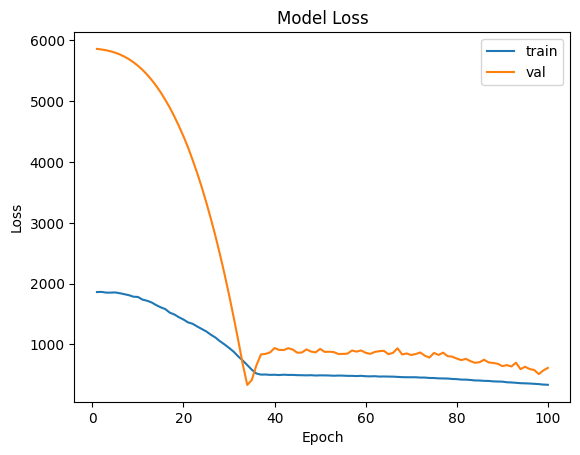

In [47]:
plot_loss(history_ann_1)

<p>Below I plot the values which the model forecasted. To make one prediction the model gets an input of 24 observations for one day.</p>

234/234 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


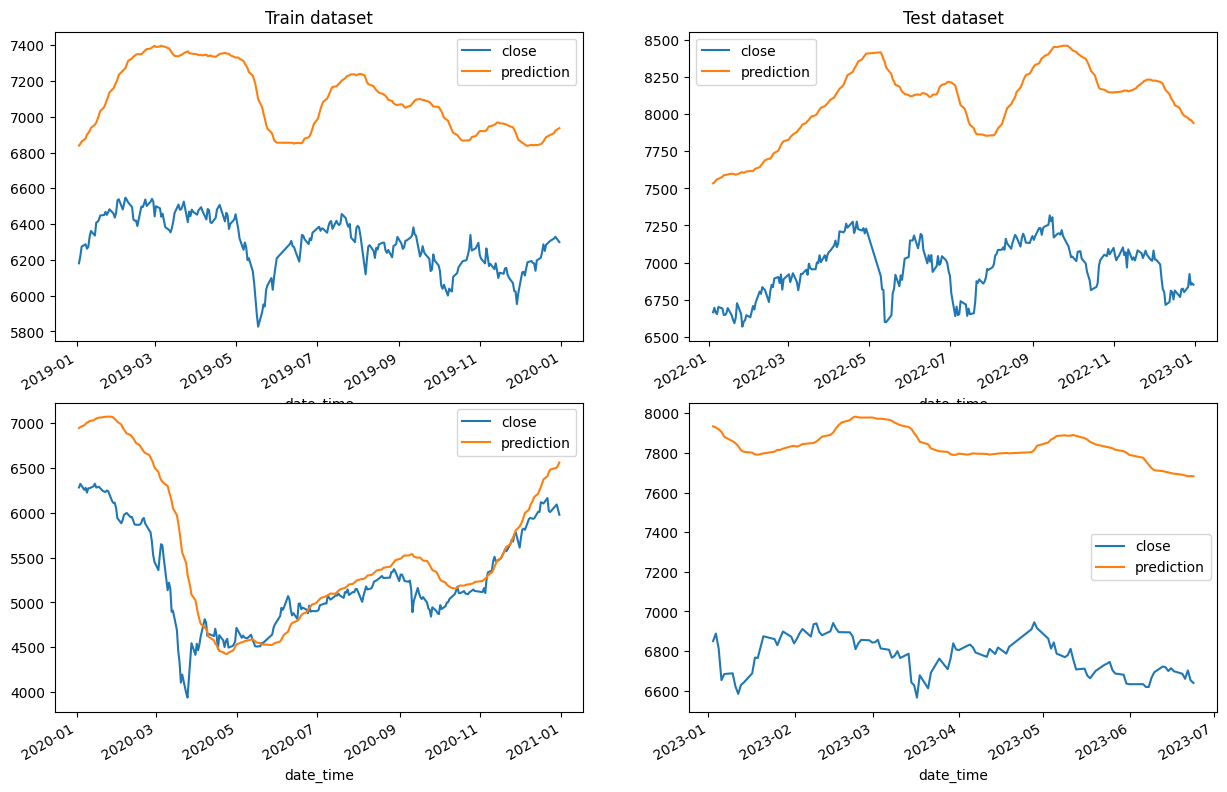

In [48]:
plot_forecast(ann_1, x_train, y_train, x_test, y_test)

<p>The above plotts are very similar to the baseline plots. So, fully connected ANN simply predicts a value of the previous observation.</p>

<p>Next, I check if the model improves if it minimizes MSE instead of MAE.</p>

In [49]:
ann_1.compile(optimizer = 'rmsprop', loss = 'mean_squared_error')
history_ann_1 = ann_1.fit(x_train, y_train, epochs = 100, batch_size = 256, verbose = 1, validation_split = 0.1)

Epoch 1/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 239131.6094 - val_loss: 461069.9062
Epoch 2/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 233345.7500 - val_loss: 502703.3750
Epoch 3/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 220669.5938 - val_loss: 367905.7188
Epoch 4/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 195929.3125 - val_loss: 512967.2188
Epoch 5/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 195694.3438 - val_loss: 379836.0938
Epoch 6/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 182449.6094 - val_loss: 345861.7188
Epoch 7/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 175548.7812 - val_loss: 377815.3438
Epoch 8/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 165036.2344 - val_loss: 313731.5938
Epoch 9/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 150929.1250 - val_loss: 262111.5000
Epoch 10/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 139960.7812 - val_loss: 260357.7500
Epoch 11/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/s

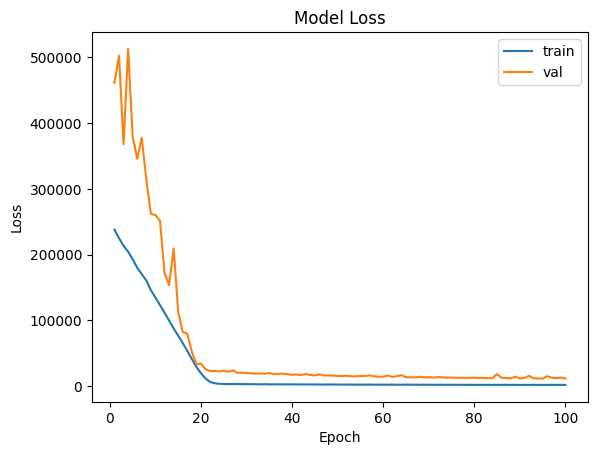

In [50]:
plot_loss(history_ann_1)

234/234 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


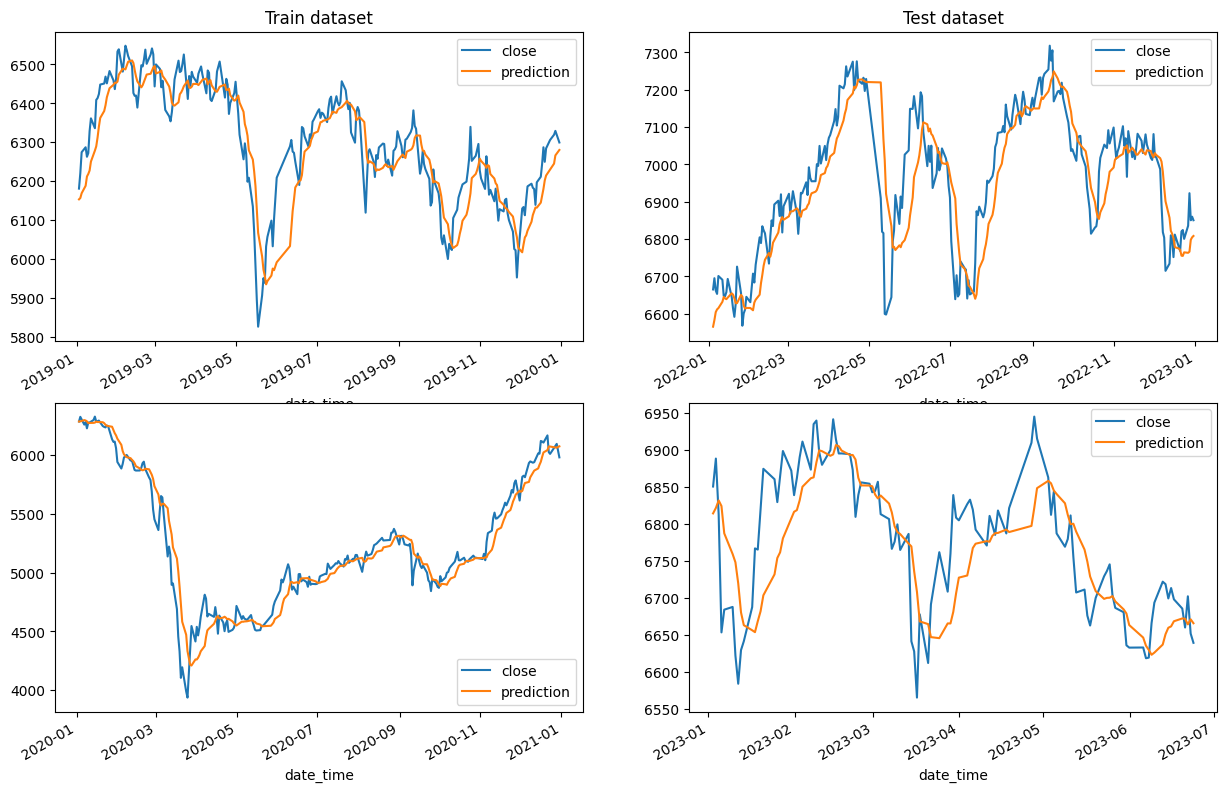

In [51]:
plot_forecast(ann_1, x_train, y_train, x_test, y_test)

<p>As in the previous case, MSE decreased significantly at the beginning of training and after that stayed almost the same. When I stopped training the loss was 572 which is better than the baseline. So, models trained with MSE and MAE performed almost the same. So, as there is not much difference, we pick MSE for our future models.</p>

<p>Next, I try different optimization algorithm.</p>

In [52]:
ann_1.compile(optimizer = 'adam', loss = 'mean_absolute_error')
history_ann_1 = ann_1.fit(x_train, y_train, epochs = 100, batch_size = 256, verbose = 1, validation_split = 0.1)

Epoch 1/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 25.9008 - val_loss: 73.0856
Epoch 2/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 24.9420 - val_loss: 72.9489
Epoch 3/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 23.9649 - val_loss: 72.6646
Epoch 4/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 24.8931 - val_loss: 72.9925
Epoch 5/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 24.6995 - val_loss: 72.4983
Epoch 6/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 24.8599 - val_loss: 72.3011
Epoch 7/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 24.6689 - val_loss: 72.4747
Epoch 8/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 24.2994 - val_loss: 72.0617
Epoch 9/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 24.8855 - val_loss: 72.7072
Epoch 10/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 25.1024 - val_loss: 71.9581
Epoch 11/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 25.1064 - val_loss: 71.9385
Epoch 12/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 

27/27 [==============================] - 0s 7ms/step - loss: 17.0977 - val_loss: 48.7206
Epoch 478/500
27/27 [==============================] - 0s 8ms/step - loss: 17.0993 - val_loss: 48.2386
Epoch 479/500
27/27 [==============================] - 0s 7ms/step - loss: 17.0762 - val_loss: 48.5053
Epoch 480/500
27/27 [==============================] - 0s 6ms/step - loss: 16.9479 - val_loss: 48.2201
Epoch 481/500
27/27 [==============================] - 0s 7ms/step - loss: 17.0371 - val_loss: 48.2439
Epoch 482/500
27/27 [==============================] - 0s 7ms/step - loss: 17.0394 - val_loss: 48.2709
Epoch 483/500
27/27 [==============================] - 0s 7ms/step - loss: 16.9247 - val_loss: 48.2093
Epoch 484/500
27/27 [==============================] - 0s 7ms/step - loss: 16.9832 - val_loss: 48.2345
Epoch 485/500
27/27 [==============================] - 0s 7ms/step - loss: 17.1149 - val_loss: 48.2570
Epoch 486/500
27/27 [==============================] - 0s 7ms/step - loss: 16.9540 - va

27/27 [==============================] - 0s 7ms/step - loss: 16.9097 - val_loss: 48.2296
Epoch 138/500
27/27 [==============================] - 0s 7ms/step - loss: 16.9509 - val_loss: 48.1994
Epoch 139/500
27/27 [==============================] - 0s 7ms/step - loss: 16.8642 - val_loss: 48.2672
Epoch 140/500
27/27 [==============================] - 0s 7ms/step - loss: 16.9058 - val_loss: 48.5749
Epoch 141/500
27/27 [==============================] - 0s 7ms/step - loss: 16.8416 - val_loss: 47.8564
Epoch 142/500
27/27 [==============================] - 0s 7ms/step - loss: 17.0005 - val_loss: 50.5917
Epoch 143/500
27/27 [==============================] - 0s 7ms/step - loss: 17.1236 - val_loss: 47.9432
Epoch 144/500
27/27 [==============================] - 0s 7ms/step - loss: 16.8285 - val_loss: 48.0578
Epoch 145/500
27/27 [==============================] - 0s 7ms/step - loss: 16.7406 - val_loss: 47.8838
Epoch 146/500
27/27 [==============================] - 0s 7ms/step - loss: 16.8590 - va

27/27 [==============================] - 0s 7ms/step - loss: 16.6640 - val_loss: 47.7364
Epoch 296/500
27/27 [==============================] - 0s 6ms/step - loss: 16.6738 - val_loss: 48.5786
Epoch 297/500
27/27 [==============================] - 0s 7ms/step - loss: 16.6083 - val_loss: 48.1575
Epoch 298/500
27/27 [==============================] - 0s 7ms/step - loss: 16.5665 - val_loss: 47.8147
Epoch 299/500
27/27 [==============================] - 0s 7ms/step - loss: 16.5570 - val_loss: 47.6179
Epoch 300/500
27/27 [==============================] - 0s 8ms/step - loss: 16.5865 - val_loss: 47.6806
Epoch 301/500
27/27 [==============================] - 0s 7ms/step - loss: 16.7238 - val_loss: 47.9458
Epoch 302/500
27/27 [==============================] - 0s 7ms/step - loss: 16.6500 - val_loss: 47.5860
Epoch 303/500
27/27 [==============================] - 0s 6ms/step - loss: 16.5941 - val_loss: 47.8230
Epoch 304/500
27/27 [==============================] - 0s 9ms/step - loss: 16.5972 - va

27/27 [==============================] - 0s 7ms/step - loss: 16.6353 - val_loss: 47.5803
Epoch 454/500
27/27 [==============================] - 0s 10ms/step - loss: 16.4822 - val_loss: 47.4024
Epoch 455/500
27/27 [==============================] - 0s 7ms/step - loss: 16.4666 - val_loss: 47.5400
Epoch 456/500
27/27 [==============================] - 0s 8ms/step - loss: 16.5133 - val_loss: 47.8825
Epoch 457/500
27/27 [==============================] - 0s 8ms/step - loss: 16.6712 - val_loss: 47.4447
Epoch 458/500
27/27 [==============================] - 0s 7ms/step - loss: 16.4101 - val_loss: 47.7652
Epoch 459/500
27/27 [==============================] - 0s 9ms/step - loss: 16.4340 - val_loss: 47.4101
Epoch 460/500
27/27 [==============================] - 0s 6ms/step - loss: 16.6691 - val_loss: 47.3881
Epoch 461/500
27/27 [==============================] - 0s 12ms/step - loss: 16.5290 - val_loss: 47.4620
Epoch 462/500
27/27 [==============================] - 0s 6ms/step - loss: 16.4339 - 

Epoch 33/500
27/27 [==============================] - 0s 14ms/step - loss: 16.4629 - val_loss: 47.3808
Epoch 34/500
27/27 [==============================] - 0s 9ms/step - loss: 16.4373 - val_loss: 47.3197
Epoch 35/500
27/27 [==============================] - 0s 12ms/step - loss: 16.8070 - val_loss: 47.3338
Epoch 36/500
27/27 [==============================] - 0s 8ms/step - loss: 16.7153 - val_loss: 48.9194
Epoch 37/500
27/27 [==============================] - 0s 7ms/step - loss: 16.4424 - val_loss: 47.4007
Epoch 38/500
27/27 [==============================] - 0s 7ms/step - loss: 16.3889 - val_loss: 47.4369
Epoch 39/500
27/27 [==============================] - 0s 9ms/step - loss: 16.4098 - val_loss: 47.3405
Epoch 40/500
27/27 [==============================] - 0s 7ms/step - loss: 16.4690 - val_loss: 47.3186
Epoch 41/500
27/27 [==============================] - 0s 11ms/step - loss: 16.4812 - val_loss: 47.4159
Epoch 42/500
27/27 [==============================] - 0s 10ms/step - loss: 16.4

27/27 [==============================] - 0s 9ms/step - loss: 16.4160 - val_loss: 47.2536
Epoch 114/500
27/27 [==============================] - 0s 8ms/step - loss: 16.8284 - val_loss: 48.8790
Epoch 115/500
27/27 [==============================] - 0s 7ms/step - loss: 16.7204 - val_loss: 48.4387
Epoch 116/500
27/27 [==============================] - 0s 7ms/step - loss: 16.4043 - val_loss: 47.2330
Epoch 117/500
27/27 [==============================] - 0s 7ms/step - loss: 16.2943 - val_loss: 47.2691
Epoch 118/500
27/27 [==============================] - 0s 8ms/step - loss: 16.4620 - val_loss: 47.6021
Epoch 119/500
27/27 [==============================] - 0s 7ms/step - loss: 16.4153 - val_loss: 48.1219
Epoch 120/500
27/27 [==============================] - 0s 7ms/step - loss: 16.3202 - val_loss: 47.2758
Epoch 121/500
27/27 [==============================] - 0s 7ms/step - loss: 16.5213 - val_loss: 47.2668
Epoch 122/500
27/27 [==============================] - 0s 7ms/step - loss: 16.4772 - va

27/27 [==============================] - 0s 7ms/step - loss: 16.2546 - val_loss: 47.2212
Epoch 272/500
27/27 [==============================] - 0s 7ms/step - loss: 16.2978 - val_loss: 47.2653
Epoch 273/500
27/27 [==============================] - 0s 7ms/step - loss: 16.2515 - val_loss: 47.1002
Epoch 274/500
27/27 [==============================] - 0s 7ms/step - loss: 16.2905 - val_loss: 47.1072
Epoch 275/500
27/27 [==============================] - 0s 7ms/step - loss: 16.2567 - val_loss: 47.2254
Epoch 276/500
27/27 [==============================] - 0s 7ms/step - loss: 16.3098 - val_loss: 47.2552
Epoch 277/500
27/27 [==============================] - 0s 7ms/step - loss: 16.2692 - val_loss: 47.1268
Epoch 278/500
27/27 [==============================] - 0s 7ms/step - loss: 16.2591 - val_loss: 47.5913
Epoch 279/500
27/27 [==============================] - 0s 8ms/step - loss: 16.3219 - val_loss: 47.1277
Epoch 280/500
27/27 [==============================] - 0s 8ms/step - loss: 16.2748 - va

27/27 [==============================] - 0s 9ms/step - loss: 16.2823 - val_loss: 47.0642
Epoch 430/500
27/27 [==============================] - 0s 7ms/step - loss: 16.1279 - val_loss: 47.1129
Epoch 431/500
27/27 [==============================] - 0s 7ms/step - loss: 16.3482 - val_loss: 46.9939
Epoch 432/500
27/27 [==============================] - 0s 7ms/step - loss: 16.1425 - val_loss: 47.4907
Epoch 433/500
27/27 [==============================] - 0s 7ms/step - loss: 16.3588 - val_loss: 47.0026
Epoch 434/500
27/27 [==============================] - 0s 8ms/step - loss: 16.0722 - val_loss: 48.2029
Epoch 435/500
27/27 [==============================] - 0s 7ms/step - loss: 16.3013 - val_loss: 47.0096
Epoch 436/500
27/27 [==============================] - 0s 7ms/step - loss: 16.1884 - val_loss: 46.9886
Epoch 437/500
27/27 [==============================] - 0s 7ms/step - loss: 16.0966 - val_loss: 47.0027
Epoch 438/500
27/27 [==============================] - 0s 11ms/step - loss: 16.2859 - v

Epoch 9/500
27/27 [==============================] - 0s 8ms/step - loss: 16.0818 - val_loss: 47.5522
Epoch 10/500
27/27 [==============================] - 0s 8ms/step - loss: 16.3348 - val_loss: 47.0467
Epoch 11/500
27/27 [==============================] - 0s 7ms/step - loss: 16.1549 - val_loss: 47.0292
Epoch 12/500
27/27 [==============================] - 0s 7ms/step - loss: 16.3250 - val_loss: 46.9632
Epoch 13/500
27/27 [==============================] - 0s 7ms/step - loss: 16.2310 - val_loss: 46.9667
Epoch 14/500
27/27 [==============================] - 0s 7ms/step - loss: 16.2529 - val_loss: 47.2153
Epoch 15/500
27/27 [==============================] - 0s 8ms/step - loss: 16.2255 - val_loss: 47.0048
Epoch 16/500
27/27 [==============================] - 0s 7ms/step - loss: 16.1458 - val_loss: 47.2930
Epoch 17/500
27/27 [==============================] - 0s 7ms/step - loss: 16.1050 - val_loss: 46.9764
Epoch 18/500
27/27 [==============================] - 0s 7ms/step - loss: 16.1293 -

27/27 [==============================] - 0s 8ms/step - loss: 16.1524 - val_loss: 47.1440
Epoch 169/500
27/27 [==============================] - 0s 7ms/step - loss: 16.2072 - val_loss: 47.7971
Epoch 170/500
27/27 [==============================] - 0s 8ms/step - loss: 16.1518 - val_loss: 46.9921
Epoch 171/500
27/27 [==============================] - 0s 7ms/step - loss: 16.2217 - val_loss: 46.8763
Epoch 172/500
27/27 [==============================] - 0s 7ms/step - loss: 16.1166 - val_loss: 46.9173
Epoch 173/500
27/27 [==============================] - 0s 7ms/step - loss: 16.1141 - val_loss: 47.5188
Epoch 174/500
27/27 [==============================] - 0s 7ms/step - loss: 16.2482 - val_loss: 46.8540
Epoch 175/500
27/27 [==============================] - 0s 7ms/step - loss: 16.0804 - val_loss: 48.9870
Epoch 176/500
27/27 [==============================] - 0s 8ms/step - loss: 16.2755 - val_loss: 46.8604
Epoch 177/500
27/27 [==============================] - 0s 7ms/step - loss: 16.1971 - va

27/27 [==============================] - 0s 7ms/step - loss: 16.0685 - val_loss: 47.0769
Epoch 327/500
27/27 [==============================] - 0s 7ms/step - loss: 15.9940 - val_loss: 47.6071
Epoch 328/500
27/27 [==============================] - 0s 7ms/step - loss: 15.9313 - val_loss: 46.8247
Epoch 329/500
27/27 [==============================] - 0s 7ms/step - loss: 16.2823 - val_loss: 47.1705
Epoch 330/500
27/27 [==============================] - 0s 7ms/step - loss: 15.9925 - val_loss: 47.0572
Epoch 331/500
27/27 [==============================] - 0s 7ms/step - loss: 15.9861 - val_loss: 46.9198
Epoch 332/500
27/27 [==============================] - 0s 7ms/step - loss: 16.0309 - val_loss: 48.2918
Epoch 333/500
27/27 [==============================] - 0s 7ms/step - loss: 16.3944 - val_loss: 46.8101
Epoch 334/500
27/27 [==============================] - 0s 7ms/step - loss: 15.9133 - val_loss: 46.9898
Epoch 335/500
27/27 [==============================] - 0s 7ms/step - loss: 15.9620 - va

27/27 [==============================] - 0s 7ms/step - loss: 16.0165 - val_loss: 46.7449
Epoch 485/500
27/27 [==============================] - 0s 7ms/step - loss: 16.0347 - val_loss: 46.8478
Epoch 486/500
27/27 [==============================] - 0s 7ms/step - loss: 16.1918 - val_loss: 46.7488
Epoch 487/500
27/27 [==============================] - 0s 7ms/step - loss: 15.9417 - val_loss: 46.9798
Epoch 488/500
27/27 [==============================] - 0s 7ms/step - loss: 15.9488 - val_loss: 46.7407
Epoch 489/500
27/27 [==============================] - 0s 7ms/step - loss: 15.9056 - val_loss: 46.7498
Epoch 490/500
27/27 [==============================] - 0s 6ms/step - loss: 16.0012 - val_loss: 47.8787
Epoch 491/500
27/27 [==============================] - 0s 6ms/step - loss: 16.2293 - val_loss: 46.7739
Epoch 492/500
27/27 [==============================] - 0s 7ms/step - loss: 16.6095 - val_loss: 47.4445
Epoch 493/500
27/27 [==============================] - 0s 6ms/step - loss: 15.9843 - va

27/27 [==============================] - 0s 7ms/step - loss: 15.9186 - val_loss: 48.5272
Epoch 145/500
27/27 [==============================] - 0s 7ms/step - loss: 16.3058 - val_loss: 46.7139
Epoch 146/500
27/27 [==============================] - 0s 7ms/step - loss: 16.2622 - val_loss: 46.6896
Epoch 147/500
27/27 [==============================] - 0s 7ms/step - loss: 16.0185 - val_loss: 49.2328
Epoch 148/500
27/27 [==============================] - 0s 7ms/step - loss: 16.0892 - val_loss: 46.6801
Epoch 149/500
27/27 [==============================] - 0s 7ms/step - loss: 15.8241 - val_loss: 47.3609
Epoch 150/500
27/27 [==============================] - 0s 7ms/step - loss: 15.8244 - val_loss: 47.6676
Epoch 151/500
27/27 [==============================] - 0s 7ms/step - loss: 16.3867 - val_loss: 46.7094
Epoch 152/500
27/27 [==============================] - 0s 8ms/step - loss: 15.8495 - val_loss: 46.7563
Epoch 153/500
27/27 [==============================] - 0s 7ms/step - loss: 15.9183 - va

27/27 [==============================] - 0s 6ms/step - loss: 15.9235 - val_loss: 46.9650
Epoch 303/500
27/27 [==============================] - 0s 6ms/step - loss: 15.9488 - val_loss: 47.0430
Epoch 304/500
27/27 [==============================] - 0s 7ms/step - loss: 15.8196 - val_loss: 46.6346
Epoch 305/500
27/27 [==============================] - 0s 7ms/step - loss: 15.8437 - val_loss: 46.9542
Epoch 306/500
27/27 [==============================] - 0s 7ms/step - loss: 15.7814 - val_loss: 46.6255
Epoch 307/500
27/27 [==============================] - 0s 7ms/step - loss: 15.8472 - val_loss: 46.6628
Epoch 308/500
27/27 [==============================] - 0s 6ms/step - loss: 16.0799 - val_loss: 46.6790
Epoch 309/500
27/27 [==============================] - 0s 6ms/step - loss: 15.9953 - val_loss: 47.0462
Epoch 310/500
27/27 [==============================] - 0s 7ms/step - loss: 15.9312 - val_loss: 46.6982
Epoch 311/500
27/27 [==============================] - 0s 7ms/step - loss: 15.8381 - va

27/27 [==============================] - 0s 8ms/step - loss: 15.9198 - val_loss: 46.8698
Epoch 461/500
27/27 [==============================] - 0s 7ms/step - loss: 15.9915 - val_loss: 47.1424
Epoch 462/500
27/27 [==============================] - 0s 7ms/step - loss: 15.8382 - val_loss: 46.5599
Epoch 463/500
27/27 [==============================] - 0s 7ms/step - loss: 16.0048 - val_loss: 47.2345
Epoch 464/500
27/27 [==============================] - 0s 7ms/step - loss: 15.9109 - val_loss: 47.2755
Epoch 465/500
27/27 [==============================] - 0s 7ms/step - loss: 15.7873 - val_loss: 47.4644
Epoch 466/500
27/27 [==============================] - 0s 7ms/step - loss: 15.9016 - val_loss: 46.7076
Epoch 467/500
27/27 [==============================] - 0s 7ms/step - loss: 15.7627 - val_loss: 46.5875
Epoch 468/500
27/27 [==============================] - 0s 7ms/step - loss: 15.7661 - val_loss: 47.6520
Epoch 469/500
27/27 [==============================] - 0s 7ms/step - loss: 15.9667 - va

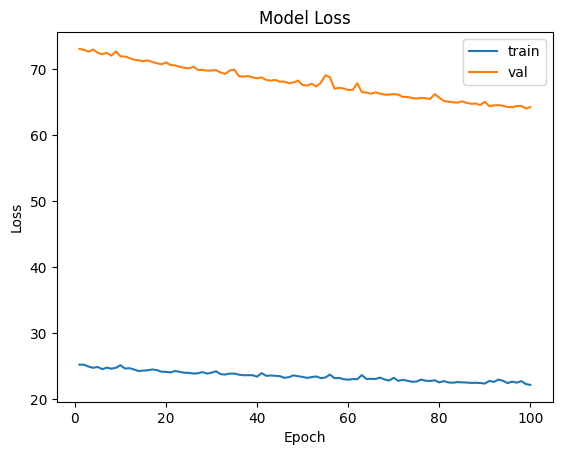

In [53]:
plot_loss(history_ann_1)

234/234 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


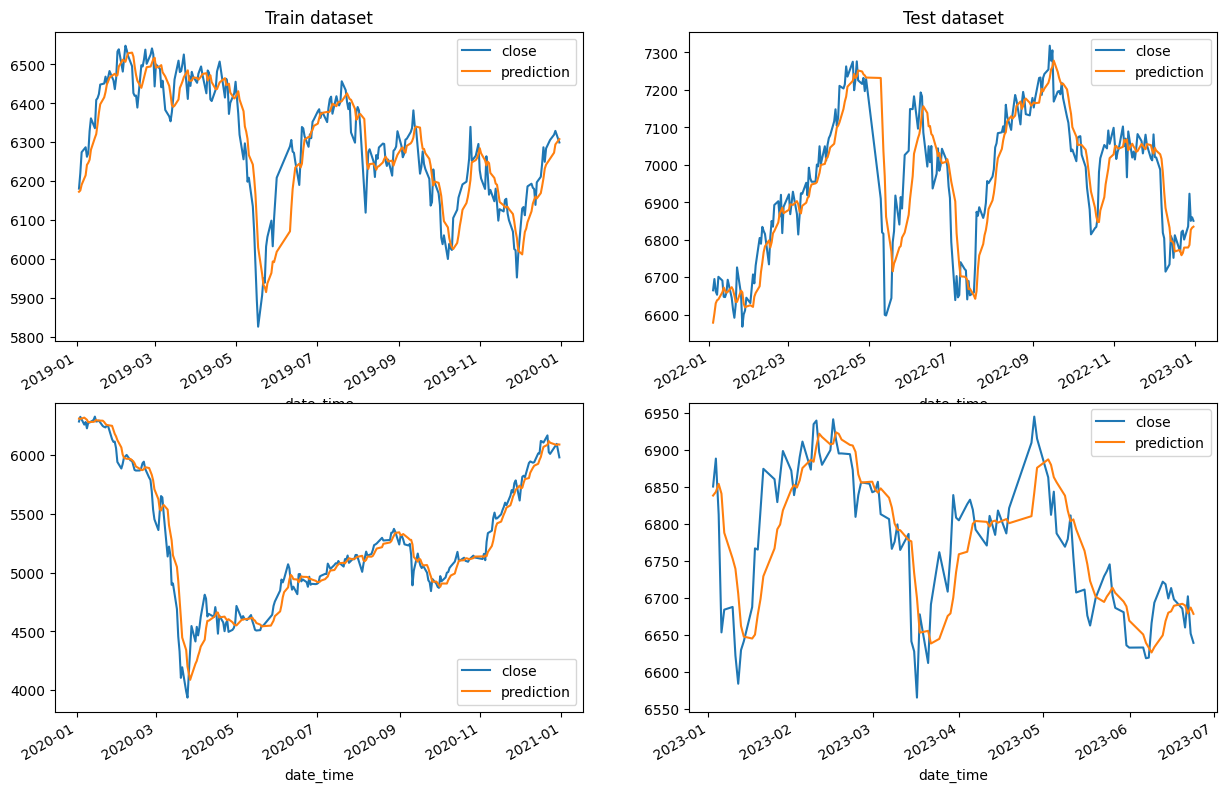

In [54]:
plot_forecast(ann_1, x_train, y_train, x_test, y_test)

In [55]:
train_score = ann_1.evaluate(x_train, y_train, verbose=0)
print('Train Score: %.2f MAE' % (train_score))
test_score = ann_1.evaluate(x_test, y_test, verbose=0)
print('Test Score: %.2f MAE' % (test_score))

Train Score: 26.56 MAE
Test Score: 51.78 MAE


<h3 style="text-align:center">RNN Models</h3>

<p>I begin by creating a simple RNN which gets as an input only one past observation.</p>

In [56]:
x_train = x_train[:, 0:1].reshape(x_train.shape[0], 1, 1)
x_test = x_test[:, 0:1].reshape(x_test.shape[0], 1, 1)

rnn_1 = Sequential()
rnn_1.add(SimpleRNN(9, input_shape = (1, 1)))
rnn_1.add(Dense(1))
rnn_1.summary()

C:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ simple_rnn_1 (SimpleRNN)             │ (None, 9)                   │              99 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 1)                   │              10 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 109 (436.00 B)

 Trainable params: 109 (436.00 B)

 Non-trainable params: 0 (0.00 B)

In [57]:
rnn_1.compile(loss = 'mean_absolute_error', optimizer = 'rmsprop')

history_rnn_1 = rnn_1.fit(x_train, y_train, epochs = 100, batch_size = 256, verbose = 1)

Epoch 1/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 2250.6113
Epoch 2/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2239.9558
Epoch 3/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2262.2188
Epoch 4/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2231.0090
Epoch 5/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2289.1528
Epoch 6/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2249.1282
Epoch 7/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2254.2905
Epoch 8/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2262.5107
Epoch 9/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2295.2578
Epoch 10/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2279.2971
Epoch 11/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2310.5166
Epoch 12/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2297.5813
Epoch 13/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2262.9324
Epoch 14/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2272.2434
Epoch 15/100
30/30 ━━━━━━━━━━

30/30 [==============================] - 0s 6ms/step - loss: 1774.1787
Epoch 383/4000
30/30 [==============================] - 0s 5ms/step - loss: 1773.9873
Epoch 384/4000
30/30 [==============================] - 0s 5ms/step - loss: 1773.7964
Epoch 385/4000
30/30 [==============================] - 0s 6ms/step - loss: 1773.6088
Epoch 386/4000
30/30 [==============================] - 0s 5ms/step - loss: 1773.4203
Epoch 387/4000
30/30 [==============================] - 0s 5ms/step - loss: 1773.2317
Epoch 388/4000
30/30 [==============================] - 0s 5ms/step - loss: 1773.0461
Epoch 389/4000
30/30 [==============================] - 0s 5ms/step - loss: 1772.8611
Epoch 390/4000
30/30 [==============================] - 0s 5ms/step - loss: 1772.6715
Epoch 391/4000
30/30 [==============================] - 0s 6ms/step - loss: 1772.4818
Epoch 392/4000
30/30 [==============================] - 0s 5ms/step - loss: 1772.2955
Epoch 393/4000
30/30 [==============================] - 0s 5ms/step -

30/30 [==============================] - 0s 6ms/step - loss: 1756.6656
Epoch 478/4000
30/30 [==============================] - 0s 5ms/step - loss: 1756.4895
Epoch 479/4000
30/30 [==============================] - 0s 5ms/step - loss: 1756.3055
Epoch 480/4000
30/30 [==============================] - 0s 6ms/step - loss: 1756.1238
Epoch 481/4000
30/30 [==============================] - 0s 5ms/step - loss: 1755.9403
Epoch 482/4000
30/30 [==============================] - 0s 5ms/step - loss: 1755.7550
Epoch 483/4000
30/30 [==============================] - 0s 5ms/step - loss: 1755.5739
Epoch 484/4000
30/30 [==============================] - 0s 5ms/step - loss: 1755.3921
Epoch 485/4000
30/30 [==============================] - 0s 5ms/step - loss: 1755.2104
Epoch 486/4000
30/30 [==============================] - 0s 6ms/step - loss: 1755.0251
Epoch 487/4000
30/30 [==============================] - 0s 6ms/step - loss: 1754.8424
Epoch 488/4000
30/30 [==============================] - 0s 6ms/step -

30/30 [==============================] - 0s 5ms/step - loss: 1739.9467
Epoch 573/4000
30/30 [==============================] - 0s 5ms/step - loss: 1739.7747
Epoch 574/4000
30/30 [==============================] - 0s 5ms/step - loss: 1739.6049
Epoch 575/4000
30/30 [==============================] - 0s 5ms/step - loss: 1739.4327
Epoch 576/4000
30/30 [==============================] - 0s 5ms/step - loss: 1739.2594
Epoch 577/4000
30/30 [==============================] - 0s 5ms/step - loss: 1739.0892
Epoch 578/4000
30/30 [==============================] - 0s 5ms/step - loss: 1738.9164
Epoch 579/4000
30/30 [==============================] - 0s 5ms/step - loss: 1738.7450
Epoch 580/4000
30/30 [==============================] - 0s 5ms/step - loss: 1738.5712
Epoch 581/4000
30/30 [==============================] - 0s 5ms/step - loss: 1738.4000
Epoch 582/4000
30/30 [==============================] - 0s 6ms/step - loss: 1738.2275
Epoch 583/4000
30/30 [==============================] - 0s 6ms/step -

30/30 [==============================] - 0s 6ms/step - loss: 1724.0045
Epoch 668/4000
30/30 [==============================] - 0s 5ms/step - loss: 1723.8405
Epoch 669/4000
30/30 [==============================] - 0s 5ms/step - loss: 1723.6799
Epoch 670/4000
30/30 [==============================] - 0s 6ms/step - loss: 1723.5176
Epoch 671/4000
30/30 [==============================] - 0s 5ms/step - loss: 1723.3516
Epoch 672/4000
30/30 [==============================] - 0s 5ms/step - loss: 1723.1829
Epoch 673/4000
30/30 [==============================] - 0s 5ms/step - loss: 1723.0197
Epoch 674/4000
30/30 [==============================] - 0s 5ms/step - loss: 1722.8555
Epoch 675/4000
30/30 [==============================] - 0s 6ms/step - loss: 1722.6921
Epoch 676/4000
30/30 [==============================] - 0s 6ms/step - loss: 1722.5266
Epoch 677/4000
30/30 [==============================] - 0s 5ms/step - loss: 1722.3578
Epoch 678/4000
30/30 [==============================] - 0s 5ms/step -

30/30 [==============================] - 0s 6ms/step - loss: 1696.9320
Epoch 763/4000
30/30 [==============================] - 0s 5ms/step - loss: 1696.7229
Epoch 764/4000
30/30 [==============================] - 0s 5ms/step - loss: 1696.5238
Epoch 765/4000
30/30 [==============================] - 0s 6ms/step - loss: 1696.3217
Epoch 766/4000
30/30 [==============================] - 0s 5ms/step - loss: 1696.1230
Epoch 767/4000
30/30 [==============================] - 0s 5ms/step - loss: 1695.9225
Epoch 768/4000
30/30 [==============================] - 0s 6ms/step - loss: 1695.7244
Epoch 769/4000
30/30 [==============================] - 0s 6ms/step - loss: 1695.5250
Epoch 770/4000
30/30 [==============================] - 0s 6ms/step - loss: 1695.3202
Epoch 771/4000
30/30 [==============================] - 0s 6ms/step - loss: 1695.1294
Epoch 772/4000
30/30 [==============================] - 0s 5ms/step - loss: 1694.9285
Epoch 773/4000
30/30 [==============================] - 0s 5ms/step -

30/30 [==============================] - 0s 6ms/step - loss: 1678.2245
Epoch 858/4000
30/30 [==============================] - 0s 5ms/step - loss: 1678.0363
Epoch 859/4000
30/30 [==============================] - 0s 5ms/step - loss: 1677.8472
Epoch 860/4000
30/30 [==============================] - 0s 8ms/step - loss: 1677.6511
Epoch 861/4000
30/30 [==============================] - 0s 6ms/step - loss: 1677.4589
Epoch 862/4000
30/30 [==============================] - 0s 5ms/step - loss: 1677.2644
Epoch 863/4000
30/30 [==============================] - 0s 5ms/step - loss: 1677.0659
Epoch 864/4000
30/30 [==============================] - 0s 5ms/step - loss: 1676.8718
Epoch 865/4000
30/30 [==============================] - 0s 6ms/step - loss: 1676.6771
Epoch 866/4000
30/30 [==============================] - 0s 5ms/step - loss: 1676.4900
Epoch 867/4000
30/30 [==============================] - 0s 5ms/step - loss: 1676.2961
Epoch 868/4000
30/30 [==============================] - 0s 5ms/step -

30/30 [==============================] - 0s 5ms/step - loss: 1660.2144
Epoch 953/4000
30/30 [==============================] - 0s 5ms/step - loss: 1660.0300
Epoch 954/4000
30/30 [==============================] - 0s 5ms/step - loss: 1659.8395
Epoch 955/4000
30/30 [==============================] - 0s 5ms/step - loss: 1659.6562
Epoch 956/4000
30/30 [==============================] - 0s 5ms/step - loss: 1659.4763
Epoch 957/4000
30/30 [==============================] - 0s 5ms/step - loss: 1659.2936
Epoch 958/4000
30/30 [==============================] - 0s 5ms/step - loss: 1659.1102
Epoch 959/4000
30/30 [==============================] - 0s 6ms/step - loss: 1658.9247
Epoch 960/4000
30/30 [==============================] - 0s 6ms/step - loss: 1658.7346
Epoch 961/4000
30/30 [==============================] - 0s 5ms/step - loss: 1658.5504
Epoch 962/4000
30/30 [==============================] - 0s 6ms/step - loss: 1658.3630
Epoch 963/4000
30/30 [==============================] - 0s 5ms/step -

30/30 [==============================] - 0s 5ms/step - loss: 1638.9215
Epoch 1047/4000
30/30 [==============================] - 0s 5ms/step - loss: 1638.4431
Epoch 1048/4000
30/30 [==============================] - 0s 5ms/step - loss: 1637.9686
Epoch 1049/4000
30/30 [==============================] - 0s 5ms/step - loss: 1637.4957
Epoch 1050/4000
30/30 [==============================] - 0s 5ms/step - loss: 1637.0455
Epoch 1051/4000
30/30 [==============================] - 0s 7ms/step - loss: 1636.6072
Epoch 1052/4000
30/30 [==============================] - 0s 5ms/step - loss: 1636.1848
Epoch 1053/4000
30/30 [==============================] - 0s 5ms/step - loss: 1635.8353
Epoch 1054/4000
30/30 [==============================] - 0s 5ms/step - loss: 1635.5171
Epoch 1055/4000
30/30 [==============================] - 0s 6ms/step - loss: 1635.2129
Epoch 1056/4000
30/30 [==============================] - 0s 6ms/step - loss: 1634.9410
Epoch 1057/4000
30/30 [==============================] - 0s

30/30 [==============================] - 0s 5ms/step - loss: 1620.8929
Epoch 1141/4000
30/30 [==============================] - 0s 6ms/step - loss: 1620.7295
Epoch 1142/4000
30/30 [==============================] - 0s 6ms/step - loss: 1620.5668
Epoch 1143/4000
30/30 [==============================] - 0s 8ms/step - loss: 1620.4069
Epoch 1144/4000
30/30 [==============================] - 0s 6ms/step - loss: 1620.2354
Epoch 1145/4000
30/30 [==============================] - 0s 5ms/step - loss: 1620.0745
Epoch 1146/4000
30/30 [==============================] - 0s 6ms/step - loss: 1619.9142
Epoch 1147/4000
30/30 [==============================] - 0s 6ms/step - loss: 1619.7507
Epoch 1148/4000
30/30 [==============================] - 0s 6ms/step - loss: 1619.5900
Epoch 1149/4000
30/30 [==============================] - 0s 5ms/step - loss: 1619.4272
Epoch 1150/4000
30/30 [==============================] - 0s 6ms/step - loss: 1619.2653
Epoch 1151/4000
30/30 [==============================] - 0s

30/30 [==============================] - 0s 5ms/step - loss: 1605.7263
Epoch 1235/4000
30/30 [==============================] - 0s 5ms/step - loss: 1605.5669
Epoch 1236/4000
30/30 [==============================] - 0s 5ms/step - loss: 1605.4049
Epoch 1237/4000
30/30 [==============================] - 0s 5ms/step - loss: 1605.2476
Epoch 1238/4000
30/30 [==============================] - 0s 5ms/step - loss: 1605.0858
Epoch 1239/4000
30/30 [==============================] - 0s 6ms/step - loss: 1604.9282
Epoch 1240/4000
30/30 [==============================] - 0s 5ms/step - loss: 1604.7675
Epoch 1241/4000
30/30 [==============================] - 0s 6ms/step - loss: 1604.6094
Epoch 1242/4000
30/30 [==============================] - 0s 6ms/step - loss: 1604.4518
Epoch 1243/4000
30/30 [==============================] - 0s 5ms/step - loss: 1604.2886
Epoch 1244/4000
30/30 [==============================] - 0s 5ms/step - loss: 1604.1304
Epoch 1245/4000
30/30 [==============================] - 0s

30/30 [==============================] - 0s 6ms/step - loss: 1590.7427
Epoch 1329/4000
30/30 [==============================] - 0s 6ms/step - loss: 1590.5823
Epoch 1330/4000
30/30 [==============================] - 0s 5ms/step - loss: 1590.4204
Epoch 1331/4000
30/30 [==============================] - 0s 6ms/step - loss: 1590.2683
Epoch 1332/4000
30/30 [==============================] - 0s 6ms/step - loss: 1590.1017
Epoch 1333/4000
30/30 [==============================] - 0s 5ms/step - loss: 1589.9478
Epoch 1334/4000
30/30 [==============================] - 0s 5ms/step - loss: 1589.7869
Epoch 1335/4000
30/30 [==============================] - 0s 6ms/step - loss: 1589.6309
Epoch 1336/4000
30/30 [==============================] - 0s 5ms/step - loss: 1589.4723
Epoch 1337/4000
30/30 [==============================] - 0s 7ms/step - loss: 1589.3184
Epoch 1338/4000
30/30 [==============================] - 0s 6ms/step - loss: 1589.1539
Epoch 1339/4000
30/30 [==============================] - 0s

30/30 [==============================] - 0s 7ms/step - loss: 1575.8871
Epoch 1423/4000
30/30 [==============================] - 0s 6ms/step - loss: 1575.7332
Epoch 1424/4000
30/30 [==============================] - 0s 5ms/step - loss: 1575.5764
Epoch 1425/4000
30/30 [==============================] - 0s 5ms/step - loss: 1575.4178
Epoch 1426/4000
30/30 [==============================] - 0s 5ms/step - loss: 1575.2654
Epoch 1427/4000
30/30 [==============================] - 0s 5ms/step - loss: 1575.1035
Epoch 1428/4000
30/30 [==============================] - 0s 6ms/step - loss: 1574.9503
Epoch 1429/4000
30/30 [==============================] - 0s 5ms/step - loss: 1574.7872
Epoch 1430/4000
30/30 [==============================] - 0s 5ms/step - loss: 1574.6326
Epoch 1431/4000
30/30 [==============================] - 0s 6ms/step - loss: 1574.4758
Epoch 1432/4000
30/30 [==============================] - 0s 6ms/step - loss: 1574.3168
Epoch 1433/4000
30/30 [==============================] - 0s

30/30 [==============================] - 0s 5ms/step - loss: 1561.1613
Epoch 1517/4000
30/30 [==============================] - 0s 5ms/step - loss: 1561.0070
Epoch 1518/4000
30/30 [==============================] - 0s 5ms/step - loss: 1560.8475
Epoch 1519/4000
30/30 [==============================] - 0s 5ms/step - loss: 1560.6920
Epoch 1520/4000
30/30 [==============================] - 0s 5ms/step - loss: 1560.5374
Epoch 1521/4000
30/30 [==============================] - 0s 5ms/step - loss: 1560.3782
Epoch 1522/4000
30/30 [==============================] - 0s 5ms/step - loss: 1560.2268
Epoch 1523/4000
30/30 [==============================] - 0s 6ms/step - loss: 1560.0671
Epoch 1524/4000
30/30 [==============================] - 0s 5ms/step - loss: 1559.9103
Epoch 1525/4000
30/30 [==============================] - 0s 5ms/step - loss: 1559.7550
Epoch 1526/4000
30/30 [==============================] - 0s 5ms/step - loss: 1559.5962
Epoch 1527/4000
30/30 [==============================] - 0s

30/30 [==============================] - 0s 5ms/step - loss: 1546.5336
Epoch 1611/4000
30/30 [==============================] - 0s 6ms/step - loss: 1546.3833
Epoch 1612/4000
30/30 [==============================] - 0s 5ms/step - loss: 1546.2284
Epoch 1613/4000
30/30 [==============================] - 0s 5ms/step - loss: 1546.0713
Epoch 1614/4000
30/30 [==============================] - 0s 5ms/step - loss: 1545.9166
Epoch 1615/4000
30/30 [==============================] - 0s 7ms/step - loss: 1545.7623
Epoch 1616/4000
30/30 [==============================] - 0s 5ms/step - loss: 1545.6064
Epoch 1617/4000
30/30 [==============================] - 0s 6ms/step - loss: 1545.4578
Epoch 1618/4000
30/30 [==============================] - 0s 6ms/step - loss: 1545.2985
Epoch 1619/4000
30/30 [==============================] - 0s 4ms/step - loss: 1545.1411
Epoch 1620/4000
30/30 [==============================] - 0s 6ms/step - loss: 1544.9854
Epoch 1621/4000
30/30 [==============================] - 0s

30/30 [==============================] - 0s 6ms/step - loss: 1532.0042
Epoch 1705/4000
30/30 [==============================] - 0s 6ms/step - loss: 1531.8503
Epoch 1706/4000
30/30 [==============================] - 0s 5ms/step - loss: 1531.6975
Epoch 1707/4000
30/30 [==============================] - 0s 6ms/step - loss: 1531.5420
Epoch 1708/4000
30/30 [==============================] - 0s 6ms/step - loss: 1531.3864
Epoch 1709/4000
30/30 [==============================] - 0s 5ms/step - loss: 1531.2356
Epoch 1710/4000
30/30 [==============================] - 0s 5ms/step - loss: 1531.0774
Epoch 1711/4000
30/30 [==============================] - 0s 5ms/step - loss: 1530.9240
Epoch 1712/4000
30/30 [==============================] - 0s 5ms/step - loss: 1530.7688
Epoch 1713/4000
30/30 [==============================] - 0s 6ms/step - loss: 1530.6154
Epoch 1714/4000
30/30 [==============================] - 0s 5ms/step - loss: 1530.4640
Epoch 1715/4000
30/30 [==============================] - 0s

30/30 [==============================] - 0s 5ms/step - loss: 1517.5348
Epoch 1799/4000
30/30 [==============================] - 0s 5ms/step - loss: 1517.3813
Epoch 1800/4000
30/30 [==============================] - 0s 5ms/step - loss: 1517.2264
Epoch 1801/4000
30/30 [==============================] - 0s 5ms/step - loss: 1517.0746
Epoch 1802/4000
30/30 [==============================] - 0s 6ms/step - loss: 1516.9236
Epoch 1803/4000
30/30 [==============================] - 0s 6ms/step - loss: 1516.7666
Epoch 1804/4000
30/30 [==============================] - 0s 5ms/step - loss: 1516.6138
Epoch 1805/4000
30/30 [==============================] - 0s 5ms/step - loss: 1516.4589
Epoch 1806/4000
30/30 [==============================] - 0s 5ms/step - loss: 1516.3121
Epoch 1807/4000
30/30 [==============================] - 0s 6ms/step - loss: 1516.1517
Epoch 1808/4000
30/30 [==============================] - 0s 6ms/step - loss: 1515.9980
Epoch 1809/4000
30/30 [==============================] - 0s

30/30 [==============================] - 0s 6ms/step - loss: 1503.1219
Epoch 1893/4000
30/30 [==============================] - 0s 5ms/step - loss: 1502.9707
Epoch 1894/4000
30/30 [==============================] - 0s 5ms/step - loss: 1502.8223
Epoch 1895/4000
30/30 [==============================] - 0s 5ms/step - loss: 1502.6670
Epoch 1896/4000
30/30 [==============================] - 0s 6ms/step - loss: 1502.5105
Epoch 1897/4000
30/30 [==============================] - 0s 5ms/step - loss: 1502.3578
Epoch 1898/4000
30/30 [==============================] - 0s 6ms/step - loss: 1502.2087
Epoch 1899/4000
30/30 [==============================] - 0s 5ms/step - loss: 1502.0511
Epoch 1900/4000
30/30 [==============================] - 0s 5ms/step - loss: 1501.8971
Epoch 1901/4000
30/30 [==============================] - 0s 5ms/step - loss: 1501.7494
Epoch 1902/4000
30/30 [==============================] - 0s 5ms/step - loss: 1501.5938
Epoch 1903/4000
30/30 [==============================] - 0s

30/30 [==============================] - 0s 5ms/step - loss: 1488.7755
Epoch 1987/4000
30/30 [==============================] - 0s 5ms/step - loss: 1488.6243
Epoch 1988/4000
30/30 [==============================] - 0s 5ms/step - loss: 1488.4736
Epoch 1989/4000
30/30 [==============================] - 0s 5ms/step - loss: 1488.3229
Epoch 1990/4000
30/30 [==============================] - 0s 5ms/step - loss: 1488.1700
Epoch 1991/4000
30/30 [==============================] - 0s 5ms/step - loss: 1488.0168
Epoch 1992/4000
30/30 [==============================] - 0s 5ms/step - loss: 1487.8639
Epoch 1993/4000
30/30 [==============================] - 0s 5ms/step - loss: 1487.7147
Epoch 1994/4000
30/30 [==============================] - 0s 5ms/step - loss: 1487.5566
Epoch 1995/4000
30/30 [==============================] - 0s 6ms/step - loss: 1487.4119
Epoch 1996/4000
30/30 [==============================] - 0s 5ms/step - loss: 1487.2534
Epoch 1997/4000
30/30 [==============================] - 0s

30/30 [==============================] - 0s 5ms/step - loss: 1474.5179
Epoch 2081/4000
30/30 [==============================] - 0s 7ms/step - loss: 1474.3693
Epoch 2082/4000
30/30 [==============================] - 0s 5ms/step - loss: 1474.2203
Epoch 2083/4000
30/30 [==============================] - 0s 4ms/step - loss: 1474.0647
Epoch 2084/4000
30/30 [==============================] - 0s 5ms/step - loss: 1473.9160
Epoch 2085/4000
30/30 [==============================] - 0s 5ms/step - loss: 1473.7678
Epoch 2086/4000
30/30 [==============================] - 0s 5ms/step - loss: 1473.6102
Epoch 2087/4000
30/30 [==============================] - 0s 5ms/step - loss: 1473.4631
Epoch 2088/4000
30/30 [==============================] - 0s 6ms/step - loss: 1473.3123
Epoch 2089/4000
30/30 [==============================] - 0s 6ms/step - loss: 1473.1589
Epoch 2090/4000
30/30 [==============================] - 0s 6ms/step - loss: 1473.0121
Epoch 2091/4000
30/30 [==============================] - 0s

30/30 [==============================] - 0s 5ms/step - loss: 1460.4447
Epoch 2175/4000
30/30 [==============================] - 0s 6ms/step - loss: 1460.2970
Epoch 2176/4000
30/30 [==============================] - 0s 5ms/step - loss: 1460.1509
Epoch 2177/4000
30/30 [==============================] - 0s 5ms/step - loss: 1460.0001
Epoch 2178/4000
30/30 [==============================] - 0s 5ms/step - loss: 1459.8544
Epoch 2179/4000
30/30 [==============================] - 0s 5ms/step - loss: 1459.7046
Epoch 2180/4000
30/30 [==============================] - 0s 6ms/step - loss: 1459.5560
Epoch 2181/4000
30/30 [==============================] - 0s 8ms/step - loss: 1459.4055
Epoch 2182/4000
30/30 [==============================] - 0s 6ms/step - loss: 1459.2595
Epoch 2183/4000
30/30 [==============================] - 0s 6ms/step - loss: 1459.1112
Epoch 2184/4000
30/30 [==============================] - 0s 6ms/step - loss: 1458.9645
Epoch 2185/4000
30/30 [==============================] - 0s

30/30 [==============================] - 0s 6ms/step - loss: 1446.6331
Epoch 2269/4000
30/30 [==============================] - 0s 5ms/step - loss: 1446.4840
Epoch 2270/4000
30/30 [==============================] - 0s 5ms/step - loss: 1446.3370
Epoch 2271/4000
30/30 [==============================] - 0s 5ms/step - loss: 1446.1910
Epoch 2272/4000
30/30 [==============================] - 0s 6ms/step - loss: 1446.0427
Epoch 2273/4000
30/30 [==============================] - 0s 6ms/step - loss: 1445.8977
Epoch 2274/4000
30/30 [==============================] - 0s 6ms/step - loss: 1445.7568
Epoch 2275/4000
30/30 [==============================] - 0s 6ms/step - loss: 1445.6091
Epoch 2276/4000
30/30 [==============================] - 0s 5ms/step - loss: 1445.4655
Epoch 2277/4000
30/30 [==============================] - 0s 6ms/step - loss: 1445.3153
Epoch 2278/4000
30/30 [==============================] - 0s 5ms/step - loss: 1445.1730
Epoch 2279/4000
30/30 [==============================] - 0s

30/30 [==============================] - 0s 6ms/step - loss: 1432.9868
Epoch 2363/4000
30/30 [==============================] - 0s 5ms/step - loss: 1432.8438
Epoch 2364/4000
30/30 [==============================] - 0s 6ms/step - loss: 1432.7014
Epoch 2365/4000
30/30 [==============================] - 0s 5ms/step - loss: 1432.5541
Epoch 2366/4000
30/30 [==============================] - 0s 5ms/step - loss: 1432.4137
Epoch 2367/4000
30/30 [==============================] - 0s 5ms/step - loss: 1432.2662
Epoch 2368/4000
30/30 [==============================] - 0s 6ms/step - loss: 1432.1267
Epoch 2369/4000
30/30 [==============================] - 0s 5ms/step - loss: 1431.9791
Epoch 2370/4000
30/30 [==============================] - 0s 5ms/step - loss: 1431.8365
Epoch 2371/4000
30/30 [==============================] - 0s 5ms/step - loss: 1431.6908
Epoch 2372/4000
30/30 [==============================] - 0s 5ms/step - loss: 1431.5493
Epoch 2373/4000
30/30 [==============================] - 0s

30/30 [==============================] - 0s 5ms/step - loss: 1419.4768
Epoch 2457/4000
30/30 [==============================] - 0s 5ms/step - loss: 1419.3368
Epoch 2458/4000
30/30 [==============================] - 0s 5ms/step - loss: 1419.1938
Epoch 2459/4000
30/30 [==============================] - 0s 5ms/step - loss: 1419.0493
Epoch 2460/4000
30/30 [==============================] - 0s 5ms/step - loss: 1418.9080
Epoch 2461/4000
30/30 [==============================] - 0s 5ms/step - loss: 1418.7637
Epoch 2462/4000
30/30 [==============================] - 0s 5ms/step - loss: 1418.6240
Epoch 2463/4000
30/30 [==============================] - 0s 5ms/step - loss: 1418.4769
Epoch 2464/4000
30/30 [==============================] - 0s 5ms/step - loss: 1418.3370
Epoch 2465/4000
30/30 [==============================] - 0s 5ms/step - loss: 1418.1938
Epoch 2466/4000
30/30 [==============================] - 0s 6ms/step - loss: 1418.0507
Epoch 2467/4000
30/30 [==============================] - 0s

30/30 [==============================] - 0s 6ms/step - loss: 1406.0916
Epoch 2551/4000
30/30 [==============================] - 0s 5ms/step - loss: 1405.9557
Epoch 2552/4000
30/30 [==============================] - 0s 6ms/step - loss: 1405.8140
Epoch 2553/4000
30/30 [==============================] - 0s 5ms/step - loss: 1405.6721
Epoch 2554/4000
30/30 [==============================] - 0s 5ms/step - loss: 1405.5240
Epoch 2555/4000
30/30 [==============================] - 0s 5ms/step - loss: 1405.3864
Epoch 2556/4000
30/30 [==============================] - 0s 5ms/step - loss: 1405.2446
Epoch 2557/4000
30/30 [==============================] - 0s 5ms/step - loss: 1405.1007
Epoch 2558/4000
30/30 [==============================] - 0s 6ms/step - loss: 1404.9640
Epoch 2559/4000
30/30 [==============================] - 0s 6ms/step - loss: 1404.8217
Epoch 2560/4000
30/30 [==============================] - 0s 5ms/step - loss: 1404.6785
Epoch 2561/4000
30/30 [==============================] - 0s

30/30 [==============================] - 0s 5ms/step - loss: 1392.8142
Epoch 2645/4000
30/30 [==============================] - 0s 5ms/step - loss: 1392.6715
Epoch 2646/4000
30/30 [==============================] - 0s 5ms/step - loss: 1392.5339
Epoch 2647/4000
30/30 [==============================] - 0s 5ms/step - loss: 1392.3917
Epoch 2648/4000
30/30 [==============================] - 0s 6ms/step - loss: 1392.2507
Epoch 2649/4000
30/30 [==============================] - 0s 5ms/step - loss: 1392.1112
Epoch 2650/4000
30/30 [==============================] - 0s 5ms/step - loss: 1391.9714
Epoch 2651/4000
30/30 [==============================] - 0s 5ms/step - loss: 1391.8289
Epoch 2652/4000
30/30 [==============================] - 0s 5ms/step - loss: 1391.6895
Epoch 2653/4000
30/30 [==============================] - 0s 5ms/step - loss: 1391.5459
Epoch 2654/4000
30/30 [==============================] - 0s 6ms/step - loss: 1391.4056
Epoch 2655/4000
30/30 [==============================] - 0s

30/30 [==============================] - 0s 5ms/step - loss: 1379.6364
Epoch 2739/4000
30/30 [==============================] - 0s 4ms/step - loss: 1379.4913
Epoch 2740/4000
30/30 [==============================] - 0s 5ms/step - loss: 1379.3567
Epoch 2741/4000
30/30 [==============================] - 0s 4ms/step - loss: 1379.2144
Epoch 2742/4000
30/30 [==============================] - 0s 5ms/step - loss: 1379.0747
Epoch 2743/4000
30/30 [==============================] - 0s 5ms/step - loss: 1378.9368
Epoch 2744/4000
30/30 [==============================] - 0s 5ms/step - loss: 1378.8003
Epoch 2745/4000
30/30 [==============================] - 0s 5ms/step - loss: 1378.6576
Epoch 2746/4000
30/30 [==============================] - 0s 6ms/step - loss: 1378.5179
Epoch 2747/4000
30/30 [==============================] - 0s 6ms/step - loss: 1378.3802
Epoch 2748/4000
30/30 [==============================] - 0s 6ms/step - loss: 1378.2388
Epoch 2749/4000
30/30 [==============================] - 0s

30/30 [==============================] - 0s 6ms/step - loss: 1366.5804
Epoch 2833/4000
30/30 [==============================] - 0s 5ms/step - loss: 1366.4441
Epoch 2834/4000
30/30 [==============================] - 0s 5ms/step - loss: 1366.3027
Epoch 2835/4000
30/30 [==============================] - 0s 5ms/step - loss: 1366.1665
Epoch 2836/4000
30/30 [==============================] - 0s 6ms/step - loss: 1366.0291
Epoch 2837/4000
30/30 [==============================] - 0s 5ms/step - loss: 1365.8862
Epoch 2838/4000
30/30 [==============================] - 0s 5ms/step - loss: 1365.7511
Epoch 2839/4000
30/30 [==============================] - 0s 6ms/step - loss: 1365.6143
Epoch 2840/4000
30/30 [==============================] - 0s 5ms/step - loss: 1365.4763
Epoch 2841/4000
30/30 [==============================] - 0s 6ms/step - loss: 1365.3369
Epoch 2842/4000
30/30 [==============================] - 0s 5ms/step - loss: 1365.2014
Epoch 2843/4000
30/30 [==============================] - 0s

30/30 [==============================] - 0s 5ms/step - loss: 1353.6544
Epoch 2927/4000
30/30 [==============================] - 0s 8ms/step - loss: 1353.5166
Epoch 2928/4000
30/30 [==============================] - 0s 7ms/step - loss: 1353.3785
Epoch 2929/4000
30/30 [==============================] - 0s 5ms/step - loss: 1353.2390
Epoch 2930/4000
30/30 [==============================] - 0s 6ms/step - loss: 1353.1079
Epoch 2931/4000
30/30 [==============================] - 0s 5ms/step - loss: 1352.9696
Epoch 2932/4000
30/30 [==============================] - 0s 6ms/step - loss: 1352.8358
Epoch 2933/4000
30/30 [==============================] - 0s 5ms/step - loss: 1352.6956
Epoch 2934/4000
30/30 [==============================] - 0s 4ms/step - loss: 1352.5629
Epoch 2935/4000
30/30 [==============================] - 0s 5ms/step - loss: 1352.4231
Epoch 2936/4000
30/30 [==============================] - 0s 5ms/step - loss: 1352.2880
Epoch 2937/4000
30/30 [==============================] - 0s

30/30 [==============================] - 0s 6ms/step - loss: 1340.8679
Epoch 3021/4000
30/30 [==============================] - 0s 5ms/step - loss: 1340.7346
Epoch 3022/4000
30/30 [==============================] - 0s 5ms/step - loss: 1340.6021
Epoch 3023/4000
30/30 [==============================] - 0s 5ms/step - loss: 1340.4669
Epoch 3024/4000
30/30 [==============================] - 0s 5ms/step - loss: 1340.3346
Epoch 3025/4000
30/30 [==============================] - 0s 5ms/step - loss: 1340.1943
Epoch 3026/4000
30/30 [==============================] - 0s 6ms/step - loss: 1340.0548
Epoch 3027/4000
30/30 [==============================] - 0s 6ms/step - loss: 1339.9226
Epoch 3028/4000
30/30 [==============================] - 0s 5ms/step - loss: 1339.7915
Epoch 3029/4000
30/30 [==============================] - 0s 5ms/step - loss: 1339.6560
Epoch 3030/4000
30/30 [==============================] - 0s 5ms/step - loss: 1339.5245
Epoch 3031/4000
30/30 [==============================] - 0s

30/30 [==============================] - 0s 6ms/step - loss: 1327.5038
Epoch 3115/4000
30/30 [==============================] - 0s 5ms/step - loss: 1327.3027
Epoch 3116/4000
30/30 [==============================] - 0s 6ms/step - loss: 1327.0995
Epoch 3117/4000
30/30 [==============================] - 0s 5ms/step - loss: 1326.8846
Epoch 3118/4000
30/30 [==============================] - 0s 5ms/step - loss: 1326.6675
Epoch 3119/4000
30/30 [==============================] - 0s 6ms/step - loss: 1326.4352
Epoch 3120/4000
30/30 [==============================] - 0s 6ms/step - loss: 1326.2090
Epoch 3121/4000
30/30 [==============================] - 0s 6ms/step - loss: 1325.9791
Epoch 3122/4000
30/30 [==============================] - 0s 6ms/step - loss: 1325.7440
Epoch 3123/4000
30/30 [==============================] - 0s 5ms/step - loss: 1325.5085
Epoch 3124/4000
30/30 [==============================] - 0s 6ms/step - loss: 1325.2770
Epoch 3125/4000
30/30 [==============================] - 0s

30/30 [==============================] - 0s 6ms/step - loss: 1312.9740
Epoch 3209/4000
30/30 [==============================] - 0s 5ms/step - loss: 1312.8379
Epoch 3210/4000
30/30 [==============================] - 0s 7ms/step - loss: 1312.7051
Epoch 3211/4000
30/30 [==============================] - 0s 5ms/step - loss: 1312.5676
Epoch 3212/4000
30/30 [==============================] - 0s 5ms/step - loss: 1312.4401
Epoch 3213/4000
30/30 [==============================] - 0s 6ms/step - loss: 1312.3048
Epoch 3214/4000
30/30 [==============================] - 0s 6ms/step - loss: 1312.1724
Epoch 3215/4000
30/30 [==============================] - 0s 6ms/step - loss: 1312.0391
Epoch 3216/4000
30/30 [==============================] - 0s 8ms/step - loss: 1311.9014
Epoch 3217/4000
30/30 [==============================] - 0s 5ms/step - loss: 1311.7695
Epoch 3218/4000
30/30 [==============================] - 0s 5ms/step - loss: 1311.6313
Epoch 3219/4000
30/30 [==============================] - 0s

30/30 [==============================] - 0s 7ms/step - loss: 1300.3998
Epoch 3303/4000
30/30 [==============================] - 0s 5ms/step - loss: 1300.2655
Epoch 3304/4000
30/30 [==============================] - 0s 5ms/step - loss: 1300.1298
Epoch 3305/4000
30/30 [==============================] - 0s 6ms/step - loss: 1299.9995
Epoch 3306/4000
30/30 [==============================] - 0s 8ms/step - loss: 1299.8615
Epoch 3307/4000
30/30 [==============================] - 0s 6ms/step - loss: 1299.7292
Epoch 3308/4000
30/30 [==============================] - 0s 5ms/step - loss: 1299.5930
Epoch 3309/4000
30/30 [==============================] - 0s 5ms/step - loss: 1299.4622
Epoch 3310/4000
30/30 [==============================] - 0s 5ms/step - loss: 1299.3275
Epoch 3311/4000
30/30 [==============================] - 0s 6ms/step - loss: 1299.1954
Epoch 3312/4000
30/30 [==============================] - 0s 5ms/step - loss: 1299.0629
Epoch 3313/4000
30/30 [==============================] - 0s

30/30 [==============================] - 0s 3ms/step - loss: 1287.8650
Epoch 3397/4000
30/30 [==============================] - 0s 3ms/step - loss: 1287.7329
Epoch 3398/4000
30/30 [==============================] - 0s 3ms/step - loss: 1287.6025
Epoch 3399/4000
30/30 [==============================] - 0s 3ms/step - loss: 1287.4647
Epoch 3400/4000
30/30 [==============================] - 0s 3ms/step - loss: 1287.3400
Epoch 3401/4000
30/30 [==============================] - 0s 3ms/step - loss: 1287.2019
Epoch 3402/4000
30/30 [==============================] - 0s 3ms/step - loss: 1287.0701
Epoch 3403/4000
30/30 [==============================] - 0s 3ms/step - loss: 1286.9348
Epoch 3404/4000
30/30 [==============================] - 0s 3ms/step - loss: 1286.7987
Epoch 3405/4000
30/30 [==============================] - 0s 3ms/step - loss: 1286.6732
Epoch 3406/4000
30/30 [==============================] - 0s 3ms/step - loss: 1286.5314
Epoch 3407/4000
30/30 [==============================] - 0s

30/30 [==============================] - 0s 3ms/step - loss: 1275.3827
Epoch 3491/4000
30/30 [==============================] - 0s 3ms/step - loss: 1275.2527
Epoch 3492/4000
30/30 [==============================] - 0s 3ms/step - loss: 1275.1207
Epoch 3493/4000
30/30 [==============================] - 0s 3ms/step - loss: 1274.9858
Epoch 3494/4000
30/30 [==============================] - 0s 3ms/step - loss: 1274.8500
Epoch 3495/4000
30/30 [==============================] - 0s 3ms/step - loss: 1274.7191
Epoch 3496/4000
30/30 [==============================] - 0s 3ms/step - loss: 1274.5846
Epoch 3497/4000
30/30 [==============================] - 0s 4ms/step - loss: 1274.4525
Epoch 3498/4000
30/30 [==============================] - 0s 3ms/step - loss: 1274.3201
Epoch 3499/4000
30/30 [==============================] - 0s 3ms/step - loss: 1274.1886
Epoch 3500/4000
30/30 [==============================] - 0s 3ms/step - loss: 1274.0549
Epoch 3501/4000
30/30 [==============================] - 0s

30/30 [==============================] - 0s 3ms/step - loss: 1262.9441
Epoch 3585/4000
30/30 [==============================] - 0s 4ms/step - loss: 1262.8132
Epoch 3586/4000
30/30 [==============================] - 0s 3ms/step - loss: 1262.6821
Epoch 3587/4000
30/30 [==============================] - 0s 3ms/step - loss: 1262.5535
Epoch 3588/4000
30/30 [==============================] - 0s 3ms/step - loss: 1262.4185
Epoch 3589/4000
30/30 [==============================] - 0s 3ms/step - loss: 1262.2916
Epoch 3590/4000
30/30 [==============================] - 0s 3ms/step - loss: 1262.1553
Epoch 3591/4000
30/30 [==============================] - 0s 3ms/step - loss: 1262.0248
Epoch 3592/4000
30/30 [==============================] - 0s 4ms/step - loss: 1261.8954
Epoch 3593/4000
30/30 [==============================] - 0s 4ms/step - loss: 1261.7631
Epoch 3594/4000
30/30 [==============================] - 0s 4ms/step - loss: 1261.6301
Epoch 3595/4000
30/30 [==============================] - 0s

30/30 [==============================] - 0s 3ms/step - loss: 1250.5516
Epoch 3679/4000
30/30 [==============================] - 0s 3ms/step - loss: 1250.4136
Epoch 3680/4000
30/30 [==============================] - 0s 3ms/step - loss: 1250.2897
Epoch 3681/4000
30/30 [==============================] - 0s 3ms/step - loss: 1250.1511
Epoch 3682/4000
30/30 [==============================] - 0s 3ms/step - loss: 1250.0187
Epoch 3683/4000
30/30 [==============================] - 0s 3ms/step - loss: 1249.8925
Epoch 3684/4000
30/30 [==============================] - 0s 3ms/step - loss: 1249.7566
Epoch 3685/4000
30/30 [==============================] - 0s 3ms/step - loss: 1249.6246
Epoch 3686/4000
30/30 [==============================] - 0s 3ms/step - loss: 1249.4955
Epoch 3687/4000
30/30 [==============================] - 0s 3ms/step - loss: 1249.3651
Epoch 3688/4000
30/30 [==============================] - 0s 3ms/step - loss: 1249.2284
Epoch 3689/4000
30/30 [==============================] - 0s

30/30 [==============================] - 0s 3ms/step - loss: 1238.1798
Epoch 3773/4000
30/30 [==============================] - 0s 4ms/step - loss: 1238.0458
Epoch 3774/4000
30/30 [==============================] - 0s 3ms/step - loss: 1237.9169
Epoch 3775/4000
30/30 [==============================] - 0s 3ms/step - loss: 1237.7849
Epoch 3776/4000
30/30 [==============================] - 0s 3ms/step - loss: 1237.6515
Epoch 3777/4000
30/30 [==============================] - 0s 3ms/step - loss: 1237.5254
Epoch 3778/4000
30/30 [==============================] - 0s 3ms/step - loss: 1237.3905
Epoch 3779/4000
30/30 [==============================] - 0s 3ms/step - loss: 1237.2603
Epoch 3780/4000
30/30 [==============================] - 0s 3ms/step - loss: 1237.1311
Epoch 3781/4000
30/30 [==============================] - 0s 3ms/step - loss: 1236.9946
Epoch 3782/4000
30/30 [==============================] - 0s 3ms/step - loss: 1236.8677
Epoch 3783/4000
30/30 [==============================] - 0s

30/30 [==============================] - 0s 3ms/step - loss: 1225.8365
Epoch 3867/4000
30/30 [==============================] - 0s 3ms/step - loss: 1225.7037
Epoch 3868/4000
30/30 [==============================] - 0s 3ms/step - loss: 1225.5753
Epoch 3869/4000
30/30 [==============================] - 0s 3ms/step - loss: 1225.4447
Epoch 3870/4000
30/30 [==============================] - 0s 3ms/step - loss: 1225.3103
Epoch 3871/4000
30/30 [==============================] - 0s 4ms/step - loss: 1225.1808
Epoch 3872/4000
30/30 [==============================] - 0s 4ms/step - loss: 1225.0531
Epoch 3873/4000
30/30 [==============================] - 0s 3ms/step - loss: 1224.9158
Epoch 3874/4000
30/30 [==============================] - 0s 3ms/step - loss: 1224.7904
Epoch 3875/4000
30/30 [==============================] - 0s 3ms/step - loss: 1224.6564
Epoch 3876/4000
30/30 [==============================] - 0s 3ms/step - loss: 1224.5236
Epoch 3877/4000
30/30 [==============================] - 0s

30/30 [==============================] - 0s 4ms/step - loss: 1213.5131
Epoch 3961/4000
30/30 [==============================] - 0s 4ms/step - loss: 1213.3833
Epoch 3962/4000
30/30 [==============================] - 0s 4ms/step - loss: 1213.2480
Epoch 3963/4000
30/30 [==============================] - 0s 4ms/step - loss: 1213.1178
Epoch 3964/4000
30/30 [==============================] - 0s 4ms/step - loss: 1212.9886
Epoch 3965/4000
30/30 [==============================] - 0s 4ms/step - loss: 1212.8523
Epoch 3966/4000
30/30 [==============================] - 0s 3ms/step - loss: 1212.7268
Epoch 3967/4000
30/30 [==============================] - 0s 3ms/step - loss: 1212.5927
Epoch 3968/4000
30/30 [==============================] - 0s 3ms/step - loss: 1212.4662
Epoch 3969/4000
30/30 [==============================] - 0s 3ms/step - loss: 1212.3324
Epoch 3970/4000
30/30 [==============================] - 0s 4ms/step - loss: 1212.1979
Epoch 3971/4000
30/30 [==============================] - 0s

30/30 [==============================] - 0s 4ms/step - loss: 1201.0771
Epoch 56/4000
30/30 [==============================] - 0s 3ms/step - loss: 1200.9490
Epoch 57/4000
30/30 [==============================] - 0s 4ms/step - loss: 1200.8159
Epoch 58/4000
30/30 [==============================] - 0s 3ms/step - loss: 1200.6820
Epoch 59/4000
30/30 [==============================] - 0s 4ms/step - loss: 1200.5559
Epoch 60/4000
30/30 [==============================] - 0s 4ms/step - loss: 1200.4203
Epoch 61/4000
30/30 [==============================] - 0s 4ms/step - loss: 1200.2948
Epoch 62/4000
30/30 [==============================] - 0s 3ms/step - loss: 1200.1638
Epoch 63/4000
30/30 [==============================] - 0s 3ms/step - loss: 1200.0311
Epoch 64/4000
30/30 [==============================] - 0s 3ms/step - loss: 1199.9028
Epoch 65/4000
30/30 [==============================] - 0s 3ms/step - loss: 1199.7733
Epoch 66/4000
30/30 [==============================] - 0s 3ms/step - loss: 1199

Epoch 151/4000
30/30 [==============================] - 0s 3ms/step - loss: 1188.5311
Epoch 152/4000
30/30 [==============================] - 0s 3ms/step - loss: 1188.3994
Epoch 153/4000
30/30 [==============================] - 0s 3ms/step - loss: 1188.2705
Epoch 154/4000
30/30 [==============================] - 0s 3ms/step - loss: 1188.1375
Epoch 155/4000
30/30 [==============================] - 0s 3ms/step - loss: 1188.0022
Epoch 156/4000
30/30 [==============================] - 0s 3ms/step - loss: 1187.8738
Epoch 157/4000
30/30 [==============================] - 0s 3ms/step - loss: 1187.7457
Epoch 158/4000
30/30 [==============================] - 0s 4ms/step - loss: 1187.6157
Epoch 159/4000
30/30 [==============================] - 0s 4ms/step - loss: 1187.4884
Epoch 160/4000
30/30 [==============================] - 0s 3ms/step - loss: 1187.3600
Epoch 161/4000
30/30 [==============================] - 0s 4ms/step - loss: 1187.2269
Epoch 162/4000
30/30 [==============================] 

30/30 [==============================] - 0s 3ms/step - loss: 1176.1775
Epoch 247/4000
30/30 [==============================] - 0s 3ms/step - loss: 1176.0414
Epoch 248/4000
30/30 [==============================] - 0s 3ms/step - loss: 1175.9120
Epoch 249/4000
30/30 [==============================] - 0s 3ms/step - loss: 1175.7821
Epoch 250/4000
30/30 [==============================] - 0s 3ms/step - loss: 1175.6572
Epoch 251/4000
30/30 [==============================] - 0s 3ms/step - loss: 1175.5247
Epoch 252/4000
30/30 [==============================] - 0s 3ms/step - loss: 1175.3945
Epoch 253/4000
30/30 [==============================] - 0s 3ms/step - loss: 1175.2747
Epoch 254/4000
30/30 [==============================] - 0s 3ms/step - loss: 1175.1350
Epoch 255/4000
30/30 [==============================] - 0s 3ms/step - loss: 1175.0078
Epoch 256/4000
30/30 [==============================] - 0s 4ms/step - loss: 1174.8787
Epoch 257/4000
30/30 [==============================] - 0s 4ms/step -

30/30 [==============================] - 0s 3ms/step - loss: 1163.8717
Epoch 342/4000
30/30 [==============================] - 0s 3ms/step - loss: 1163.7460
Epoch 343/4000
30/30 [==============================] - 0s 3ms/step - loss: 1163.6163
Epoch 344/4000
30/30 [==============================] - 0s 3ms/step - loss: 1163.4872
Epoch 345/4000
30/30 [==============================] - 0s 3ms/step - loss: 1163.3575
Epoch 346/4000
30/30 [==============================] - 0s 3ms/step - loss: 1163.2219
Epoch 347/4000
30/30 [==============================] - 0s 3ms/step - loss: 1163.0964
Epoch 348/4000
30/30 [==============================] - 0s 3ms/step - loss: 1162.9714
Epoch 349/4000
30/30 [==============================] - 0s 3ms/step - loss: 1162.8406
Epoch 350/4000
30/30 [==============================] - 0s 4ms/step - loss: 1162.7123
Epoch 351/4000
30/30 [==============================] - 0s 4ms/step - loss: 1162.5819
Epoch 352/4000
30/30 [==============================] - 0s 4ms/step -

30/30 [==============================] - 0s 4ms/step - loss: 1151.6711
Epoch 437/4000
30/30 [==============================] - 0s 4ms/step - loss: 1151.5396
Epoch 438/4000
30/30 [==============================] - 0s 3ms/step - loss: 1151.4153
Epoch 439/4000
30/30 [==============================] - 0s 4ms/step - loss: 1151.2917
Epoch 440/4000
30/30 [==============================] - 0s 4ms/step - loss: 1151.1598
Epoch 441/4000
30/30 [==============================] - 0s 4ms/step - loss: 1151.0354
Epoch 442/4000
30/30 [==============================] - 0s 3ms/step - loss: 1150.9084
Epoch 443/4000
30/30 [==============================] - 0s 3ms/step - loss: 1150.7808
Epoch 444/4000
30/30 [==============================] - 0s 3ms/step - loss: 1150.6526
Epoch 445/4000
30/30 [==============================] - 0s 3ms/step - loss: 1150.5236
Epoch 446/4000
30/30 [==============================] - 0s 3ms/step - loss: 1150.4005
Epoch 447/4000
30/30 [==============================] - 0s 3ms/step -

30/30 [==============================] - 0s 4ms/step - loss: 1139.6396
Epoch 532/4000
30/30 [==============================] - 0s 4ms/step - loss: 1139.5145
Epoch 533/4000
30/30 [==============================] - 0s 4ms/step - loss: 1139.3912
Epoch 534/4000
30/30 [==============================] - 0s 3ms/step - loss: 1139.2596
Epoch 535/4000
30/30 [==============================] - 0s 3ms/step - loss: 1139.1350
Epoch 536/4000
30/30 [==============================] - 0s 3ms/step - loss: 1139.0146
Epoch 537/4000
30/30 [==============================] - 0s 3ms/step - loss: 1138.8864
Epoch 538/4000
30/30 [==============================] - 0s 3ms/step - loss: 1138.7622
Epoch 539/4000
30/30 [==============================] - 0s 3ms/step - loss: 1138.6354
Epoch 540/4000
30/30 [==============================] - 0s 3ms/step - loss: 1138.5074
Epoch 541/4000
30/30 [==============================] - 0s 3ms/step - loss: 1138.3876
Epoch 542/4000
30/30 [==============================] - 0s 3ms/step -

30/30 [==============================] - 0s 3ms/step - loss: 1127.7307
Epoch 627/4000
30/30 [==============================] - 0s 3ms/step - loss: 1127.6029
Epoch 628/4000
30/30 [==============================] - 0s 3ms/step - loss: 1127.4749
Epoch 629/4000
30/30 [==============================] - 0s 3ms/step - loss: 1127.3474
Epoch 630/4000
30/30 [==============================] - 0s 3ms/step - loss: 1127.2299
Epoch 631/4000
30/30 [==============================] - 0s 3ms/step - loss: 1127.1003
Epoch 632/4000
30/30 [==============================] - 0s 3ms/step - loss: 1126.9775
Epoch 633/4000
30/30 [==============================] - 0s 3ms/step - loss: 1126.8496
Epoch 634/4000
30/30 [==============================] - 0s 3ms/step - loss: 1126.7236
Epoch 635/4000
30/30 [==============================] - 0s 3ms/step - loss: 1126.5981
Epoch 636/4000
30/30 [==============================] - 0s 3ms/step - loss: 1126.4705
Epoch 637/4000
30/30 [==============================] - 0s 3ms/step -

30/30 [==============================] - 0s 4ms/step - loss: 1115.8245
Epoch 722/4000
30/30 [==============================] - 0s 3ms/step - loss: 1115.6971
Epoch 723/4000
30/30 [==============================] - 0s 3ms/step - loss: 1115.5690
Epoch 724/4000
30/30 [==============================] - 0s 3ms/step - loss: 1115.4406
Epoch 725/4000
30/30 [==============================] - 0s 3ms/step - loss: 1115.3195
Epoch 726/4000
30/30 [==============================] - 0s 3ms/step - loss: 1115.1921
Epoch 727/4000
30/30 [==============================] - 0s 3ms/step - loss: 1115.0740
Epoch 728/4000
30/30 [==============================] - 0s 3ms/step - loss: 1114.9453
Epoch 729/4000
30/30 [==============================] - 0s 3ms/step - loss: 1114.8219
Epoch 730/4000
30/30 [==============================] - 0s 3ms/step - loss: 1114.6957
Epoch 731/4000
30/30 [==============================] - 0s 3ms/step - loss: 1114.5679
Epoch 732/4000
30/30 [==============================] - 0s 3ms/step -

30/30 [==============================] - 0s 4ms/step - loss: 1103.9340
Epoch 817/4000
30/30 [==============================] - 0s 4ms/step - loss: 1103.8103
Epoch 818/4000
30/30 [==============================] - 0s 3ms/step - loss: 1103.6857
Epoch 819/4000
30/30 [==============================] - 0s 4ms/step - loss: 1103.5634
Epoch 820/4000
30/30 [==============================] - 0s 3ms/step - loss: 1103.4346
Epoch 821/4000
30/30 [==============================] - 0s 4ms/step - loss: 1103.3116
Epoch 822/4000
30/30 [==============================] - 0s 4ms/step - loss: 1103.1880
Epoch 823/4000
30/30 [==============================] - 0s 3ms/step - loss: 1103.0599
Epoch 824/4000
30/30 [==============================] - 0s 3ms/step - loss: 1102.9359
Epoch 825/4000
30/30 [==============================] - 0s 3ms/step - loss: 1102.8126
Epoch 826/4000
30/30 [==============================] - 0s 3ms/step - loss: 1102.6790
Epoch 827/4000
30/30 [==============================] - 0s 4ms/step -

30/30 [==============================] - 0s 4ms/step - loss: 1092.0635
Epoch 912/4000
30/30 [==============================] - 0s 4ms/step - loss: 1091.9365
Epoch 913/4000
30/30 [==============================] - 0s 4ms/step - loss: 1091.8148
Epoch 914/4000
30/30 [==============================] - 0s 4ms/step - loss: 1091.6807
Epoch 915/4000
30/30 [==============================] - 0s 4ms/step - loss: 1091.5638
Epoch 916/4000
30/30 [==============================] - 0s 4ms/step - loss: 1091.4427
Epoch 917/4000
30/30 [==============================] - 0s 4ms/step - loss: 1091.3207
Epoch 918/4000
30/30 [==============================] - 0s 4ms/step - loss: 1091.1892
Epoch 919/4000
30/30 [==============================] - 0s 4ms/step - loss: 1091.0701
Epoch 920/4000
30/30 [==============================] - 0s 4ms/step - loss: 1090.9380
Epoch 921/4000
30/30 [==============================] - 0s 4ms/step - loss: 1090.8140
Epoch 922/4000
30/30 [==============================] - 0s 4ms/step -

30/30 [==============================] - 0s 3ms/step - loss: 1080.2292
Epoch 1007/4000
30/30 [==============================] - 0s 3ms/step - loss: 1080.0973
Epoch 1008/4000
30/30 [==============================] - 0s 3ms/step - loss: 1079.9750
Epoch 1009/4000
30/30 [==============================] - 0s 3ms/step - loss: 1079.8461
Epoch 1010/4000
30/30 [==============================] - 0s 3ms/step - loss: 1079.7266
Epoch 1011/4000
30/30 [==============================] - 0s 3ms/step - loss: 1079.5995
Epoch 1012/4000
30/30 [==============================] - 0s 3ms/step - loss: 1079.4772
Epoch 1013/4000
30/30 [==============================] - 0s 3ms/step - loss: 1079.3528
Epoch 1014/4000
30/30 [==============================] - 0s 3ms/step - loss: 1079.2379
Epoch 1015/4000
30/30 [==============================] - 0s 3ms/step - loss: 1079.1046
Epoch 1016/4000
30/30 [==============================] - 0s 4ms/step - loss: 1078.9797
Epoch 1017/4000
30/30 [==============================] - 0s

30/30 [==============================] - 0s 4ms/step - loss: 1068.5404
Epoch 1101/4000
30/30 [==============================] - 0s 4ms/step - loss: 1068.4193
Epoch 1102/4000
30/30 [==============================] - 0s 4ms/step - loss: 1068.2942
Epoch 1103/4000
30/30 [==============================] - 0s 4ms/step - loss: 1068.1658
Epoch 1104/4000
30/30 [==============================] - 0s 4ms/step - loss: 1068.0461
Epoch 1105/4000
30/30 [==============================] - 0s 4ms/step - loss: 1067.9193
Epoch 1106/4000
30/30 [==============================] - 0s 3ms/step - loss: 1067.7904
Epoch 1107/4000
30/30 [==============================] - 0s 3ms/step - loss: 1067.6722
Epoch 1108/4000
30/30 [==============================] - 0s 3ms/step - loss: 1067.5482
Epoch 1109/4000
30/30 [==============================] - 0s 3ms/step - loss: 1067.4203
Epoch 1110/4000
30/30 [==============================] - 0s 4ms/step - loss: 1067.3022
Epoch 1111/4000
30/30 [==============================] - 0s

30/30 [==============================] - 0s 4ms/step - loss: 1056.8929
Epoch 1195/4000
30/30 [==============================] - 0s 4ms/step - loss: 1056.7665
Epoch 1196/4000
30/30 [==============================] - 0s 3ms/step - loss: 1056.6415
Epoch 1197/4000
30/30 [==============================] - 0s 4ms/step - loss: 1056.5137
Epoch 1198/4000
30/30 [==============================] - 0s 4ms/step - loss: 1056.3921
Epoch 1199/4000
30/30 [==============================] - 0s 4ms/step - loss: 1056.2662
Epoch 1200/4000
30/30 [==============================] - 0s 4ms/step - loss: 1056.1436
Epoch 1201/4000
30/30 [==============================] - 0s 4ms/step - loss: 1056.0208
Epoch 1202/4000
30/30 [==============================] - 0s 4ms/step - loss: 1055.8959
Epoch 1203/4000
30/30 [==============================] - 0s 4ms/step - loss: 1055.7704
Epoch 1204/4000
30/30 [==============================] - 0s 4ms/step - loss: 1055.6514
Epoch 1205/4000
30/30 [==============================] - 0s

30/30 [==============================] - 0s 3ms/step - loss: 1045.2712
Epoch 1289/4000
30/30 [==============================] - 0s 3ms/step - loss: 1045.1490
Epoch 1290/4000
30/30 [==============================] - 0s 3ms/step - loss: 1045.0251
Epoch 1291/4000
30/30 [==============================] - 0s 3ms/step - loss: 1044.9054
Epoch 1292/4000
30/30 [==============================] - 0s 3ms/step - loss: 1044.7832
Epoch 1293/4000
30/30 [==============================] - 0s 3ms/step - loss: 1044.6587
Epoch 1294/4000
30/30 [==============================] - 0s 3ms/step - loss: 1044.5321
Epoch 1295/4000
30/30 [==============================] - 0s 4ms/step - loss: 1044.4160
Epoch 1296/4000
30/30 [==============================] - 0s 4ms/step - loss: 1044.2968
Epoch 1297/4000
30/30 [==============================] - 0s 3ms/step - loss: 1044.1663
Epoch 1298/4000
30/30 [==============================] - 0s 3ms/step - loss: 1044.0416
Epoch 1299/4000
30/30 [==============================] - 0s

30/30 [==============================] - 0s 4ms/step - loss: 1033.7451
Epoch 1383/4000
30/30 [==============================] - 0s 4ms/step - loss: 1033.6278
Epoch 1384/4000
30/30 [==============================] - 0s 4ms/step - loss: 1033.5011
Epoch 1385/4000
30/30 [==============================] - 0s 4ms/step - loss: 1033.3827
Epoch 1386/4000
30/30 [==============================] - 0s 4ms/step - loss: 1033.2529
Epoch 1387/4000
30/30 [==============================] - 0s 4ms/step - loss: 1033.1390
Epoch 1388/4000
30/30 [==============================] - 0s 3ms/step - loss: 1033.0139
Epoch 1389/4000
30/30 [==============================] - 0s 3ms/step - loss: 1032.8932
Epoch 1390/4000
30/30 [==============================] - 0s 3ms/step - loss: 1032.7712
Epoch 1391/4000
30/30 [==============================] - 0s 3ms/step - loss: 1032.6495
Epoch 1392/4000
30/30 [==============================] - 0s 3ms/step - loss: 1032.5298
Epoch 1393/4000
30/30 [==============================] - 0s

30/30 [==============================] - 0s 4ms/step - loss: 1022.2972
Epoch 1477/4000
30/30 [==============================] - 0s 4ms/step - loss: 1022.1785
Epoch 1478/4000
30/30 [==============================] - 0s 4ms/step - loss: 1022.0572
Epoch 1479/4000
30/30 [==============================] - 0s 3ms/step - loss: 1021.9368
Epoch 1480/4000
30/30 [==============================] - 0s 4ms/step - loss: 1021.8171
Epoch 1481/4000
30/30 [==============================] - 0s 4ms/step - loss: 1021.6926
Epoch 1482/4000
30/30 [==============================] - 0s 3ms/step - loss: 1021.5752
Epoch 1483/4000
30/30 [==============================] - 0s 5ms/step - loss: 1021.4537
Epoch 1484/4000
30/30 [==============================] - 0s 4ms/step - loss: 1021.3234
Epoch 1485/4000
30/30 [==============================] - 0s 4ms/step - loss: 1021.2079
Epoch 1486/4000
30/30 [==============================] - 0s 4ms/step - loss: 1021.0870
Epoch 1487/4000
30/30 [==============================] - 0s

30/30 [==============================] - 0s 4ms/step - loss: 1010.9181
Epoch 1571/4000
30/30 [==============================] - 0s 3ms/step - loss: 1010.7997
Epoch 1572/4000
30/30 [==============================] - 0s 3ms/step - loss: 1010.6734
Epoch 1573/4000
30/30 [==============================] - 0s 3ms/step - loss: 1010.5536
Epoch 1574/4000
30/30 [==============================] - 0s 3ms/step - loss: 1010.4421
Epoch 1575/4000
30/30 [==============================] - 0s 3ms/step - loss: 1010.3187
Epoch 1576/4000
30/30 [==============================] - 0s 3ms/step - loss: 1010.1854
Epoch 1577/4000
30/30 [==============================] - 0s 4ms/step - loss: 1010.0743
Epoch 1578/4000
30/30 [==============================] - 0s 4ms/step - loss: 1009.9553
Epoch 1579/4000
30/30 [==============================] - 0s 4ms/step - loss: 1009.8342
Epoch 1580/4000
30/30 [==============================] - 0s 4ms/step - loss: 1009.7103
Epoch 1581/4000
30/30 [==============================] - 0s

30/30 [==============================] - 0s 4ms/step - loss: 999.5715
Epoch 1665/4000
30/30 [==============================] - 0s 5ms/step - loss: 999.4535
Epoch 1666/4000
30/30 [==============================] - 0s 4ms/step - loss: 999.3355
Epoch 1667/4000
30/30 [==============================] - 0s 4ms/step - loss: 999.2123
Epoch 1668/4000
30/30 [==============================] - 0s 4ms/step - loss: 999.0885
Epoch 1669/4000
30/30 [==============================] - 0s 3ms/step - loss: 998.9741
Epoch 1670/4000
30/30 [==============================] - 0s 4ms/step - loss: 998.8535
Epoch 1671/4000
30/30 [==============================] - 0s 4ms/step - loss: 998.7316
Epoch 1672/4000
30/30 [==============================] - 0s 4ms/step - loss: 998.6057
Epoch 1673/4000
30/30 [==============================] - 0s 4ms/step - loss: 998.4888
Epoch 1674/4000
30/30 [==============================] - 0s 4ms/step - loss: 998.3680
Epoch 1675/4000
30/30 [==============================] - 0s 6ms/step -

30/30 [==============================] - 0s 3ms/step - loss: 988.1352
Epoch 1760/4000
30/30 [==============================] - 0s 3ms/step - loss: 988.0126
Epoch 1761/4000
30/30 [==============================] - 0s 4ms/step - loss: 987.8915
Epoch 1762/4000
30/30 [==============================] - 0s 4ms/step - loss: 987.7711
Epoch 1763/4000
30/30 [==============================] - 0s 4ms/step - loss: 987.6462
Epoch 1764/4000
30/30 [==============================] - 0s 4ms/step - loss: 987.5297
Epoch 1765/4000
30/30 [==============================] - 0s 4ms/step - loss: 987.4115
Epoch 1766/4000
30/30 [==============================] - 0s 4ms/step - loss: 987.2842
Epoch 1767/4000
30/30 [==============================] - 0s 4ms/step - loss: 987.1697
Epoch 1768/4000
30/30 [==============================] - 0s 3ms/step - loss: 987.0436
Epoch 1769/4000
30/30 [==============================] - 0s 3ms/step - loss: 986.9259
Epoch 1770/4000
30/30 [==============================] - 0s 3ms/step -

30/30 [==============================] - 0s 3ms/step - loss: 976.7309
Epoch 1855/4000
30/30 [==============================] - 0s 3ms/step - loss: 976.6082
Epoch 1856/4000
30/30 [==============================] - 0s 4ms/step - loss: 976.4885
Epoch 1857/4000
30/30 [==============================] - 0s 4ms/step - loss: 976.3673
Epoch 1858/4000
30/30 [==============================] - 0s 4ms/step - loss: 976.2495
Epoch 1859/4000
30/30 [==============================] - 0s 4ms/step - loss: 976.1346
Epoch 1860/4000
30/30 [==============================] - 0s 4ms/step - loss: 976.0110
Epoch 1861/4000
30/30 [==============================] - 0s 4ms/step - loss: 975.9011
Epoch 1862/4000
30/30 [==============================] - 0s 3ms/step - loss: 975.7751
Epoch 1863/4000
30/30 [==============================] - 0s 3ms/step - loss: 975.6542
Epoch 1864/4000
30/30 [==============================] - 0s 3ms/step - loss: 975.5337
Epoch 1865/4000
30/30 [==============================] - 0s 3ms/step -

30/30 [==============================] - 0s 4ms/step - loss: 965.4163
Epoch 1950/4000
30/30 [==============================] - 0s 4ms/step - loss: 965.3018
Epoch 1951/4000
30/30 [==============================] - 0s 4ms/step - loss: 965.1849
Epoch 1952/4000
30/30 [==============================] - 0s 4ms/step - loss: 965.0641
Epoch 1953/4000
30/30 [==============================] - 0s 4ms/step - loss: 964.9426
Epoch 1954/4000
30/30 [==============================] - 0s 4ms/step - loss: 964.8213
Epoch 1955/4000
30/30 [==============================] - 0s 3ms/step - loss: 964.7078
Epoch 1956/4000
30/30 [==============================] - 0s 3ms/step - loss: 964.5878
Epoch 1957/4000
30/30 [==============================] - 0s 3ms/step - loss: 964.4666
Epoch 1958/4000
30/30 [==============================] - 0s 3ms/step - loss: 964.3525
Epoch 1959/4000
30/30 [==============================] - 0s 3ms/step - loss: 964.2318
Epoch 1960/4000
30/30 [==============================] - 0s 3ms/step -

30/30 [==============================] - 0s 3ms/step - loss: 954.1848
Epoch 2045/4000
30/30 [==============================] - 0s 3ms/step - loss: 954.0627
Epoch 2046/4000
30/30 [==============================] - 0s 3ms/step - loss: 953.9396
Epoch 2047/4000
30/30 [==============================] - 0s 3ms/step - loss: 953.8279
Epoch 2048/4000
30/30 [==============================] - 0s 3ms/step - loss: 953.7070
Epoch 2049/4000
30/30 [==============================] - 0s 3ms/step - loss: 953.5896
Epoch 2050/4000
30/30 [==============================] - 0s 4ms/step - loss: 953.4771
Epoch 2051/4000
30/30 [==============================] - 0s 4ms/step - loss: 953.3571
Epoch 2052/4000
30/30 [==============================] - 0s 3ms/step - loss: 953.2385
Epoch 2053/4000
30/30 [==============================] - 0s 3ms/step - loss: 953.1234
Epoch 2054/4000
30/30 [==============================] - 0s 3ms/step - loss: 953.0007
Epoch 2055/4000
30/30 [==============================] - 0s 3ms/step -

30/30 [==============================] - 0s 3ms/step - loss: 943.0594
Epoch 2140/4000
30/30 [==============================] - 0s 3ms/step - loss: 942.9373
Epoch 2141/4000
30/30 [==============================] - 0s 4ms/step - loss: 942.8248
Epoch 2142/4000
30/30 [==============================] - 0s 4ms/step - loss: 942.7043
Epoch 2143/4000
30/30 [==============================] - 0s 4ms/step - loss: 942.5867
Epoch 2144/4000
30/30 [==============================] - 0s 4ms/step - loss: 942.4765
Epoch 2145/4000
30/30 [==============================] - 0s 3ms/step - loss: 942.3529
Epoch 2146/4000
30/30 [==============================] - 0s 3ms/step - loss: 942.2408
Epoch 2147/4000
30/30 [==============================] - 0s 3ms/step - loss: 942.1246
Epoch 2148/4000
30/30 [==============================] - 0s 3ms/step - loss: 942.0082
Epoch 2149/4000
30/30 [==============================] - 0s 3ms/step - loss: 941.8907
Epoch 2150/4000
30/30 [==============================] - 0s 3ms/step -

30/30 [==============================] - 0s 4ms/step - loss: 932.0295
Epoch 2235/4000
30/30 [==============================] - 0s 3ms/step - loss: 931.9036
Epoch 2236/4000
30/30 [==============================] - 0s 3ms/step - loss: 931.8032
Epoch 2237/4000
30/30 [==============================] - 0s 3ms/step - loss: 931.6835
Epoch 2238/4000
30/30 [==============================] - 0s 3ms/step - loss: 931.5646
Epoch 2239/4000
30/30 [==============================] - 0s 4ms/step - loss: 931.4416
Epoch 2240/4000
30/30 [==============================] - 0s 3ms/step - loss: 931.3295
Epoch 2241/4000
30/30 [==============================] - 0s 3ms/step - loss: 931.2196
Epoch 2242/4000
30/30 [==============================] - 0s 4ms/step - loss: 931.1004
Epoch 2243/4000
30/30 [==============================] - 0s 4ms/step - loss: 930.9841
Epoch 2244/4000
30/30 [==============================] - 0s 4ms/step - loss: 930.8684
Epoch 2245/4000
30/30 [==============================] - 0s 3ms/step -

30/30 [==============================] - 0s 4ms/step - loss: 921.0823
Epoch 2330/4000
30/30 [==============================] - 0s 4ms/step - loss: 920.9717
Epoch 2331/4000
30/30 [==============================] - 0s 4ms/step - loss: 920.8563
Epoch 2332/4000
30/30 [==============================] - 0s 4ms/step - loss: 920.7411
Epoch 2333/4000
30/30 [==============================] - 0s 3ms/step - loss: 920.6223
Epoch 2334/4000
30/30 [==============================] - 0s 3ms/step - loss: 920.5124
Epoch 2335/4000
30/30 [==============================] - 0s 3ms/step - loss: 920.3982
Epoch 2336/4000
30/30 [==============================] - 0s 3ms/step - loss: 920.2795
Epoch 2337/4000
30/30 [==============================] - 0s 3ms/step - loss: 920.1685
Epoch 2338/4000
30/30 [==============================] - 0s 3ms/step - loss: 920.0561
Epoch 2339/4000
30/30 [==============================] - 0s 3ms/step - loss: 919.9395
Epoch 2340/4000
30/30 [==============================] - 0s 3ms/step -

30/30 [==============================] - 0s 3ms/step - loss: 910.2238
Epoch 2425/4000
30/30 [==============================] - 0s 4ms/step - loss: 910.1082
Epoch 2426/4000
30/30 [==============================] - 0s 4ms/step - loss: 910.0015
Epoch 2427/4000
30/30 [==============================] - 0s 4ms/step - loss: 909.8870
Epoch 2428/4000
30/30 [==============================] - 0s 4ms/step - loss: 909.7656
Epoch 2429/4000
30/30 [==============================] - 0s 3ms/step - loss: 909.6604
Epoch 2430/4000
30/30 [==============================] - 0s 3ms/step - loss: 909.5400
Epoch 2431/4000
30/30 [==============================] - 0s 3ms/step - loss: 909.4225
Epoch 2432/4000
30/30 [==============================] - 0s 3ms/step - loss: 909.3164
Epoch 2433/4000
30/30 [==============================] - 0s 3ms/step - loss: 909.2011
Epoch 2434/4000
30/30 [==============================] - 0s 3ms/step - loss: 909.0886
Epoch 2435/4000
30/30 [==============================] - 0s 3ms/step -

30/30 [==============================] - 0s 3ms/step - loss: 899.4510
Epoch 2520/4000
30/30 [==============================] - 0s 3ms/step - loss: 899.3385
Epoch 2521/4000
30/30 [==============================] - 0s 3ms/step - loss: 899.2253
Epoch 2522/4000
30/30 [==============================] - 0s 3ms/step - loss: 899.1155
Epoch 2523/4000
30/30 [==============================] - 0s 3ms/step - loss: 899.0015
Epoch 2524/4000
30/30 [==============================] - 0s 3ms/step - loss: 898.8864
Epoch 2525/4000
30/30 [==============================] - 0s 3ms/step - loss: 898.7760
Epoch 2526/4000
30/30 [==============================] - 0s 3ms/step - loss: 898.6581
Epoch 2527/4000
30/30 [==============================] - 0s 4ms/step - loss: 898.5463
Epoch 2528/4000
30/30 [==============================] - 0s 4ms/step - loss: 898.4319
Epoch 2529/4000
30/30 [==============================] - 0s 4ms/step - loss: 898.3129
Epoch 2530/4000
30/30 [==============================] - 0s 4ms/step -

30/30 [==============================] - 0s 3ms/step - loss: 888.7432
Epoch 2615/4000
30/30 [==============================] - 0s 3ms/step - loss: 888.6306
Epoch 2616/4000
30/30 [==============================] - 0s 3ms/step - loss: 888.5144
Epoch 2617/4000
30/30 [==============================] - 0s 3ms/step - loss: 888.4081
Epoch 2618/4000
30/30 [==============================] - 0s 3ms/step - loss: 888.2889
Epoch 2619/4000
30/30 [==============================] - 0s 3ms/step - loss: 888.1911
Epoch 2620/4000
30/30 [==============================] - 0s 3ms/step - loss: 888.0635
Epoch 2621/4000
30/30 [==============================] - 0s 3ms/step - loss: 887.9624
Epoch 2622/4000
30/30 [==============================] - 0s 3ms/step - loss: 887.8417
Epoch 2623/4000
30/30 [==============================] - 0s 3ms/step - loss: 887.7291
Epoch 2624/4000
30/30 [==============================] - 0s 3ms/step - loss: 887.6198
Epoch 2625/4000
30/30 [==============================] - 0s 4ms/step -

30/30 [==============================] - 0s 3ms/step - loss: 878.1353
Epoch 2710/4000
30/30 [==============================] - 0s 3ms/step - loss: 878.0183
Epoch 2711/4000
30/30 [==============================] - 0s 3ms/step - loss: 877.9000
Epoch 2712/4000
30/30 [==============================] - 0s 3ms/step - loss: 877.7957
Epoch 2713/4000
30/30 [==============================] - 0s 3ms/step - loss: 877.6780
Epoch 2714/4000
30/30 [==============================] - 0s 3ms/step - loss: 877.5700
Epoch 2715/4000
30/30 [==============================] - 0s 3ms/step - loss: 877.4506
Epoch 2716/4000
30/30 [==============================] - 0s 3ms/step - loss: 877.3452
Epoch 2717/4000
30/30 [==============================] - 0s 3ms/step - loss: 877.2392
Epoch 2718/4000
30/30 [==============================] - 0s 4ms/step - loss: 877.1240
Epoch 2719/4000
30/30 [==============================] - 0s 4ms/step - loss: 877.0107
Epoch 2720/4000
30/30 [==============================] - 0s 3ms/step -

30/30 [==============================] - 0s 4ms/step - loss: 867.5871
Epoch 2805/4000
30/30 [==============================] - 0s 4ms/step - loss: 867.4665
Epoch 2806/4000
30/30 [==============================] - 0s 3ms/step - loss: 867.3564
Epoch 2807/4000
30/30 [==============================] - 0s 4ms/step - loss: 867.2529
Epoch 2808/4000
30/30 [==============================] - 0s 4ms/step - loss: 867.1369
Epoch 2809/4000
30/30 [==============================] - 0s 3ms/step - loss: 867.0280
Epoch 2810/4000
30/30 [==============================] - 0s 3ms/step - loss: 866.9139
Epoch 2811/4000
30/30 [==============================] - 0s 3ms/step - loss: 866.7910
Epoch 2812/4000
30/30 [==============================] - 0s 3ms/step - loss: 866.6920
Epoch 2813/4000
30/30 [==============================] - 0s 3ms/step - loss: 866.5814
Epoch 2814/4000
30/30 [==============================] - 0s 3ms/step - loss: 866.4714
Epoch 2815/4000
30/30 [==============================] - 0s 3ms/step -

30/30 [==============================] - 0s 3ms/step - loss: 857.0895
Epoch 2900/4000
30/30 [==============================] - 0s 3ms/step - loss: 856.9813
Epoch 2901/4000
30/30 [==============================] - 0s 3ms/step - loss: 856.8900
Epoch 2902/4000
30/30 [==============================] - 0s 3ms/step - loss: 856.7736
Epoch 2903/4000
30/30 [==============================] - 0s 3ms/step - loss: 856.6519
Epoch 2904/4000
30/30 [==============================] - 0s 3ms/step - loss: 856.5495
Epoch 2905/4000
30/30 [==============================] - 0s 4ms/step - loss: 856.4394
Epoch 2906/4000
30/30 [==============================] - 0s 4ms/step - loss: 856.3270
Epoch 2907/4000
30/30 [==============================] - 0s 4ms/step - loss: 856.2141
Epoch 2908/4000
30/30 [==============================] - 0s 4ms/step - loss: 856.1136
Epoch 2909/4000
30/30 [==============================] - 0s 3ms/step - loss: 855.9931
Epoch 2910/4000
30/30 [==============================] - 0s 3ms/step -

30/30 [==============================] - 0s 3ms/step - loss: 846.6906
Epoch 2995/4000
30/30 [==============================] - 0s 4ms/step - loss: 846.5703
Epoch 2996/4000
30/30 [==============================] - 0s 3ms/step - loss: 846.4614
Epoch 2997/4000
30/30 [==============================] - 0s 3ms/step - loss: 846.3519
Epoch 2998/4000
30/30 [==============================] - 0s 3ms/step - loss: 846.2468
Epoch 2999/4000
30/30 [==============================] - 0s 3ms/step - loss: 846.1378
Epoch 3000/4000
30/30 [==============================] - 0s 3ms/step - loss: 846.0276
Epoch 3001/4000
30/30 [==============================] - 0s 3ms/step - loss: 845.9280
Epoch 3002/4000
30/30 [==============================] - 0s 3ms/step - loss: 845.8035
Epoch 3003/4000
30/30 [==============================] - 0s 3ms/step - loss: 845.7092
Epoch 3004/4000
30/30 [==============================] - 0s 3ms/step - loss: 845.5981
Epoch 3005/4000
30/30 [==============================] - 0s 4ms/step -

30/30 [==============================] - 0s 4ms/step - loss: 836.3774
Epoch 3090/4000
30/30 [==============================] - 0s 4ms/step - loss: 836.2620
Epoch 3091/4000
30/30 [==============================] - 0s 4ms/step - loss: 836.1589
Epoch 3092/4000
30/30 [==============================] - 0s 4ms/step - loss: 836.0477
Epoch 3093/4000
30/30 [==============================] - 0s 4ms/step - loss: 835.9445
Epoch 3094/4000
30/30 [==============================] - 0s 4ms/step - loss: 835.8314
Epoch 3095/4000
30/30 [==============================] - 0s 4ms/step - loss: 835.7258
Epoch 3096/4000
30/30 [==============================] - 0s 4ms/step - loss: 835.6226
Epoch 3097/4000
30/30 [==============================] - 0s 3ms/step - loss: 835.5010
Epoch 3098/4000
30/30 [==============================] - 0s 3ms/step - loss: 835.4061
Epoch 3099/4000
30/30 [==============================] - 0s 3ms/step - loss: 835.2897
Epoch 3100/4000
30/30 [==============================] - 0s 3ms/step -

30/30 [==============================] - 0s 4ms/step - loss: 826.1216
Epoch 3185/4000
30/30 [==============================] - 0s 4ms/step - loss: 826.0119
Epoch 3186/4000
30/30 [==============================] - 0s 3ms/step - loss: 825.9077
Epoch 3187/4000
30/30 [==============================] - 0s 3ms/step - loss: 825.7972
Epoch 3188/4000
30/30 [==============================] - 0s 3ms/step - loss: 825.6896
Epoch 3189/4000
30/30 [==============================] - 0s 3ms/step - loss: 825.5773
Epoch 3190/4000
30/30 [==============================] - 0s 4ms/step - loss: 825.4723
Epoch 3191/4000
30/30 [==============================] - 0s 3ms/step - loss: 825.3659
Epoch 3192/4000
30/30 [==============================] - 0s 3ms/step - loss: 825.2540
Epoch 3193/4000
30/30 [==============================] - 0s 3ms/step - loss: 825.1498
Epoch 3194/4000
30/30 [==============================] - 0s 4ms/step - loss: 825.0499
Epoch 3195/4000
30/30 [==============================] - 0s 4ms/step -

30/30 [==============================] - 0s 3ms/step - loss: 815.9442
Epoch 3280/4000
30/30 [==============================] - 0s 4ms/step - loss: 815.8231
Epoch 3281/4000
30/30 [==============================] - 0s 4ms/step - loss: 815.7186
Epoch 3282/4000
30/30 [==============================] - 0s 4ms/step - loss: 815.6213
Epoch 3283/4000
30/30 [==============================] - 0s 4ms/step - loss: 815.5046
Epoch 3284/4000
30/30 [==============================] - 0s 4ms/step - loss: 815.4133
Epoch 3285/4000
30/30 [==============================] - 0s 3ms/step - loss: 815.3000
Epoch 3286/4000
30/30 [==============================] - 0s 3ms/step - loss: 815.1951
Epoch 3287/4000
30/30 [==============================] - 0s 4ms/step - loss: 815.0861
Epoch 3288/4000
30/30 [==============================] - 0s 3ms/step - loss: 814.9814
Epoch 3289/4000
30/30 [==============================] - 0s 3ms/step - loss: 814.8692
Epoch 3290/4000
30/30 [==============================] - 0s 3ms/step -

30/30 [==============================] - 0s 4ms/step - loss: 805.8223
Epoch 3375/4000
30/30 [==============================] - 0s 4ms/step - loss: 805.7170
Epoch 3376/4000
30/30 [==============================] - 0s 4ms/step - loss: 805.6222
Epoch 3377/4000
30/30 [==============================] - 0s 3ms/step - loss: 805.5131
Epoch 3378/4000
30/30 [==============================] - 0s 4ms/step - loss: 805.4017
Epoch 3379/4000
30/30 [==============================] - 0s 3ms/step - loss: 805.3014
Epoch 3380/4000
30/30 [==============================] - 0s 3ms/step - loss: 805.2001
Epoch 3381/4000
30/30 [==============================] - 0s 3ms/step - loss: 805.0806
Epoch 3382/4000
30/30 [==============================] - 0s 3ms/step - loss: 804.9822
Epoch 3383/4000
30/30 [==============================] - 0s 3ms/step - loss: 804.8726
Epoch 3384/4000
30/30 [==============================] - 0s 3ms/step - loss: 804.7564
Epoch 3385/4000
30/30 [==============================] - 0s 4ms/step -

30/30 [==============================] - 0s 3ms/step - loss: 795.7997
Epoch 3470/4000
30/30 [==============================] - 0s 3ms/step - loss: 795.6821
Epoch 3471/4000
30/30 [==============================] - 0s 3ms/step - loss: 795.5817
Epoch 3472/4000
30/30 [==============================] - 0s 3ms/step - loss: 795.4791
Epoch 3473/4000
30/30 [==============================] - 0s 3ms/step - loss: 795.3687
Epoch 3474/4000
30/30 [==============================] - 0s 4ms/step - loss: 795.2597
Epoch 3475/4000
30/30 [==============================] - 0s 4ms/step - loss: 795.1621
Epoch 3476/4000
30/30 [==============================] - 0s 4ms/step - loss: 795.0564
Epoch 3477/4000
30/30 [==============================] - 0s 4ms/step - loss: 794.9540
Epoch 3478/4000
30/30 [==============================] - 0s 4ms/step - loss: 794.8447
Epoch 3479/4000
30/30 [==============================] - 0s 4ms/step - loss: 794.7468
Epoch 3480/4000
30/30 [==============================] - 0s 4ms/step -

30/30 [==============================] - 0s 3ms/step - loss: 785.8429
Epoch 3565/4000
30/30 [==============================] - 0s 3ms/step - loss: 785.7345
Epoch 3566/4000
30/30 [==============================] - 0s 3ms/step - loss: 785.6247
Epoch 3567/4000
30/30 [==============================] - 0s 3ms/step - loss: 785.5252
Epoch 3568/4000
30/30 [==============================] - 0s 3ms/step - loss: 785.4216
Epoch 3569/4000
30/30 [==============================] - 0s 4ms/step - loss: 785.3134
Epoch 3570/4000
30/30 [==============================] - 0s 4ms/step - loss: 785.2082
Epoch 3571/4000
30/30 [==============================] - 0s 4ms/step - loss: 785.1041
Epoch 3572/4000
30/30 [==============================] - 0s 4ms/step - loss: 785.0022
Epoch 3573/4000
30/30 [==============================] - 0s 3ms/step - loss: 784.9081
Epoch 3574/4000
30/30 [==============================] - 0s 3ms/step - loss: 784.7991
Epoch 3575/4000
30/30 [==============================] - 0s 3ms/step -

30/30 [==============================] - 0s 3ms/step - loss: 775.9492
Epoch 3660/4000
30/30 [==============================] - 0s 3ms/step - loss: 775.8448
Epoch 3661/4000
30/30 [==============================] - 0s 3ms/step - loss: 775.7460
Epoch 3662/4000
30/30 [==============================] - 0s 3ms/step - loss: 775.6416
Epoch 3663/4000
30/30 [==============================] - 0s 3ms/step - loss: 775.5413
Epoch 3664/4000
30/30 [==============================] - 0s 3ms/step - loss: 775.4325
Epoch 3665/4000
30/30 [==============================] - 0s 3ms/step - loss: 775.3300
Epoch 3666/4000
30/30 [==============================] - 0s 3ms/step - loss: 775.2261
Epoch 3667/4000
30/30 [==============================] - 0s 4ms/step - loss: 775.1276
Epoch 3668/4000
30/30 [==============================] - 0s 3ms/step - loss: 775.0204
Epoch 3669/4000
30/30 [==============================] - 0s 4ms/step - loss: 774.9109
Epoch 3670/4000
30/30 [==============================] - 0s 4ms/step -

30/30 [==============================] - 0s 3ms/step - loss: 766.1293
Epoch 3755/4000
30/30 [==============================] - 0s 3ms/step - loss: 766.0324
Epoch 3756/4000
30/30 [==============================] - 0s 3ms/step - loss: 765.9227
Epoch 3757/4000
30/30 [==============================] - 0s 3ms/step - loss: 765.8209
Epoch 3758/4000
30/30 [==============================] - 0s 3ms/step - loss: 765.7158
Epoch 3759/4000
30/30 [==============================] - 0s 3ms/step - loss: 765.6208
Epoch 3760/4000
30/30 [==============================] - 0s 3ms/step - loss: 765.5104
Epoch 3761/4000
30/30 [==============================] - 0s 3ms/step - loss: 765.4172
Epoch 3762/4000
30/30 [==============================] - 0s 3ms/step - loss: 765.3006
Epoch 3763/4000
30/30 [==============================] - 0s 3ms/step - loss: 765.2007
Epoch 3764/4000
30/30 [==============================] - 0s 3ms/step - loss: 765.0984
Epoch 3765/4000
30/30 [==============================] - 0s 3ms/step -

30/30 [==============================] - 0s 3ms/step - loss: 756.3647
Epoch 3850/4000
30/30 [==============================] - 0s 3ms/step - loss: 756.2570
Epoch 3851/4000
30/30 [==============================] - 0s 3ms/step - loss: 756.1581
Epoch 3852/4000
30/30 [==============================] - 0s 3ms/step - loss: 756.0601
Epoch 3853/4000
30/30 [==============================] - 0s 3ms/step - loss: 755.9570
Epoch 3854/4000
30/30 [==============================] - 0s 3ms/step - loss: 755.8596
Epoch 3855/4000
30/30 [==============================] - 0s 3ms/step - loss: 755.7455
Epoch 3856/4000
30/30 [==============================] - 0s 3ms/step - loss: 755.6439
Epoch 3857/4000
30/30 [==============================] - 0s 3ms/step - loss: 755.5355
Epoch 3858/4000
30/30 [==============================] - 0s 3ms/step - loss: 755.4481
Epoch 3859/4000
30/30 [==============================] - 0s 3ms/step - loss: 755.3396
Epoch 3860/4000
30/30 [==============================] - 0s 3ms/step -

30/30 [==============================] - 0s 4ms/step - loss: 746.6430
Epoch 3945/4000
30/30 [==============================] - 0s 3ms/step - loss: 746.5397
Epoch 3946/4000
30/30 [==============================] - 0s 3ms/step - loss: 746.4374
Epoch 3947/4000
30/30 [==============================] - 0s 3ms/step - loss: 746.3350
Epoch 3948/4000
30/30 [==============================] - 0s 3ms/step - loss: 746.2322
Epoch 3949/4000
30/30 [==============================] - 0s 3ms/step - loss: 746.1296
Epoch 3950/4000
30/30 [==============================] - 0s 3ms/step - loss: 746.0234
Epoch 3951/4000
30/30 [==============================] - 0s 3ms/step - loss: 745.9237
Epoch 3952/4000
30/30 [==============================] - 0s 3ms/step - loss: 745.8333
Epoch 3953/4000
30/30 [==============================] - 0s 3ms/step - loss: 745.7272
Epoch 3954/4000
30/30 [==============================] - 0s 4ms/step - loss: 745.6182
Epoch 3955/4000
30/30 [==============================] - 0s 4ms/step -

30/30 [==============================] - 0s 4ms/step - loss: 736.8629
Epoch 41/4000
30/30 [==============================] - 0s 4ms/step - loss: 736.7612
Epoch 42/4000
30/30 [==============================] - 0s 5ms/step - loss: 736.6603
Epoch 43/4000
30/30 [==============================] - 0s 5ms/step - loss: 736.5699
Epoch 44/4000
30/30 [==============================] - 0s 5ms/step - loss: 736.4618
Epoch 45/4000
30/30 [==============================] - 0s 5ms/step - loss: 736.3604
Epoch 46/4000
30/30 [==============================] - 0s 5ms/step - loss: 736.2534
Epoch 47/4000
30/30 [==============================] - 0s 5ms/step - loss: 736.1517
Epoch 48/4000
30/30 [==============================] - 0s 5ms/step - loss: 736.0498
Epoch 49/4000
30/30 [==============================] - 0s 5ms/step - loss: 735.9483
Epoch 50/4000
30/30 [==============================] - 0s 5ms/step - loss: 735.8424
Epoch 51/4000
30/30 [==============================] - 0s 4ms/step - loss: 735.7501
Epoch 

30/30 [==============================] - 0s 4ms/step - loss: 727.0307
Epoch 138/4000
30/30 [==============================] - 0s 4ms/step - loss: 726.9348
Epoch 139/4000
30/30 [==============================] - 0s 5ms/step - loss: 726.8217
Epoch 140/4000
30/30 [==============================] - 0s 4ms/step - loss: 726.7288
Epoch 141/4000
30/30 [==============================] - 0s 3ms/step - loss: 726.6301
Epoch 142/4000
30/30 [==============================] - 0s 3ms/step - loss: 726.5322
Epoch 143/4000
30/30 [==============================] - 0s 3ms/step - loss: 726.4271
Epoch 144/4000
30/30 [==============================] - 0s 3ms/step - loss: 726.3282
Epoch 145/4000
30/30 [==============================] - 0s 3ms/step - loss: 726.2249
Epoch 146/4000
30/30 [==============================] - 0s 3ms/step - loss: 726.1246
Epoch 147/4000
30/30 [==============================] - 0s 3ms/step - loss: 726.0142
Epoch 148/4000
30/30 [==============================] - 0s 3ms/step - loss: 725.

30/30 [==============================] - 0s 3ms/step - loss: 717.3513
Epoch 234/4000
30/30 [==============================] - 0s 3ms/step - loss: 717.2542
Epoch 235/4000
30/30 [==============================] - 0s 3ms/step - loss: 717.1428
Epoch 236/4000
30/30 [==============================] - 0s 3ms/step - loss: 717.0513
Epoch 237/4000
30/30 [==============================] - 0s 3ms/step - loss: 716.9553
Epoch 238/4000
30/30 [==============================] - 0s 3ms/step - loss: 716.8484
Epoch 239/4000
30/30 [==============================] - 0s 4ms/step - loss: 716.7574
Epoch 240/4000
30/30 [==============================] - 0s 4ms/step - loss: 716.6464
Epoch 241/4000
30/30 [==============================] - 0s 3ms/step - loss: 716.5431
Epoch 242/4000
30/30 [==============================] - 0s 3ms/step - loss: 716.4407
Epoch 243/4000
30/30 [==============================] - 0s 3ms/step - loss: 716.3441
Epoch 244/4000
30/30 [==============================] - 0s 4ms/step - loss: 716.

30/30 [==============================] - 0s 3ms/step - loss: 707.6942
Epoch 330/4000
30/30 [==============================] - 0s 3ms/step - loss: 707.5951
Epoch 331/4000
30/30 [==============================] - 0s 3ms/step - loss: 707.4922
Epoch 332/4000
30/30 [==============================] - 0s 3ms/step - loss: 707.4016
Epoch 333/4000
30/30 [==============================] - 0s 4ms/step - loss: 707.2922
Epoch 334/4000
30/30 [==============================] - 0s 4ms/step - loss: 707.1959
Epoch 335/4000
30/30 [==============================] - 0s 4ms/step - loss: 707.0956
Epoch 336/4000
30/30 [==============================] - 0s 4ms/step - loss: 706.9974
Epoch 337/4000
30/30 [==============================] - 0s 4ms/step - loss: 706.9048
Epoch 338/4000
30/30 [==============================] - 0s 3ms/step - loss: 706.7961
Epoch 339/4000
30/30 [==============================] - 0s 3ms/step - loss: 706.6948
Epoch 340/4000
30/30 [==============================] - 0s 3ms/step - loss: 706.

30/30 [==============================] - 0s 4ms/step - loss: 698.0579
Epoch 426/4000
30/30 [==============================] - 0s 4ms/step - loss: 697.9560
Epoch 427/4000
30/30 [==============================] - 0s 3ms/step - loss: 697.8535
Epoch 428/4000
30/30 [==============================] - 0s 3ms/step - loss: 697.7587
Epoch 429/4000
30/30 [==============================] - 0s 3ms/step - loss: 697.6552
Epoch 430/4000
30/30 [==============================] - 0s 3ms/step - loss: 697.5596
Epoch 431/4000
30/30 [==============================] - 0s 3ms/step - loss: 697.4609
Epoch 432/4000
30/30 [==============================] - 0s 3ms/step - loss: 697.3583
Epoch 433/4000
30/30 [==============================] - 0s 3ms/step - loss: 697.2638
Epoch 434/4000
30/30 [==============================] - 0s 3ms/step - loss: 697.1580
Epoch 435/4000
30/30 [==============================] - 0s 3ms/step - loss: 697.0618
Epoch 436/4000
30/30 [==============================] - 0s 3ms/step - loss: 696.

30/30 [==============================] - 0s 3ms/step - loss: 688.4304
Epoch 522/4000
30/30 [==============================] - 0s 3ms/step - loss: 688.3231
Epoch 523/4000
30/30 [==============================] - 0s 3ms/step - loss: 688.2301
Epoch 524/4000
30/30 [==============================] - 0s 3ms/step - loss: 688.1301
Epoch 525/4000
30/30 [==============================] - 0s 3ms/step - loss: 688.0317
Epoch 526/4000
30/30 [==============================] - 0s 3ms/step - loss: 687.9264
Epoch 527/4000
30/30 [==============================] - 0s 3ms/step - loss: 687.8237
Epoch 528/4000
30/30 [==============================] - 0s 3ms/step - loss: 687.7263
Epoch 529/4000
30/30 [==============================] - 0s 3ms/step - loss: 687.6158
Epoch 530/4000
30/30 [==============================] - 0s 3ms/step - loss: 687.5284
Epoch 531/4000
30/30 [==============================] - 0s 3ms/step - loss: 687.4252
Epoch 532/4000
30/30 [==============================] - 0s 3ms/step - loss: 687.

30/30 [==============================] - 0s 4ms/step - loss: 678.8299
Epoch 618/4000
30/30 [==============================] - 0s 4ms/step - loss: 678.7302
Epoch 619/4000
30/30 [==============================] - 0s 4ms/step - loss: 678.6360
Epoch 620/4000
30/30 [==============================] - 0s 4ms/step - loss: 678.5267
Epoch 621/4000
30/30 [==============================] - 0s 4ms/step - loss: 678.4316
Epoch 622/4000
30/30 [==============================] - 0s 4ms/step - loss: 678.3299
Epoch 623/4000
30/30 [==============================] - 0s 4ms/step - loss: 678.2274
Epoch 624/4000
30/30 [==============================] - 0s 4ms/step - loss: 678.1329
Epoch 625/4000
30/30 [==============================] - 0s 4ms/step - loss: 678.0317
Epoch 626/4000
30/30 [==============================] - 0s 4ms/step - loss: 677.9283
Epoch 627/4000
30/30 [==============================] - 0s 4ms/step - loss: 677.8300
Epoch 628/4000
30/30 [==============================] - 0s 3ms/step - loss: 677.

30/30 [==============================] - 0s 3ms/step - loss: 669.2718
Epoch 714/4000
30/30 [==============================] - 0s 3ms/step - loss: 669.1621
Epoch 715/4000
30/30 [==============================] - 0s 3ms/step - loss: 669.0633
Epoch 716/4000
30/30 [==============================] - 0s 3ms/step - loss: 668.9695
Epoch 717/4000
30/30 [==============================] - 0s 3ms/step - loss: 668.8582
Epoch 718/4000
30/30 [==============================] - 0s 3ms/step - loss: 668.7692
Epoch 719/4000
30/30 [==============================] - 0s 3ms/step - loss: 668.6633
Epoch 720/4000
30/30 [==============================] - 0s 4ms/step - loss: 668.5706
Epoch 721/4000
30/30 [==============================] - 0s 4ms/step - loss: 668.4711
Epoch 722/4000
30/30 [==============================] - 0s 4ms/step - loss: 668.3679
Epoch 723/4000
30/30 [==============================] - 0s 4ms/step - loss: 668.2621
Epoch 724/4000
30/30 [==============================] - 0s 4ms/step - loss: 668.

30/30 [==============================] - 0s 3ms/step - loss: 659.7382
Epoch 810/4000
30/30 [==============================] - 0s 3ms/step - loss: 659.6467
Epoch 811/4000
30/30 [==============================] - 0s 3ms/step - loss: 659.5398
Epoch 812/4000
30/30 [==============================] - 0s 3ms/step - loss: 659.4407
Epoch 813/4000
30/30 [==============================] - 0s 3ms/step - loss: 659.3452
Epoch 814/4000
30/30 [==============================] - 0s 4ms/step - loss: 659.2437
Epoch 815/4000
30/30 [==============================] - 0s 4ms/step - loss: 659.1436
Epoch 816/4000
30/30 [==============================] - 0s 4ms/step - loss: 659.0455
Epoch 817/4000
30/30 [==============================] - 0s 3ms/step - loss: 658.9473
Epoch 818/4000
30/30 [==============================] - 0s 4ms/step - loss: 658.8466
Epoch 819/4000
30/30 [==============================] - 0s 3ms/step - loss: 658.7603
Epoch 820/4000
30/30 [==============================] - 0s 3ms/step - loss: 658.

30/30 [==============================] - 0s 3ms/step - loss: 650.2265
Epoch 906/4000
30/30 [==============================] - 0s 3ms/step - loss: 650.1320
Epoch 907/4000
30/30 [==============================] - 0s 3ms/step - loss: 650.0341
Epoch 908/4000
30/30 [==============================] - 0s 4ms/step - loss: 649.9313
Epoch 909/4000
30/30 [==============================] - 0s 4ms/step - loss: 649.8292
Epoch 910/4000
30/30 [==============================] - 0s 3ms/step - loss: 649.7392
Epoch 911/4000
30/30 [==============================] - 0s 3ms/step - loss: 649.6326
Epoch 912/4000
30/30 [==============================] - 0s 3ms/step - loss: 649.5378
Epoch 913/4000
30/30 [==============================] - 0s 4ms/step - loss: 649.4326
Epoch 914/4000
30/30 [==============================] - 0s 4ms/step - loss: 649.3411
Epoch 915/4000
30/30 [==============================] - 0s 4ms/step - loss: 649.2436
Epoch 916/4000
30/30 [==============================] - 0s 4ms/step - loss: 649.

30/30 [==============================] - 0s 3ms/step - loss: 640.7295
Epoch 1002/4000
30/30 [==============================] - 0s 3ms/step - loss: 640.6326
Epoch 1003/4000
30/30 [==============================] - 0s 3ms/step - loss: 640.5362
Epoch 1004/4000
30/30 [==============================] - 0s 3ms/step - loss: 640.4320
Epoch 1005/4000
30/30 [==============================] - 0s 3ms/step - loss: 640.3434
Epoch 1006/4000
30/30 [==============================] - 0s 3ms/step - loss: 640.2365
Epoch 1007/4000
30/30 [==============================] - 0s 3ms/step - loss: 640.1408
Epoch 1008/4000
30/30 [==============================] - 0s 4ms/step - loss: 640.0455
Epoch 1009/4000
30/30 [==============================] - 0s 4ms/step - loss: 639.9427
Epoch 1010/4000
30/30 [==============================] - 0s 3ms/step - loss: 639.8474
Epoch 1011/4000
30/30 [==============================] - 0s 4ms/step - loss: 639.7457
Epoch 1012/4000
30/30 [==============================] - 0s 4ms/step -

30/30 [==============================] - 0s 4ms/step - loss: 631.3734
Epoch 1097/4000
30/30 [==============================] - 0s 4ms/step - loss: 631.2825
Epoch 1098/4000
30/30 [==============================] - 0s 4ms/step - loss: 631.1719
Epoch 1099/4000
30/30 [==============================] - 0s 4ms/step - loss: 631.0743
Epoch 1100/4000
30/30 [==============================] - 0s 5ms/step - loss: 630.9850
Epoch 1101/4000
30/30 [==============================] - 0s 4ms/step - loss: 630.8805
Epoch 1102/4000
30/30 [==============================] - 0s 3ms/step - loss: 630.7900
Epoch 1103/4000
30/30 [==============================] - 0s 3ms/step - loss: 630.6912
Epoch 1104/4000
30/30 [==============================] - 0s 3ms/step - loss: 630.5825
Epoch 1105/4000
30/30 [==============================] - 0s 3ms/step - loss: 630.4893
Epoch 1106/4000
30/30 [==============================] - 0s 5ms/step - loss: 630.3942
Epoch 1107/4000
30/30 [==============================] - 0s 4ms/step -

30/30 [==============================] - 0s 3ms/step - loss: 622.0328
Epoch 1192/4000
30/30 [==============================] - 0s 3ms/step - loss: 621.9415
Epoch 1193/4000
30/30 [==============================] - 0s 3ms/step - loss: 621.8429
Epoch 1194/4000
30/30 [==============================] - 0s 3ms/step - loss: 621.7378
Epoch 1195/4000
30/30 [==============================] - 0s 3ms/step - loss: 621.6392
Epoch 1196/4000
30/30 [==============================] - 0s 3ms/step - loss: 621.5425
Epoch 1197/4000
30/30 [==============================] - 0s 3ms/step - loss: 621.4497
Epoch 1198/4000
30/30 [==============================] - 0s 3ms/step - loss: 621.3453
Epoch 1199/4000
30/30 [==============================] - 0s 3ms/step - loss: 621.2482
Epoch 1200/4000
30/30 [==============================] - 0s 3ms/step - loss: 621.1564
Epoch 1201/4000
30/30 [==============================] - 0s 4ms/step - loss: 621.0480
Epoch 1202/4000
30/30 [==============================] - 0s 5ms/step -

30/30 [==============================] - 0s 3ms/step - loss: 612.7151
Epoch 1287/4000
30/30 [==============================] - 0s 3ms/step - loss: 612.6049
Epoch 1288/4000
30/30 [==============================] - 0s 3ms/step - loss: 612.5133
Epoch 1289/4000
30/30 [==============================] - 0s 3ms/step - loss: 612.4194
Epoch 1290/4000
30/30 [==============================] - 0s 3ms/step - loss: 612.3203
Epoch 1291/4000
30/30 [==============================] - 0s 4ms/step - loss: 612.2154
Epoch 1292/4000
30/30 [==============================] - 0s 3ms/step - loss: 612.1250
Epoch 1293/4000
30/30 [==============================] - 0s 4ms/step - loss: 612.0193
Epoch 1294/4000
30/30 [==============================] - 0s 4ms/step - loss: 611.9285
Epoch 1295/4000
30/30 [==============================] - 0s 4ms/step - loss: 611.8358
Epoch 1296/4000
30/30 [==============================] - 0s 4ms/step - loss: 611.7281
Epoch 1297/4000
30/30 [==============================] - 0s 4ms/step -

30/30 [==============================] - 0s 3ms/step - loss: 603.4018
Epoch 1382/4000
30/30 [==============================] - 0s 3ms/step - loss: 603.3003
Epoch 1383/4000
30/30 [==============================] - 0s 3ms/step - loss: 603.2091
Epoch 1384/4000
30/30 [==============================] - 0s 3ms/step - loss: 603.1087
Epoch 1385/4000
30/30 [==============================] - 0s 3ms/step - loss: 603.0150
Epoch 1386/4000
30/30 [==============================] - 0s 3ms/step - loss: 602.9072
Epoch 1387/4000
30/30 [==============================] - 0s 3ms/step - loss: 602.8143
Epoch 1388/4000
30/30 [==============================] - 0s 3ms/step - loss: 602.7140
Epoch 1389/4000
30/30 [==============================] - 0s 3ms/step - loss: 602.6216
Epoch 1390/4000
30/30 [==============================] - 0s 4ms/step - loss: 602.5246
Epoch 1391/4000
30/30 [==============================] - 0s 4ms/step - loss: 602.4183
Epoch 1392/4000
30/30 [==============================] - 0s 4ms/step -

30/30 [==============================] - 0s 3ms/step - loss: 594.0956
Epoch 1477/4000
30/30 [==============================] - 0s 4ms/step - loss: 594.0025
Epoch 1478/4000
30/30 [==============================] - 0s 4ms/step - loss: 593.9054
Epoch 1479/4000
30/30 [==============================] - 0s 4ms/step - loss: 593.8031
Epoch 1480/4000
30/30 [==============================] - 0s 4ms/step - loss: 593.7024
Epoch 1481/4000
30/30 [==============================] - 0s 3ms/step - loss: 593.6039
Epoch 1482/4000
30/30 [==============================] - 0s 3ms/step - loss: 593.5110
Epoch 1483/4000
30/30 [==============================] - 0s 4ms/step - loss: 593.4095
Epoch 1484/4000
30/30 [==============================] - 0s 3ms/step - loss: 593.3114
Epoch 1485/4000
30/30 [==============================] - 0s 4ms/step - loss: 593.2178
Epoch 1486/4000
30/30 [==============================] - 0s 3ms/step - loss: 593.1184
Epoch 1487/4000
30/30 [==============================] - 0s 3ms/step -

30/30 [==============================] - 0s 3ms/step - loss: 584.7750
Epoch 1572/4000
30/30 [==============================] - 0s 3ms/step - loss: 584.6796
Epoch 1573/4000
30/30 [==============================] - 0s 4ms/step - loss: 584.5911
Epoch 1574/4000
30/30 [==============================] - 0s 4ms/step - loss: 584.4877
Epoch 1575/4000
30/30 [==============================] - 0s 4ms/step - loss: 584.3932
Epoch 1576/4000
30/30 [==============================] - 0s 4ms/step - loss: 584.2920
Epoch 1577/4000
30/30 [==============================] - 0s 4ms/step - loss: 584.1963
Epoch 1578/4000
30/30 [==============================] - 0s 4ms/step - loss: 584.0958
Epoch 1579/4000
30/30 [==============================] - 0s 4ms/step - loss: 584.0048
Epoch 1580/4000
30/30 [==============================] - 0s 4ms/step - loss: 583.9026
Epoch 1581/4000
30/30 [==============================] - 0s 4ms/step - loss: 583.8044
Epoch 1582/4000
30/30 [==============================] - 0s 3ms/step -

30/30 [==============================] - 0s 3ms/step - loss: 575.4882
Epoch 1667/4000
30/30 [==============================] - 0s 3ms/step - loss: 575.3843
Epoch 1668/4000
30/30 [==============================] - 0s 3ms/step - loss: 575.2925
Epoch 1669/4000
30/30 [==============================] - 0s 3ms/step - loss: 575.1900
Epoch 1670/4000
30/30 [==============================] - 0s 3ms/step - loss: 575.0933
Epoch 1671/4000
30/30 [==============================] - 0s 3ms/step - loss: 574.9979
Epoch 1672/4000
30/30 [==============================] - 0s 3ms/step - loss: 574.8953
Epoch 1673/4000
30/30 [==============================] - 0s 3ms/step - loss: 574.8000
Epoch 1674/4000
30/30 [==============================] - 0s 3ms/step - loss: 574.7039
Epoch 1675/4000
30/30 [==============================] - 0s 3ms/step - loss: 574.6079
Epoch 1676/4000
30/30 [==============================] - 0s 4ms/step - loss: 574.5043
Epoch 1677/4000
30/30 [==============================] - 0s 3ms/step -

30/30 [==============================] - 0s 3ms/step - loss: 566.1763
Epoch 1762/4000
30/30 [==============================] - 0s 3ms/step - loss: 566.0761
Epoch 1763/4000
30/30 [==============================] - 0s 3ms/step - loss: 565.9843
Epoch 1764/4000
30/30 [==============================] - 0s 3ms/step - loss: 565.8802
Epoch 1765/4000
30/30 [==============================] - 0s 3ms/step - loss: 565.7817
Epoch 1766/4000
30/30 [==============================] - 0s 3ms/step - loss: 565.6885
Epoch 1767/4000
30/30 [==============================] - 0s 3ms/step - loss: 565.5900
Epoch 1768/4000
30/30 [==============================] - 0s 3ms/step - loss: 565.4930
Epoch 1769/4000
30/30 [==============================] - 0s 3ms/step - loss: 565.3912
Epoch 1770/4000
30/30 [==============================] - 0s 3ms/step - loss: 565.2911
Epoch 1771/4000
30/30 [==============================] - 0s 3ms/step - loss: 565.1951
Epoch 1772/4000
30/30 [==============================] - 0s 3ms/step -

30/30 [==============================] - 0s 3ms/step - loss: 556.8675
Epoch 1857/4000
30/30 [==============================] - 0s 3ms/step - loss: 556.7792
Epoch 1858/4000
30/30 [==============================] - 0s 3ms/step - loss: 556.6689
Epoch 1859/4000
30/30 [==============================] - 0s 3ms/step - loss: 556.5813
Epoch 1860/4000
30/30 [==============================] - 0s 3ms/step - loss: 556.4828
Epoch 1861/4000
30/30 [==============================] - 0s 3ms/step - loss: 556.3840
Epoch 1862/4000
30/30 [==============================] - 0s 3ms/step - loss: 556.2849
Epoch 1863/4000
30/30 [==============================] - 0s 3ms/step - loss: 556.1890
Epoch 1864/4000
30/30 [==============================] - 0s 3ms/step - loss: 556.0989
Epoch 1865/4000
30/30 [==============================] - 0s 3ms/step - loss: 555.9918
Epoch 1866/4000
30/30 [==============================] - 0s 3ms/step - loss: 555.8990
Epoch 1867/4000
30/30 [==============================] - 0s 3ms/step -

30/30 [==============================] - 0s 3ms/step - loss: 547.6158
Epoch 1952/4000
30/30 [==============================] - 0s 3ms/step - loss: 547.5167
Epoch 1953/4000
30/30 [==============================] - 0s 4ms/step - loss: 547.4187
Epoch 1954/4000
30/30 [==============================] - 0s 4ms/step - loss: 547.3281
Epoch 1955/4000
30/30 [==============================] - 0s 4ms/step - loss: 547.2194
Epoch 1956/4000
30/30 [==============================] - 0s 3ms/step - loss: 547.1254
Epoch 1957/4000
30/30 [==============================] - 0s 3ms/step - loss: 547.0323
Epoch 1958/4000
30/30 [==============================] - 0s 3ms/step - loss: 546.9349
Epoch 1959/4000
30/30 [==============================] - 0s 3ms/step - loss: 546.8329
Epoch 1960/4000
30/30 [==============================] - 0s 3ms/step - loss: 546.7341
Epoch 1961/4000
30/30 [==============================] - 0s 4ms/step - loss: 546.6391
Epoch 1962/4000
30/30 [==============================] - 0s 4ms/step -

30/30 [==============================] - 0s 4ms/step - loss: 538.3777
Epoch 2047/4000
30/30 [==============================] - 0s 3ms/step - loss: 538.2920
Epoch 2048/4000
30/30 [==============================] - 0s 3ms/step - loss: 538.1890
Epoch 2049/4000
30/30 [==============================] - 0s 4ms/step - loss: 538.0938
Epoch 2050/4000
30/30 [==============================] - 0s 4ms/step - loss: 537.9974
Epoch 2051/4000
30/30 [==============================] - 0s 4ms/step - loss: 537.8936
Epoch 2052/4000
30/30 [==============================] - 0s 4ms/step - loss: 537.7968
Epoch 2053/4000
30/30 [==============================] - 0s 4ms/step - loss: 537.7023
Epoch 2054/4000
30/30 [==============================] - 0s 4ms/step - loss: 537.6053
Epoch 2055/4000
30/30 [==============================] - 0s 3ms/step - loss: 537.5103
Epoch 2056/4000
30/30 [==============================] - 0s 3ms/step - loss: 537.4149
Epoch 2057/4000
30/30 [==============================] - 0s 3ms/step -

30/30 [==============================] - 0s 3ms/step - loss: 529.1725
Epoch 2142/4000
30/30 [==============================] - 0s 3ms/step - loss: 529.0835
Epoch 2143/4000
30/30 [==============================] - 0s 3ms/step - loss: 528.9829
Epoch 2144/4000
30/30 [==============================] - 0s 3ms/step - loss: 528.8835
Epoch 2145/4000
30/30 [==============================] - 0s 3ms/step - loss: 528.7902
Epoch 2146/4000
30/30 [==============================] - 0s 3ms/step - loss: 528.7035
Epoch 2147/4000
30/30 [==============================] - 0s 3ms/step - loss: 528.5961
Epoch 2148/4000
30/30 [==============================] - 0s 3ms/step - loss: 528.5070
Epoch 2149/4000
30/30 [==============================] - 0s 3ms/step - loss: 528.4096
Epoch 2150/4000
30/30 [==============================] - 0s 3ms/step - loss: 528.3077
Epoch 2151/4000
30/30 [==============================] - 0s 3ms/step - loss: 528.2166
Epoch 2152/4000
30/30 [==============================] - 0s 3ms/step -

30/30 [==============================] - 0s 4ms/step - loss: 520.0391
Epoch 2237/4000
30/30 [==============================] - 0s 4ms/step - loss: 519.9356
Epoch 2238/4000
30/30 [==============================] - 0s 4ms/step - loss: 519.8478
Epoch 2239/4000
30/30 [==============================] - 0s 3ms/step - loss: 519.7474
Epoch 2240/4000
30/30 [==============================] - 0s 3ms/step - loss: 519.6480
Epoch 2241/4000
30/30 [==============================] - 0s 3ms/step - loss: 519.5521
Epoch 2242/4000
30/30 [==============================] - 0s 3ms/step - loss: 519.4569
Epoch 2243/4000
30/30 [==============================] - 0s 3ms/step - loss: 519.3587
Epoch 2244/4000
30/30 [==============================] - 0s 3ms/step - loss: 519.2646
Epoch 2245/4000
30/30 [==============================] - 0s 3ms/step - loss: 519.1762
Epoch 2246/4000
30/30 [==============================] - 0s 3ms/step - loss: 519.0916
Epoch 2247/4000
30/30 [==============================] - 0s 3ms/step -

30/30 [==============================] - 0s 3ms/step - loss: 510.9671
Epoch 2332/4000
30/30 [==============================] - 0s 3ms/step - loss: 510.8722
Epoch 2333/4000
30/30 [==============================] - 0s 3ms/step - loss: 510.7809
Epoch 2334/4000
30/30 [==============================] - 0s 3ms/step - loss: 510.6850
Epoch 2335/4000
30/30 [==============================] - 0s 3ms/step - loss: 510.5913
Epoch 2336/4000
30/30 [==============================] - 0s 3ms/step - loss: 510.4927
Epoch 2337/4000
30/30 [==============================] - 0s 3ms/step - loss: 510.3958
Epoch 2338/4000
30/30 [==============================] - 0s 3ms/step - loss: 510.3105
Epoch 2339/4000
30/30 [==============================] - 0s 3ms/step - loss: 510.2043
Epoch 2340/4000
30/30 [==============================] - 0s 3ms/step - loss: 510.1103
Epoch 2341/4000
30/30 [==============================] - 0s 3ms/step - loss: 510.0299
Epoch 2342/4000
30/30 [==============================] - 0s 4ms/step -

30/30 [==============================] - 0s 3ms/step - loss: 501.9810
Epoch 2427/4000
30/30 [==============================] - 0s 3ms/step - loss: 501.8849
Epoch 2428/4000
30/30 [==============================] - 0s 3ms/step - loss: 501.7940
Epoch 2429/4000
30/30 [==============================] - 0s 4ms/step - loss: 501.6978
Epoch 2430/4000
30/30 [==============================] - 0s 4ms/step - loss: 501.6058
Epoch 2431/4000
30/30 [==============================] - 0s 4ms/step - loss: 501.5081
Epoch 2432/4000
30/30 [==============================] - 0s 3ms/step - loss: 501.4142
Epoch 2433/4000
30/30 [==============================] - 0s 3ms/step - loss: 501.3208
Epoch 2434/4000
30/30 [==============================] - 0s 3ms/step - loss: 501.2288
Epoch 2435/4000
30/30 [==============================] - 0s 3ms/step - loss: 501.1338
Epoch 2436/4000
30/30 [==============================] - 0s 3ms/step - loss: 501.0348
Epoch 2437/4000
30/30 [==============================] - 0s 3ms/step -

30/30 [==============================] - 0s 3ms/step - loss: 493.0714
Epoch 2522/4000
30/30 [==============================] - 0s 3ms/step - loss: 492.9818
Epoch 2523/4000
30/30 [==============================] - 0s 3ms/step - loss: 492.8888
Epoch 2524/4000
30/30 [==============================] - 0s 3ms/step - loss: 492.8015
Epoch 2525/4000
30/30 [==============================] - 0s 4ms/step - loss: 492.6986
Epoch 2526/4000
30/30 [==============================] - 0s 4ms/step - loss: 492.6074
Epoch 2527/4000
30/30 [==============================] - 0s 4ms/step - loss: 492.5135
Epoch 2528/4000
30/30 [==============================] - 0s 4ms/step - loss: 492.4240
Epoch 2529/4000
30/30 [==============================] - 0s 3ms/step - loss: 492.3297
Epoch 2530/4000
30/30 [==============================] - 0s 3ms/step - loss: 492.2415
Epoch 2531/4000
30/30 [==============================] - 0s 3ms/step - loss: 492.1363
Epoch 2532/4000
30/30 [==============================] - 0s 3ms/step -

30/30 [==============================] - 0s 4ms/step - loss: 484.2367
Epoch 2617/4000
30/30 [==============================] - 0s 4ms/step - loss: 484.1486
Epoch 2618/4000
30/30 [==============================] - 0s 3ms/step - loss: 484.0580
Epoch 2619/4000
30/30 [==============================] - 0s 3ms/step - loss: 483.9643
Epoch 2620/4000
30/30 [==============================] - 0s 3ms/step - loss: 483.8625
Epoch 2621/4000
30/30 [==============================] - 0s 3ms/step - loss: 483.7829
Epoch 2622/4000
30/30 [==============================] - 0s 3ms/step - loss: 483.6817
Epoch 2623/4000
30/30 [==============================] - 0s 3ms/step - loss: 483.5906
Epoch 2624/4000
30/30 [==============================] - 0s 3ms/step - loss: 483.4925
Epoch 2625/4000
30/30 [==============================] - 0s 4ms/step - loss: 483.4067
Epoch 2626/4000
30/30 [==============================] - 0s 4ms/step - loss: 483.3119
Epoch 2627/4000
30/30 [==============================] - 0s 4ms/step -

30/30 [==============================] - 0s 4ms/step - loss: 475.4957
Epoch 2712/4000
30/30 [==============================] - 0s 4ms/step - loss: 475.3951
Epoch 2713/4000
30/30 [==============================] - 0s 4ms/step - loss: 475.3076
Epoch 2714/4000
30/30 [==============================] - 0s 4ms/step - loss: 475.2122
Epoch 2715/4000
30/30 [==============================] - 0s 3ms/step - loss: 475.1199
Epoch 2716/4000
30/30 [==============================] - 0s 3ms/step - loss: 475.0251
Epoch 2717/4000
30/30 [==============================] - 0s 3ms/step - loss: 474.9350
Epoch 2718/4000
30/30 [==============================] - 0s 3ms/step - loss: 474.8477
Epoch 2719/4000
30/30 [==============================] - 0s 3ms/step - loss: 474.7481
Epoch 2720/4000
30/30 [==============================] - 0s 3ms/step - loss: 474.6618
Epoch 2721/4000
30/30 [==============================] - 0s 3ms/step - loss: 474.5691
Epoch 2722/4000
30/30 [==============================] - 0s 3ms/step -

30/30 [==============================] - 0s 3ms/step - loss: 466.8054
Epoch 2807/4000
30/30 [==============================] - 0s 3ms/step - loss: 466.7149
Epoch 2808/4000
30/30 [==============================] - 0s 3ms/step - loss: 466.6191
Epoch 2809/4000
30/30 [==============================] - 0s 3ms/step - loss: 466.5280
Epoch 2810/4000
30/30 [==============================] - 0s 3ms/step - loss: 466.4373
Epoch 2811/4000
30/30 [==============================] - 0s 3ms/step - loss: 466.3429
Epoch 2812/4000
30/30 [==============================] - 0s 4ms/step - loss: 466.2565
Epoch 2813/4000
30/30 [==============================] - 0s 4ms/step - loss: 466.1624
Epoch 2814/4000
30/30 [==============================] - 0s 4ms/step - loss: 466.0840
Epoch 2815/4000
30/30 [==============================] - 0s 4ms/step - loss: 465.9877
Epoch 2816/4000
30/30 [==============================] - 0s 4ms/step - loss: 465.8882
Epoch 2817/4000
30/30 [==============================] - 0s 4ms/step -

30/30 [==============================] - 0s 4ms/step - loss: 458.1864
Epoch 2902/4000
30/30 [==============================] - 0s 4ms/step - loss: 458.0913
Epoch 2903/4000
30/30 [==============================] - 0s 4ms/step - loss: 458.0069
Epoch 2904/4000
30/30 [==============================] - 0s 4ms/step - loss: 457.9150
Epoch 2905/4000
30/30 [==============================] - 0s 4ms/step - loss: 457.8222
Epoch 2906/4000
30/30 [==============================] - 0s 4ms/step - loss: 457.7364
Epoch 2907/4000
30/30 [==============================] - 0s 4ms/step - loss: 457.6426
Epoch 2908/4000
30/30 [==============================] - 0s 4ms/step - loss: 457.5558
Epoch 2909/4000
30/30 [==============================] - 0s 4ms/step - loss: 457.4626
Epoch 2910/4000
30/30 [==============================] - 0s 4ms/step - loss: 457.3724
Epoch 2911/4000
30/30 [==============================] - 0s 4ms/step - loss: 457.2702
Epoch 2912/4000
30/30 [==============================] - 0s 4ms/step -

30/30 [==============================] - 0s 3ms/step - loss: 449.6363
Epoch 2997/4000
30/30 [==============================] - 0s 3ms/step - loss: 449.5416
Epoch 2998/4000
30/30 [==============================] - 0s 3ms/step - loss: 449.4495
Epoch 2999/4000
30/30 [==============================] - 0s 3ms/step - loss: 449.3640
Epoch 3000/4000
30/30 [==============================] - 0s 3ms/step - loss: 449.2751
Epoch 3001/4000
30/30 [==============================] - 0s 3ms/step - loss: 449.1842
Epoch 3002/4000
30/30 [==============================] - 0s 3ms/step - loss: 449.1009
Epoch 3003/4000
30/30 [==============================] - 0s 3ms/step - loss: 449.0090
Epoch 3004/4000
30/30 [==============================] - 0s 3ms/step - loss: 448.9161
Epoch 3005/4000
30/30 [==============================] - 0s 3ms/step - loss: 448.8189
Epoch 3006/4000
30/30 [==============================] - 0s 3ms/step - loss: 448.7348
Epoch 3007/4000
30/30 [==============================] - 0s 3ms/step -

30/30 [==============================] - 0s 4ms/step - loss: 441.1544
Epoch 3092/4000
30/30 [==============================] - 0s 4ms/step - loss: 441.0609
Epoch 3093/4000
30/30 [==============================] - 0s 4ms/step - loss: 440.9767
Epoch 3094/4000
30/30 [==============================] - 0s 4ms/step - loss: 440.8860
Epoch 3095/4000
30/30 [==============================] - 0s 4ms/step - loss: 440.7921
Epoch 3096/4000
30/30 [==============================] - 0s 4ms/step - loss: 440.7155
Epoch 3097/4000
30/30 [==============================] - 0s 4ms/step - loss: 440.6144
Epoch 3098/4000
30/30 [==============================] - 0s 4ms/step - loss: 440.5257
Epoch 3099/4000
30/30 [==============================] - 0s 3ms/step - loss: 440.4372
Epoch 3100/4000
30/30 [==============================] - 0s 3ms/step - loss: 440.3414
Epoch 3101/4000
30/30 [==============================] - 0s 3ms/step - loss: 440.2603
Epoch 3102/4000
30/30 [==============================] - 0s 4ms/step -

30/30 [==============================] - 0s 3ms/step - loss: 432.6976
Epoch 3187/4000
30/30 [==============================] - 0s 3ms/step - loss: 432.6119
Epoch 3188/4000
30/30 [==============================] - 0s 3ms/step - loss: 432.5175
Epoch 3189/4000
30/30 [==============================] - 0s 3ms/step - loss: 432.4343
Epoch 3190/4000
30/30 [==============================] - 0s 4ms/step - loss: 432.3382
Epoch 3191/4000
30/30 [==============================] - 0s 3ms/step - loss: 432.2578
Epoch 3192/4000
30/30 [==============================] - 0s 3ms/step - loss: 432.1679
Epoch 3193/4000
30/30 [==============================] - 0s 4ms/step - loss: 432.0781
Epoch 3194/4000
30/30 [==============================] - 0s 4ms/step - loss: 431.9925
Epoch 3195/4000
30/30 [==============================] - 0s 4ms/step - loss: 431.9034
Epoch 3196/4000
30/30 [==============================] - 0s 3ms/step - loss: 431.8073
Epoch 3197/4000
30/30 [==============================] - 0s 3ms/step -

30/30 [==============================] - 0s 4ms/step - loss: 424.3113
Epoch 3282/4000
30/30 [==============================] - 0s 3ms/step - loss: 424.2171
Epoch 3283/4000
30/30 [==============================] - 0s 3ms/step - loss: 424.1367
Epoch 3284/4000
30/30 [==============================] - 0s 3ms/step - loss: 424.0482
Epoch 3285/4000
30/30 [==============================] - 0s 3ms/step - loss: 423.9619
Epoch 3286/4000
30/30 [==============================] - 0s 3ms/step - loss: 423.8754
Epoch 3287/4000
30/30 [==============================] - 0s 3ms/step - loss: 423.7830
Epoch 3288/4000
30/30 [==============================] - 0s 3ms/step - loss: 423.6969
Epoch 3289/4000
30/30 [==============================] - 0s 4ms/step - loss: 423.6103
Epoch 3290/4000
30/30 [==============================] - 0s 4ms/step - loss: 423.5206
Epoch 3291/4000
30/30 [==============================] - 0s 3ms/step - loss: 423.4338
Epoch 3292/4000
30/30 [==============================] - 0s 4ms/step -

30/30 [==============================] - 0s 3ms/step - loss: 416.0456
Epoch 3377/4000
30/30 [==============================] - 0s 3ms/step - loss: 415.9521
Epoch 3378/4000
30/30 [==============================] - 0s 3ms/step - loss: 415.8622
Epoch 3379/4000
30/30 [==============================] - 0s 3ms/step - loss: 415.7816
Epoch 3380/4000
30/30 [==============================] - 0s 3ms/step - loss: 415.6873
Epoch 3381/4000
30/30 [==============================] - 0s 4ms/step - loss: 415.5976
Epoch 3382/4000
30/30 [==============================] - 0s 4ms/step - loss: 415.5084
Epoch 3383/4000
30/30 [==============================] - 0s 3ms/step - loss: 415.4296
Epoch 3384/4000
30/30 [==============================] - 0s 3ms/step - loss: 415.3426
Epoch 3385/4000
30/30 [==============================] - 0s 4ms/step - loss: 415.2581
Epoch 3386/4000
30/30 [==============================] - 0s 5ms/step - loss: 415.1776
Epoch 3387/4000
30/30 [==============================] - 0s 4ms/step -

30/30 [==============================] - 0s 4ms/step - loss: 407.8503
Epoch 3472/4000
30/30 [==============================] - 0s 4ms/step - loss: 407.7645
Epoch 3473/4000
30/30 [==============================] - 0s 4ms/step - loss: 407.6780
Epoch 3474/4000
30/30 [==============================] - 0s 4ms/step - loss: 407.5960
Epoch 3475/4000
30/30 [==============================] - 0s 4ms/step - loss: 407.5081
Epoch 3476/4000
30/30 [==============================] - 0s 4ms/step - loss: 407.4314
Epoch 3477/4000
30/30 [==============================] - 0s 4ms/step - loss: 407.3390
Epoch 3478/4000
30/30 [==============================] - 0s 4ms/step - loss: 407.2534
Epoch 3479/4000
30/30 [==============================] - 0s 3ms/step - loss: 407.1726
Epoch 3480/4000
30/30 [==============================] - 0s 3ms/step - loss: 407.0896
Epoch 3481/4000
30/30 [==============================] - 0s 3ms/step - loss: 406.9980
Epoch 3482/4000
30/30 [==============================] - 0s 3ms/step -

30/30 [==============================] - 0s 3ms/step - loss: 399.8027
Epoch 3567/4000
30/30 [==============================] - 0s 3ms/step - loss: 399.7152
Epoch 3568/4000
30/30 [==============================] - 0s 3ms/step - loss: 399.6393
Epoch 3569/4000
30/30 [==============================] - 0s 3ms/step - loss: 399.5471
Epoch 3570/4000
30/30 [==============================] - 0s 3ms/step - loss: 399.4691
Epoch 3571/4000
30/30 [==============================] - 0s 3ms/step - loss: 399.3771
Epoch 3572/4000
30/30 [==============================] - 0s 3ms/step - loss: 399.2963
Epoch 3573/4000
30/30 [==============================] - 0s 3ms/step - loss: 399.2094
Epoch 3574/4000
30/30 [==============================] - 0s 3ms/step - loss: 399.1282
Epoch 3575/4000
30/30 [==============================] - 0s 3ms/step - loss: 399.0510
Epoch 3576/4000
30/30 [==============================] - 0s 4ms/step - loss: 398.9630
Epoch 3577/4000
30/30 [==============================] - 0s 4ms/step -

30/30 [==============================] - 0s 4ms/step - loss: 391.8316
Epoch 3662/4000
30/30 [==============================] - 0s 4ms/step - loss: 391.7556
Epoch 3663/4000
30/30 [==============================] - 0s 4ms/step - loss: 391.6691
Epoch 3664/4000
30/30 [==============================] - 0s 4ms/step - loss: 391.5866
Epoch 3665/4000
30/30 [==============================] - 0s 4ms/step - loss: 391.5070
Epoch 3666/4000
30/30 [==============================] - 0s 4ms/step - loss: 391.4198
Epoch 3667/4000
30/30 [==============================] - 0s 4ms/step - loss: 391.3356
Epoch 3668/4000
30/30 [==============================] - 0s 4ms/step - loss: 391.2560
Epoch 3669/4000
30/30 [==============================] - 0s 4ms/step - loss: 391.1613
Epoch 3670/4000
30/30 [==============================] - 0s 3ms/step - loss: 391.0873
Epoch 3671/4000
30/30 [==============================] - 0s 4ms/step - loss: 390.9996
Epoch 3672/4000
30/30 [==============================] - 0s 4ms/step -

30/30 [==============================] - 0s 4ms/step - loss: 383.9731
Epoch 3757/4000
30/30 [==============================] - 0s 3ms/step - loss: 383.9024
Epoch 3758/4000
30/30 [==============================] - 0s 3ms/step - loss: 383.8103
Epoch 3759/4000
30/30 [==============================] - 0s 3ms/step - loss: 383.7334
Epoch 3760/4000
30/30 [==============================] - 0s 4ms/step - loss: 383.6503
Epoch 3761/4000
30/30 [==============================] - 0s 4ms/step - loss: 383.5722
Epoch 3762/4000
30/30 [==============================] - 0s 3ms/step - loss: 383.4739
Epoch 3763/4000
30/30 [==============================] - 0s 3ms/step - loss: 383.4064
Epoch 3764/4000
30/30 [==============================] - 0s 3ms/step - loss: 383.3180
Epoch 3765/4000
30/30 [==============================] - 0s 3ms/step - loss: 383.2354
Epoch 3766/4000
30/30 [==============================] - 0s 3ms/step - loss: 383.1624
Epoch 3767/4000
30/30 [==============================] - 0s 3ms/step -

30/30 [==============================] - 0s 3ms/step - loss: 376.2015
Epoch 3852/4000
30/30 [==============================] - 0s 3ms/step - loss: 376.1202
Epoch 3853/4000
30/30 [==============================] - 0s 3ms/step - loss: 376.0444
Epoch 3854/4000
30/30 [==============================] - 0s 3ms/step - loss: 375.9549
Epoch 3855/4000
30/30 [==============================] - 0s 4ms/step - loss: 375.8753
Epoch 3856/4000
30/30 [==============================] - 0s 4ms/step - loss: 375.7940
Epoch 3857/4000
30/30 [==============================] - 0s 4ms/step - loss: 375.7139
Epoch 3858/4000
30/30 [==============================] - 0s 3ms/step - loss: 375.6359
Epoch 3859/4000
30/30 [==============================] - 0s 3ms/step - loss: 375.5460
Epoch 3860/4000
30/30 [==============================] - 0s 3ms/step - loss: 375.4645
Epoch 3861/4000
30/30 [==============================] - 0s 3ms/step - loss: 375.3851
Epoch 3862/4000
30/30 [==============================] - 0s 3ms/step -

30/30 [==============================] - 0s 4ms/step - loss: 368.4904
Epoch 3947/4000
30/30 [==============================] - 0s 3ms/step - loss: 368.4052
Epoch 3948/4000
30/30 [==============================] - 0s 4ms/step - loss: 368.3299
Epoch 3949/4000
30/30 [==============================] - 0s 4ms/step - loss: 368.2485
Epoch 3950/4000
30/30 [==============================] - 0s 4ms/step - loss: 368.1705
Epoch 3951/4000
30/30 [==============================] - 0s 4ms/step - loss: 368.0895
Epoch 3952/4000
30/30 [==============================] - 0s 4ms/step - loss: 368.0084
Epoch 3953/4000
30/30 [==============================] - 0s 4ms/step - loss: 367.9241
Epoch 3954/4000
30/30 [==============================] - 0s 4ms/step - loss: 367.8455
Epoch 3955/4000
30/30 [==============================] - 0s 4ms/step - loss: 367.7564
Epoch 3956/4000
30/30 [==============================] - 0s 4ms/step - loss: 367.6799
Epoch 3957/4000
30/30 [==============================] - 0s 4ms/step -

30/30 [==============================] - 0s 3ms/step - loss: 360.7699
Epoch 43/4000
30/30 [==============================] - 0s 4ms/step - loss: 360.6945
Epoch 44/4000
30/30 [==============================] - 0s 3ms/step - loss: 360.6070
Epoch 45/4000
30/30 [==============================] - 0s 3ms/step - loss: 360.5192
Epoch 46/4000
30/30 [==============================] - 0s 3ms/step - loss: 360.4437
Epoch 47/4000
30/30 [==============================] - 0s 3ms/step - loss: 360.3629
Epoch 48/4000
30/30 [==============================] - 0s 3ms/step - loss: 360.2939
Epoch 49/4000
30/30 [==============================] - 0s 3ms/step - loss: 360.2025
Epoch 50/4000
30/30 [==============================] - 0s 3ms/step - loss: 360.1245
Epoch 51/4000
30/30 [==============================] - 0s 3ms/step - loss: 360.0509
Epoch 52/4000
30/30 [==============================] - 0s 3ms/step - loss: 359.9680
Epoch 53/4000
30/30 [==============================] - 0s 3ms/step - loss: 359.8880
Epoch 

30/30 [==============================] - 0s 3ms/step - loss: 353.0290
Epoch 140/4000
30/30 [==============================] - 0s 4ms/step - loss: 352.9560
Epoch 141/4000
30/30 [==============================] - 0s 4ms/step - loss: 352.8760
Epoch 142/4000
30/30 [==============================] - 0s 4ms/step - loss: 352.7835
Epoch 143/4000
30/30 [==============================] - 0s 3ms/step - loss: 352.7122
Epoch 144/4000
30/30 [==============================] - 0s 3ms/step - loss: 352.6369
Epoch 145/4000
30/30 [==============================] - 0s 3ms/step - loss: 352.5472
Epoch 146/4000
30/30 [==============================] - 0s 3ms/step - loss: 352.4772
Epoch 147/4000
30/30 [==============================] - 0s 3ms/step - loss: 352.3908
Epoch 148/4000
30/30 [==============================] - 0s 4ms/step - loss: 352.3151
Epoch 149/4000
30/30 [==============================] - 0s 4ms/step - loss: 352.2415
Epoch 150/4000
30/30 [==============================] - 0s 3ms/step - loss: 352.

30/30 [==============================] - 0s 3ms/step - loss: 345.4247
Epoch 236/4000
30/30 [==============================] - 0s 3ms/step - loss: 345.3475
Epoch 237/4000
30/30 [==============================] - 0s 3ms/step - loss: 345.2772
Epoch 238/4000
30/30 [==============================] - 0s 3ms/step - loss: 345.2006
Epoch 239/4000
30/30 [==============================] - 0s 3ms/step - loss: 345.1164
Epoch 240/4000
30/30 [==============================] - 0s 3ms/step - loss: 345.0330
Epoch 241/4000
30/30 [==============================] - 0s 3ms/step - loss: 344.9665
Epoch 242/4000
30/30 [==============================] - 0s 3ms/step - loss: 344.8811
Epoch 243/4000
30/30 [==============================] - 0s 3ms/step - loss: 344.8003
Epoch 244/4000
30/30 [==============================] - 0s 3ms/step - loss: 344.7183
Epoch 245/4000
30/30 [==============================] - 0s 3ms/step - loss: 344.6465
Epoch 246/4000
30/30 [==============================] - 0s 3ms/step - loss: 344.

30/30 [==============================] - 0s 3ms/step - loss: 337.9076
Epoch 332/4000
30/30 [==============================] - 0s 3ms/step - loss: 337.8355
Epoch 333/4000
30/30 [==============================] - 0s 3ms/step - loss: 337.7556
Epoch 334/4000
30/30 [==============================] - 0s 3ms/step - loss: 337.6790
Epoch 335/4000
30/30 [==============================] - 0s 3ms/step - loss: 337.5966
Epoch 336/4000
30/30 [==============================] - 0s 3ms/step - loss: 337.5164
Epoch 337/4000
30/30 [==============================] - 0s 3ms/step - loss: 337.4335
Epoch 338/4000
30/30 [==============================] - 0s 3ms/step - loss: 337.3643
Epoch 339/4000
30/30 [==============================] - 0s 3ms/step - loss: 337.2946
Epoch 340/4000
30/30 [==============================] - 0s 3ms/step - loss: 337.2036
Epoch 341/4000
30/30 [==============================] - 0s 3ms/step - loss: 337.1246
Epoch 342/4000
30/30 [==============================] - 0s 3ms/step - loss: 337.

30/30 [==============================] - 0s 4ms/step - loss: 330.4641
Epoch 428/4000
30/30 [==============================] - 0s 4ms/step - loss: 330.3884
Epoch 429/4000
30/30 [==============================] - 0s 4ms/step - loss: 330.3097
Epoch 430/4000
30/30 [==============================] - 0s 3ms/step - loss: 330.2341
Epoch 431/4000
30/30 [==============================] - 0s 3ms/step - loss: 330.1544
Epoch 432/4000
30/30 [==============================] - 0s 3ms/step - loss: 330.0811
Epoch 433/4000
30/30 [==============================] - 0s 3ms/step - loss: 330.0023
Epoch 434/4000
30/30 [==============================] - 0s 3ms/step - loss: 329.9294
Epoch 435/4000
30/30 [==============================] - 0s 3ms/step - loss: 329.8508
Epoch 436/4000
30/30 [==============================] - 0s 3ms/step - loss: 329.7781
Epoch 437/4000
30/30 [==============================] - 0s 3ms/step - loss: 329.6912
Epoch 438/4000
30/30 [==============================] - 0s 3ms/step - loss: 329.

30/30 [==============================] - 0s 4ms/step - loss: 323.0749
Epoch 524/4000
30/30 [==============================] - 0s 3ms/step - loss: 323.0001
Epoch 525/4000
30/30 [==============================] - 0s 4ms/step - loss: 322.9233
Epoch 526/4000
30/30 [==============================] - 0s 4ms/step - loss: 322.8388
Epoch 527/4000
30/30 [==============================] - 0s 4ms/step - loss: 322.7730
Epoch 528/4000
30/30 [==============================] - 0s 4ms/step - loss: 322.6907
Epoch 529/4000
30/30 [==============================] - 0s 4ms/step - loss: 322.6128
Epoch 530/4000
30/30 [==============================] - 0s 4ms/step - loss: 322.5412
Epoch 531/4000
30/30 [==============================] - 0s 4ms/step - loss: 322.4551
Epoch 532/4000
30/30 [==============================] - 0s 3ms/step - loss: 322.3901
Epoch 533/4000
30/30 [==============================] - 0s 3ms/step - loss: 322.3050
Epoch 534/4000
30/30 [==============================] - 0s 3ms/step - loss: 322.

30/30 [==============================] - 0s 3ms/step - loss: 315.7559
Epoch 620/4000
30/30 [==============================] - 0s 3ms/step - loss: 315.6820
Epoch 621/4000
30/30 [==============================] - 0s 3ms/step - loss: 315.6033
Epoch 622/4000
30/30 [==============================] - 0s 3ms/step - loss: 315.5210
Epoch 623/4000
30/30 [==============================] - 0s 3ms/step - loss: 315.4524
Epoch 624/4000
30/30 [==============================] - 0s 3ms/step - loss: 315.3741
Epoch 625/4000
30/30 [==============================] - 0s 3ms/step - loss: 315.2843
Epoch 626/4000
30/30 [==============================] - 0s 3ms/step - loss: 315.2205
Epoch 627/4000
30/30 [==============================] - 0s 3ms/step - loss: 315.1395
Epoch 628/4000
30/30 [==============================] - 0s 3ms/step - loss: 315.0721
Epoch 629/4000
30/30 [==============================] - 0s 3ms/step - loss: 314.9916
Epoch 630/4000
30/30 [==============================] - 0s 3ms/step - loss: 314.

30/30 [==============================] - 0s 4ms/step - loss: 308.5097
Epoch 716/4000
30/30 [==============================] - 0s 4ms/step - loss: 308.4380
Epoch 717/4000
30/30 [==============================] - 0s 4ms/step - loss: 308.3615
Epoch 718/4000
30/30 [==============================] - 0s 4ms/step - loss: 308.2878
Epoch 719/4000
30/30 [==============================] - 0s 4ms/step - loss: 308.2153
Epoch 720/4000
30/30 [==============================] - 0s 4ms/step - loss: 308.1426
Epoch 721/4000
30/30 [==============================] - 0s 4ms/step - loss: 308.0613
Epoch 722/4000
30/30 [==============================] - 0s 3ms/step - loss: 307.9904
Epoch 723/4000
30/30 [==============================] - 0s 3ms/step - loss: 307.9163
Epoch 724/4000
30/30 [==============================] - 0s 4ms/step - loss: 307.8403
Epoch 725/4000
30/30 [==============================] - 0s 4ms/step - loss: 307.7488
Epoch 726/4000
30/30 [==============================] - 0s 4ms/step - loss: 307.

30/30 [==============================] - 0s 4ms/step - loss: 301.3649
Epoch 812/4000
30/30 [==============================] - 0s 3ms/step - loss: 301.2948
Epoch 813/4000
30/30 [==============================] - 0s 3ms/step - loss: 301.2172
Epoch 814/4000
30/30 [==============================] - 0s 3ms/step - loss: 301.1488
Epoch 815/4000
30/30 [==============================] - 0s 3ms/step - loss: 301.0632
Epoch 816/4000
30/30 [==============================] - 0s 3ms/step - loss: 300.9851
Epoch 817/4000
30/30 [==============================] - 0s 3ms/step - loss: 300.9218
Epoch 818/4000
30/30 [==============================] - 0s 3ms/step - loss: 300.8456
Epoch 819/4000
30/30 [==============================] - 0s 3ms/step - loss: 300.7614
Epoch 820/4000
30/30 [==============================] - 0s 3ms/step - loss: 300.6920
Epoch 821/4000
30/30 [==============================] - 0s 3ms/step - loss: 300.6125
Epoch 822/4000
30/30 [==============================] - 0s 4ms/step - loss: 300.

30/30 [==============================] - 0s 4ms/step - loss: 294.2979
Epoch 908/4000
30/30 [==============================] - 0s 3ms/step - loss: 294.2309
Epoch 909/4000
30/30 [==============================] - 0s 3ms/step - loss: 294.1507
Epoch 910/4000
30/30 [==============================] - 0s 3ms/step - loss: 294.0838
Epoch 911/4000
30/30 [==============================] - 0s 3ms/step - loss: 294.0013
Epoch 912/4000
30/30 [==============================] - 0s 3ms/step - loss: 293.9374
Epoch 913/4000
30/30 [==============================] - 0s 3ms/step - loss: 293.8607
Epoch 914/4000
30/30 [==============================] - 0s 4ms/step - loss: 293.7916
Epoch 915/4000
30/30 [==============================] - 0s 4ms/step - loss: 293.7186
Epoch 916/4000
30/30 [==============================] - 0s 3ms/step - loss: 293.6389
Epoch 917/4000
30/30 [==============================] - 0s 3ms/step - loss: 293.5714
Epoch 918/4000
30/30 [==============================] - 0s 3ms/step - loss: 293.

30/30 [==============================] - 0s 3ms/step - loss: 287.3370
Epoch 1004/4000
30/30 [==============================] - 0s 3ms/step - loss: 287.2558
Epoch 1005/4000
30/30 [==============================] - 0s 3ms/step - loss: 287.1876
Epoch 1006/4000
30/30 [==============================] - 0s 3ms/step - loss: 287.1143
Epoch 1007/4000
30/30 [==============================] - 0s 3ms/step - loss: 287.0406
Epoch 1008/4000
30/30 [==============================] - 0s 3ms/step - loss: 286.9669
Epoch 1009/4000
30/30 [==============================] - 0s 3ms/step - loss: 286.9122
Epoch 1010/4000
30/30 [==============================] - 0s 3ms/step - loss: 286.8273
Epoch 1011/4000
30/30 [==============================] - 0s 4ms/step - loss: 286.7552
Epoch 1012/4000
30/30 [==============================] - 0s 3ms/step - loss: 286.6803
Epoch 1013/4000
30/30 [==============================] - 0s 3ms/step - loss: 286.6112
Epoch 1014/4000
30/30 [==============================] - 0s 3ms/step -

30/30 [==============================] - 0s 4ms/step - loss: 280.5453
Epoch 1099/4000
30/30 [==============================] - 0s 3ms/step - loss: 280.4731
Epoch 1100/4000
30/30 [==============================] - 0s 3ms/step - loss: 280.3976
Epoch 1101/4000
30/30 [==============================] - 0s 3ms/step - loss: 280.3238
Epoch 1102/4000
30/30 [==============================] - 0s 4ms/step - loss: 280.2578
Epoch 1103/4000
30/30 [==============================] - 0s 4ms/step - loss: 280.1819
Epoch 1104/4000
30/30 [==============================] - 0s 3ms/step - loss: 280.1217
Epoch 1105/4000
30/30 [==============================] - 0s 4ms/step - loss: 280.0418
Epoch 1106/4000
30/30 [==============================] - 0s 4ms/step - loss: 279.9616
Epoch 1107/4000
30/30 [==============================] - 0s 4ms/step - loss: 279.8969
Epoch 1108/4000
30/30 [==============================] - 0s 4ms/step - loss: 279.8271
Epoch 1109/4000
30/30 [==============================] - 0s 3ms/step -

30/30 [==============================] - 0s 4ms/step - loss: 273.8201
Epoch 1194/4000
30/30 [==============================] - 0s 4ms/step - loss: 273.7498
Epoch 1195/4000
30/30 [==============================] - 0s 3ms/step - loss: 273.6800
Epoch 1196/4000
30/30 [==============================] - 0s 3ms/step - loss: 273.5989
Epoch 1197/4000
30/30 [==============================] - 0s 3ms/step - loss: 273.5413
Epoch 1198/4000
30/30 [==============================] - 0s 3ms/step - loss: 273.4665
Epoch 1199/4000
30/30 [==============================] - 0s 3ms/step - loss: 273.4021
Epoch 1200/4000
30/30 [==============================] - 0s 3ms/step - loss: 273.3274
Epoch 1201/4000
30/30 [==============================] - 0s 3ms/step - loss: 273.2578
Epoch 1202/4000
30/30 [==============================] - 0s 3ms/step - loss: 273.1859
Epoch 1203/4000
30/30 [==============================] - 0s 3ms/step - loss: 273.1118
Epoch 1204/4000
30/30 [==============================] - 0s 3ms/step -

30/30 [==============================] - 0s 4ms/step - loss: 267.1973
Epoch 1289/4000
30/30 [==============================] - 0s 4ms/step - loss: 267.1251
Epoch 1290/4000
30/30 [==============================] - 0s 3ms/step - loss: 267.0601
Epoch 1291/4000
30/30 [==============================] - 0s 4ms/step - loss: 266.9905
Epoch 1292/4000
30/30 [==============================] - 0s 3ms/step - loss: 266.9207
Epoch 1293/4000
30/30 [==============================] - 0s 4ms/step - loss: 266.8616
Epoch 1294/4000
30/30 [==============================] - 0s 3ms/step - loss: 266.7909
Epoch 1295/4000
30/30 [==============================] - 0s 4ms/step - loss: 266.7220
Epoch 1296/4000
30/30 [==============================] - 0s 3ms/step - loss: 266.6537
Epoch 1297/4000
30/30 [==============================] - 0s 4ms/step - loss: 266.5692
Epoch 1298/4000
30/30 [==============================] - 0s 4ms/step - loss: 266.5157
Epoch 1299/4000
30/30 [==============================] - 0s 4ms/step -

30/30 [==============================] - 0s 3ms/step - loss: 260.6935
Epoch 1384/4000
30/30 [==============================] - 0s 3ms/step - loss: 260.6317
Epoch 1385/4000
30/30 [==============================] - 0s 3ms/step - loss: 260.5628
Epoch 1386/4000
30/30 [==============================] - 0s 3ms/step - loss: 260.5009
Epoch 1387/4000
30/30 [==============================] - 0s 3ms/step - loss: 260.4291
Epoch 1388/4000
30/30 [==============================] - 0s 3ms/step - loss: 260.3638
Epoch 1389/4000
30/30 [==============================] - 0s 3ms/step - loss: 260.2932
Epoch 1390/4000
30/30 [==============================] - 0s 3ms/step - loss: 260.2218
Epoch 1391/4000
30/30 [==============================] - 0s 3ms/step - loss: 260.1573
Epoch 1392/4000
30/30 [==============================] - 0s 3ms/step - loss: 260.0884
Epoch 1393/4000
30/30 [==============================] - 0s 3ms/step - loss: 260.0216
Epoch 1394/4000
30/30 [==============================] - 0s 3ms/step -

30/30 [==============================] - 0s 4ms/step - loss: 254.3027
Epoch 1479/4000
30/30 [==============================] - 0s 4ms/step - loss: 254.2317
Epoch 1480/4000
30/30 [==============================] - 0s 4ms/step - loss: 254.1792
Epoch 1481/4000
30/30 [==============================] - 0s 3ms/step - loss: 254.1043
Epoch 1482/4000
30/30 [==============================] - 0s 3ms/step - loss: 254.0399
Epoch 1483/4000
30/30 [==============================] - 0s 3ms/step - loss: 253.9708
Epoch 1484/4000
30/30 [==============================] - 0s 3ms/step - loss: 253.9113
Epoch 1485/4000
30/30 [==============================] - 0s 3ms/step - loss: 253.8402
Epoch 1486/4000
30/30 [==============================] - 0s 3ms/step - loss: 253.7691
Epoch 1487/4000
30/30 [==============================] - 0s 3ms/step - loss: 253.7108
Epoch 1488/4000
30/30 [==============================] - 0s 3ms/step - loss: 253.6342
Epoch 1489/4000
30/30 [==============================] - 0s 4ms/step -

30/30 [==============================] - 0s 3ms/step - loss: 248.0052
Epoch 1574/4000
30/30 [==============================] - 0s 3ms/step - loss: 247.9455
Epoch 1575/4000
30/30 [==============================] - 0s 3ms/step - loss: 247.8802
Epoch 1576/4000
30/30 [==============================] - 0s 3ms/step - loss: 247.8171
Epoch 1577/4000
30/30 [==============================] - 0s 3ms/step - loss: 247.7452
Epoch 1578/4000
30/30 [==============================] - 0s 3ms/step - loss: 247.6821
Epoch 1579/4000
30/30 [==============================] - 0s 3ms/step - loss: 247.6176
Epoch 1580/4000
30/30 [==============================] - 0s 3ms/step - loss: 247.5460
Epoch 1581/4000
30/30 [==============================] - 0s 3ms/step - loss: 247.4837
Epoch 1582/4000
30/30 [==============================] - 0s 3ms/step - loss: 247.4219
Epoch 1583/4000
30/30 [==============================] - 0s 3ms/step - loss: 247.3530
Epoch 1584/4000
30/30 [==============================] - 0s 3ms/step -

30/30 [==============================] - 0s 4ms/step - loss: 241.8305
Epoch 1669/4000
30/30 [==============================] - 0s 4ms/step - loss: 241.7666
Epoch 1670/4000
30/30 [==============================] - 0s 4ms/step - loss: 241.7194
Epoch 1671/4000
30/30 [==============================] - 0s 4ms/step - loss: 241.6379
Epoch 1672/4000
30/30 [==============================] - 0s 4ms/step - loss: 241.5775
Epoch 1673/4000
30/30 [==============================] - 0s 4ms/step - loss: 241.5123
Epoch 1674/4000
30/30 [==============================] - 0s 3ms/step - loss: 241.4371
Epoch 1675/4000
30/30 [==============================] - 0s 3ms/step - loss: 241.3891
Epoch 1676/4000
30/30 [==============================] - 0s 3ms/step - loss: 241.3199
Epoch 1677/4000
30/30 [==============================] - 0s 3ms/step - loss: 241.2548
Epoch 1678/4000
30/30 [==============================] - 0s 3ms/step - loss: 241.1880
Epoch 1679/4000
30/30 [==============================] - 0s 4ms/step -

30/30 [==============================] - 0s 3ms/step - loss: 235.7725
Epoch 1764/4000
30/30 [==============================] - 0s 3ms/step - loss: 235.7100
Epoch 1765/4000
30/30 [==============================] - 0s 3ms/step - loss: 235.6391
Epoch 1766/4000
30/30 [==============================] - 0s 3ms/step - loss: 235.5722
Epoch 1767/4000
30/30 [==============================] - 0s 3ms/step - loss: 235.5273
Epoch 1768/4000
30/30 [==============================] - 0s 4ms/step - loss: 235.4483
Epoch 1769/4000
30/30 [==============================] - 0s 4ms/step - loss: 235.3835
Epoch 1770/4000
30/30 [==============================] - 0s 4ms/step - loss: 235.3287
Epoch 1771/4000
30/30 [==============================] - 0s 4ms/step - loss: 235.2624
Epoch 1772/4000
30/30 [==============================] - 0s 4ms/step - loss: 235.2140
Epoch 1773/4000
30/30 [==============================] - 0s 4ms/step - loss: 235.1329
Epoch 1774/4000
30/30 [==============================] - 0s 3ms/step -

30/30 [==============================] - 0s 3ms/step - loss: 229.8532
Epoch 1859/4000
30/30 [==============================] - 0s 3ms/step - loss: 229.7931
Epoch 1860/4000
30/30 [==============================] - 0s 3ms/step - loss: 229.7168
Epoch 1861/4000
30/30 [==============================] - 0s 3ms/step - loss: 229.6687
Epoch 1862/4000
30/30 [==============================] - 0s 3ms/step - loss: 229.6044
Epoch 1863/4000
30/30 [==============================] - 0s 3ms/step - loss: 229.5327
Epoch 1864/4000
30/30 [==============================] - 0s 3ms/step - loss: 229.4809
Epoch 1865/4000
30/30 [==============================] - 0s 4ms/step - loss: 229.4198
Epoch 1866/4000
30/30 [==============================] - 0s 4ms/step - loss: 229.3469
Epoch 1867/4000
30/30 [==============================] - 0s 4ms/step - loss: 229.2858
Epoch 1868/4000
30/30 [==============================] - 0s 3ms/step - loss: 229.2366
Epoch 1869/4000
30/30 [==============================] - 0s 3ms/step -

30/30 [==============================] - 0s 3ms/step - loss: 224.0053
Epoch 1954/4000
30/30 [==============================] - 0s 3ms/step - loss: 223.9589
Epoch 1955/4000
30/30 [==============================] - 0s 3ms/step - loss: 223.8848
Epoch 1956/4000
30/30 [==============================] - 0s 3ms/step - loss: 223.8294
Epoch 1957/4000
30/30 [==============================] - 0s 4ms/step - loss: 223.7746
Epoch 1958/4000
30/30 [==============================] - 0s 4ms/step - loss: 223.7108
Epoch 1959/4000
30/30 [==============================] - 0s 4ms/step - loss: 223.6481
Epoch 1960/4000
30/30 [==============================] - 0s 4ms/step - loss: 223.5862
Epoch 1961/4000
30/30 [==============================] - 0s 4ms/step - loss: 223.5353
Epoch 1962/4000
30/30 [==============================] - 0s 4ms/step - loss: 223.4606
Epoch 1963/4000
30/30 [==============================] - 0s 3ms/step - loss: 223.4074
Epoch 1964/4000
30/30 [==============================] - 0s 4ms/step -

30/30 [==============================] - 0s 4ms/step - loss: 218.2710
Epoch 2049/4000
30/30 [==============================] - 0s 4ms/step - loss: 218.2101
Epoch 2050/4000
30/30 [==============================] - 0s 4ms/step - loss: 218.1472
Epoch 2051/4000
30/30 [==============================] - 0s 3ms/step - loss: 218.0818
Epoch 2052/4000
30/30 [==============================] - 0s 3ms/step - loss: 218.0266
Epoch 2053/4000
30/30 [==============================] - 0s 3ms/step - loss: 217.9682
Epoch 2054/4000
30/30 [==============================] - 0s 3ms/step - loss: 217.9102
Epoch 2055/4000
30/30 [==============================] - 0s 3ms/step - loss: 217.8477
Epoch 2056/4000
30/30 [==============================] - 0s 3ms/step - loss: 217.7794
Epoch 2057/4000
30/30 [==============================] - 0s 3ms/step - loss: 217.7417
Epoch 2058/4000
30/30 [==============================] - 0s 3ms/step - loss: 217.6773
Epoch 2059/4000
30/30 [==============================] - 0s 3ms/step -

30/30 [==============================] - 0s 3ms/step - loss: 212.6253
Epoch 2144/4000
30/30 [==============================] - 0s 3ms/step - loss: 212.5674
Epoch 2145/4000
30/30 [==============================] - 0s 3ms/step - loss: 212.5083
Epoch 2146/4000
30/30 [==============================] - 0s 3ms/step - loss: 212.4505
Epoch 2147/4000
30/30 [==============================] - 0s 3ms/step - loss: 212.3946
Epoch 2148/4000
30/30 [==============================] - 0s 3ms/step - loss: 212.3296
Epoch 2149/4000
30/30 [==============================] - 0s 3ms/step - loss: 212.2772
Epoch 2150/4000
30/30 [==============================] - 0s 3ms/step - loss: 212.2138
Epoch 2151/4000
30/30 [==============================] - 0s 3ms/step - loss: 212.1568
Epoch 2152/4000
30/30 [==============================] - 0s 3ms/step - loss: 212.0914
Epoch 2153/4000
30/30 [==============================] - 0s 3ms/step - loss: 212.0284
Epoch 2154/4000
30/30 [==============================] - 0s 3ms/step -

30/30 [==============================] - 0s 3ms/step - loss: 207.0936
Epoch 2239/4000
30/30 [==============================] - 0s 4ms/step - loss: 207.0214
Epoch 2240/4000
30/30 [==============================] - 0s 3ms/step - loss: 206.9686
Epoch 2241/4000
30/30 [==============================] - 0s 3ms/step - loss: 206.9082
Epoch 2242/4000
30/30 [==============================] - 0s 3ms/step - loss: 206.8513
Epoch 2243/4000
30/30 [==============================] - 0s 3ms/step - loss: 206.7983
Epoch 2244/4000
30/30 [==============================] - 0s 3ms/step - loss: 206.7414
Epoch 2245/4000
30/30 [==============================] - 0s 3ms/step - loss: 206.6781
Epoch 2246/4000
30/30 [==============================] - 0s 3ms/step - loss: 206.6212
Epoch 2247/4000
30/30 [==============================] - 0s 3ms/step - loss: 206.5739
Epoch 2248/4000
30/30 [==============================] - 0s 3ms/step - loss: 206.5056
Epoch 2249/4000
30/30 [==============================] - 0s 3ms/step -

30/30 [==============================] - 0s 4ms/step - loss: 201.6624
Epoch 2334/4000
30/30 [==============================] - 0s 4ms/step - loss: 201.6026
Epoch 2335/4000
30/30 [==============================] - 0s 3ms/step - loss: 201.5547
Epoch 2336/4000
30/30 [==============================] - 0s 3ms/step - loss: 201.4946
Epoch 2337/4000
30/30 [==============================] - 0s 3ms/step - loss: 201.4308
Epoch 2338/4000
30/30 [==============================] - 0s 3ms/step - loss: 201.3860
Epoch 2339/4000
30/30 [==============================] - 0s 3ms/step - loss: 201.3378
Epoch 2340/4000
30/30 [==============================] - 0s 4ms/step - loss: 201.2753
Epoch 2341/4000
30/30 [==============================] - 0s 3ms/step - loss: 201.2162
Epoch 2342/4000
30/30 [==============================] - 0s 3ms/step - loss: 201.1547
Epoch 2343/4000
30/30 [==============================] - 0s 3ms/step - loss: 201.1046
Epoch 2344/4000
30/30 [==============================] - 0s 3ms/step -

30/30 [==============================] - 0s 3ms/step - loss: 196.3499
Epoch 2429/4000
30/30 [==============================] - 0s 4ms/step - loss: 196.2966
Epoch 2430/4000
30/30 [==============================] - 0s 4ms/step - loss: 196.2442
Epoch 2431/4000
30/30 [==============================] - 0s 4ms/step - loss: 196.1879
Epoch 2432/4000
30/30 [==============================] - 0s 4ms/step - loss: 196.1329
Epoch 2433/4000
30/30 [==============================] - 0s 4ms/step - loss: 196.0736
Epoch 2434/4000
30/30 [==============================] - 0s 3ms/step - loss: 196.0218
Epoch 2435/4000
30/30 [==============================] - 0s 3ms/step - loss: 195.9694
Epoch 2436/4000
30/30 [==============================] - 0s 3ms/step - loss: 195.9137
Epoch 2437/4000
30/30 [==============================] - 0s 3ms/step - loss: 195.8507
Epoch 2438/4000
30/30 [==============================] - 0s 3ms/step - loss: 195.7963
Epoch 2439/4000
30/30 [==============================] - 0s 3ms/step -

30/30 [==============================] - 0s 3ms/step - loss: 191.1030
Epoch 2524/4000
30/30 [==============================] - 0s 3ms/step - loss: 191.0492
Epoch 2525/4000
30/30 [==============================] - 0s 3ms/step - loss: 190.9780
Epoch 2526/4000
30/30 [==============================] - 0s 3ms/step - loss: 190.9433
Epoch 2527/4000
30/30 [==============================] - 0s 3ms/step - loss: 190.8889
Epoch 2528/4000
30/30 [==============================] - 0s 4ms/step - loss: 190.8325
Epoch 2529/4000
30/30 [==============================] - 0s 4ms/step - loss: 190.7737
Epoch 2530/4000
30/30 [==============================] - 0s 3ms/step - loss: 190.7256
Epoch 2531/4000
30/30 [==============================] - 0s 3ms/step - loss: 190.6728
Epoch 2532/4000
30/30 [==============================] - 0s 4ms/step - loss: 190.6159
Epoch 2533/4000
30/30 [==============================] - 0s 3ms/step - loss: 190.5524
Epoch 2534/4000
30/30 [==============================] - 0s 3ms/step -

30/30 [==============================] - 0s 3ms/step - loss: 185.9413
Epoch 2619/4000
30/30 [==============================] - 0s 3ms/step - loss: 185.8944
Epoch 2620/4000
30/30 [==============================] - 0s 3ms/step - loss: 185.8397
Epoch 2621/4000
30/30 [==============================] - 0s 3ms/step - loss: 185.7966
Epoch 2622/4000
30/30 [==============================] - 0s 3ms/step - loss: 185.7323
Epoch 2623/4000
30/30 [==============================] - 0s 3ms/step - loss: 185.6801
Epoch 2624/4000
30/30 [==============================] - 0s 3ms/step - loss: 185.6320
Epoch 2625/4000
30/30 [==============================] - 0s 3ms/step - loss: 185.5651
Epoch 2626/4000
30/30 [==============================] - 0s 3ms/step - loss: 185.5285
Epoch 2627/4000
30/30 [==============================] - 0s 3ms/step - loss: 185.4674
Epoch 2628/4000
30/30 [==============================] - 0s 4ms/step - loss: 185.4087
Epoch 2629/4000
30/30 [==============================] - 0s 5ms/step -

30/30 [==============================] - 0s 4ms/step - loss: 180.8793
Epoch 2714/4000
30/30 [==============================] - 0s 4ms/step - loss: 180.8278
Epoch 2715/4000
30/30 [==============================] - 0s 3ms/step - loss: 180.7867
Epoch 2716/4000
30/30 [==============================] - 0s 3ms/step - loss: 180.7139
Epoch 2717/4000
30/30 [==============================] - 0s 3ms/step - loss: 180.6694
Epoch 2718/4000
30/30 [==============================] - 0s 3ms/step - loss: 180.6140
Epoch 2719/4000
30/30 [==============================] - 0s 3ms/step - loss: 180.5692
Epoch 2720/4000
30/30 [==============================] - 0s 4ms/step - loss: 180.5017
Epoch 2721/4000
30/30 [==============================] - 0s 4ms/step - loss: 180.4574
Epoch 2722/4000
30/30 [==============================] - 0s 3ms/step - loss: 180.3956
Epoch 2723/4000
30/30 [==============================] - 0s 3ms/step - loss: 180.3425
Epoch 2724/4000
30/30 [==============================] - 0s 3ms/step -

30/30 [==============================] - 0s 4ms/step - loss: 175.8978
Epoch 2809/4000
30/30 [==============================] - 0s 4ms/step - loss: 175.8494
Epoch 2810/4000
30/30 [==============================] - 0s 4ms/step - loss: 175.7991
Epoch 2811/4000
30/30 [==============================] - 0s 4ms/step - loss: 175.7396
Epoch 2812/4000
30/30 [==============================] - 0s 4ms/step - loss: 175.6953
Epoch 2813/4000
30/30 [==============================] - 0s 4ms/step - loss: 175.6311
Epoch 2814/4000
30/30 [==============================] - 0s 4ms/step - loss: 175.5789
Epoch 2815/4000
30/30 [==============================] - 0s 4ms/step - loss: 175.5412
Epoch 2816/4000
30/30 [==============================] - 0s 4ms/step - loss: 175.4848
Epoch 2817/4000
30/30 [==============================] - 0s 3ms/step - loss: 175.4322
Epoch 2818/4000
30/30 [==============================] - 0s 3ms/step - loss: 175.3787
Epoch 2819/4000
30/30 [==============================] - 0s 4ms/step -

30/30 [==============================] - 0s 3ms/step - loss: 170.9964
Epoch 2904/4000
30/30 [==============================] - 0s 3ms/step - loss: 170.9418
Epoch 2905/4000
30/30 [==============================] - 0s 3ms/step - loss: 170.8856
Epoch 2906/4000
30/30 [==============================] - 0s 4ms/step - loss: 170.8427
Epoch 2907/4000
30/30 [==============================] - 0s 4ms/step - loss: 170.8007
Epoch 2908/4000
30/30 [==============================] - 0s 4ms/step - loss: 170.7446
Epoch 2909/4000
30/30 [==============================] - 0s 4ms/step - loss: 170.7062
Epoch 2910/4000
30/30 [==============================] - 0s 4ms/step - loss: 170.6398
Epoch 2911/4000
30/30 [==============================] - 0s 4ms/step - loss: 170.5958
Epoch 2912/4000
30/30 [==============================] - 0s 3ms/step - loss: 170.5375
Epoch 2913/4000
30/30 [==============================] - 0s 3ms/step - loss: 170.4791
Epoch 2914/4000
30/30 [==============================] - 0s 4ms/step -

30/30 [==============================] - 0s 3ms/step - loss: 166.1964
Epoch 2999/4000
30/30 [==============================] - 0s 3ms/step - loss: 166.1485
Epoch 3000/4000
30/30 [==============================] - 0s 3ms/step - loss: 166.1005
Epoch 3001/4000
30/30 [==============================] - 0s 4ms/step - loss: 166.0391
Epoch 3002/4000
30/30 [==============================] - 0s 4ms/step - loss: 165.9978
Epoch 3003/4000
30/30 [==============================] - 0s 4ms/step - loss: 165.9358
Epoch 3004/4000
30/30 [==============================] - 0s 4ms/step - loss: 165.8872
Epoch 3005/4000
30/30 [==============================] - 0s 4ms/step - loss: 165.8391
Epoch 3006/4000
30/30 [==============================] - 0s 4ms/step - loss: 165.7942
Epoch 3007/4000
30/30 [==============================] - 0s 3ms/step - loss: 165.7425
Epoch 3008/4000
30/30 [==============================] - 0s 3ms/step - loss: 165.6820
Epoch 3009/4000
30/30 [==============================] - 0s 3ms/step -

30/30 [==============================] - 0s 3ms/step - loss: 161.4728
Epoch 3094/4000
30/30 [==============================] - 0s 4ms/step - loss: 161.4146
Epoch 3095/4000
30/30 [==============================] - 0s 4ms/step - loss: 161.3730
Epoch 3096/4000
30/30 [==============================] - 0s 4ms/step - loss: 161.3239
Epoch 3097/4000
30/30 [==============================] - 0s 4ms/step - loss: 161.2850
Epoch 3098/4000
30/30 [==============================] - 0s 3ms/step - loss: 161.2291
Epoch 3099/4000
30/30 [==============================] - 0s 3ms/step - loss: 161.1813
Epoch 3100/4000
30/30 [==============================] - 0s 3ms/step - loss: 161.1392
Epoch 3101/4000
30/30 [==============================] - 0s 3ms/step - loss: 161.0769
Epoch 3102/4000
30/30 [==============================] - 0s 3ms/step - loss: 161.0261
Epoch 3103/4000
30/30 [==============================] - 0s 3ms/step - loss: 160.9893
Epoch 3104/4000
30/30 [==============================] - 0s 3ms/step -

30/30 [==============================] - 0s 4ms/step - loss: 156.8633
Epoch 3189/4000
30/30 [==============================] - 0s 4ms/step - loss: 156.8055
Epoch 3190/4000
30/30 [==============================] - 0s 3ms/step - loss: 156.7643
Epoch 3191/4000
30/30 [==============================] - 0s 3ms/step - loss: 156.7147
Epoch 3192/4000
30/30 [==============================] - 0s 3ms/step - loss: 156.6651
Epoch 3193/4000
30/30 [==============================] - 0s 3ms/step - loss: 156.6171
Epoch 3194/4000
30/30 [==============================] - 0s 3ms/step - loss: 156.5654
Epoch 3195/4000
30/30 [==============================] - 0s 3ms/step - loss: 156.5252
Epoch 3196/4000
30/30 [==============================] - 0s 3ms/step - loss: 156.4828
Epoch 3197/4000
30/30 [==============================] - 0s 3ms/step - loss: 156.4267
Epoch 3198/4000
30/30 [==============================] - 0s 4ms/step - loss: 156.3899
Epoch 3199/4000
30/30 [==============================] - 0s 4ms/step -

30/30 [==============================] - 0s 4ms/step - loss: 152.3579
Epoch 3284/4000
30/30 [==============================] - 0s 4ms/step - loss: 152.3119
Epoch 3285/4000
30/30 [==============================] - 0s 4ms/step - loss: 152.2931
Epoch 3286/4000
30/30 [==============================] - 0s 3ms/step - loss: 152.2243
Epoch 3287/4000
30/30 [==============================] - 0s 3ms/step - loss: 152.1761
Epoch 3288/4000
30/30 [==============================] - 0s 3ms/step - loss: 152.1236
Epoch 3289/4000
30/30 [==============================] - 0s 3ms/step - loss: 152.0958
Epoch 3290/4000
30/30 [==============================] - 0s 3ms/step - loss: 152.0396
Epoch 3291/4000
30/30 [==============================] - 0s 4ms/step - loss: 151.9723
Epoch 3292/4000
30/30 [==============================] - 0s 4ms/step - loss: 151.9557
Epoch 3293/4000
30/30 [==============================] - 0s 4ms/step - loss: 151.8864
Epoch 3294/4000
30/30 [==============================] - 0s 4ms/step -

30/30 [==============================] - 0s 4ms/step - loss: 147.9983
Epoch 3379/4000
30/30 [==============================] - 0s 3ms/step - loss: 147.9456
Epoch 3380/4000
30/30 [==============================] - 0s 4ms/step - loss: 147.9070
Epoch 3381/4000
30/30 [==============================] - 0s 3ms/step - loss: 147.8690
Epoch 3382/4000
30/30 [==============================] - 0s 4ms/step - loss: 147.8129
Epoch 3383/4000
30/30 [==============================] - 0s 4ms/step - loss: 147.7724
Epoch 3384/4000
30/30 [==============================] - 0s 4ms/step - loss: 147.7330
Epoch 3385/4000
30/30 [==============================] - 0s 4ms/step - loss: 147.6815
Epoch 3386/4000
30/30 [==============================] - 0s 4ms/step - loss: 147.6299
Epoch 3387/4000
30/30 [==============================] - 0s 4ms/step - loss: 147.5930
Epoch 3388/4000
30/30 [==============================] - 0s 4ms/step - loss: 147.5360
Epoch 3389/4000
30/30 [==============================] - 0s 4ms/step -

30/30 [==============================] - 0s 3ms/step - loss: 143.8103
Epoch 3474/4000
30/30 [==============================] - 0s 4ms/step - loss: 143.7820
Epoch 3475/4000
30/30 [==============================] - 0s 4ms/step - loss: 143.7313
Epoch 3476/4000
30/30 [==============================] - 0s 4ms/step - loss: 143.7027
Epoch 3477/4000
30/30 [==============================] - 0s 4ms/step - loss: 143.6364
Epoch 3478/4000
30/30 [==============================] - 0s 3ms/step - loss: 143.5986
Epoch 3479/4000
30/30 [==============================] - 0s 3ms/step - loss: 143.5676
Epoch 3480/4000
30/30 [==============================] - 0s 4ms/step - loss: 143.5132
Epoch 3481/4000
30/30 [==============================] - 0s 4ms/step - loss: 143.4768
Epoch 3482/4000
30/30 [==============================] - 0s 4ms/step - loss: 143.4263
Epoch 3483/4000
30/30 [==============================] - 0s 3ms/step - loss: 143.3839
Epoch 3484/4000
30/30 [==============================] - 0s 3ms/step -

30/30 [==============================] - 0s 3ms/step - loss: 139.8255
Epoch 3569/4000
30/30 [==============================] - 0s 4ms/step - loss: 139.7715
Epoch 3570/4000
30/30 [==============================] - 0s 3ms/step - loss: 139.7287
Epoch 3571/4000
30/30 [==============================] - 0s 4ms/step - loss: 139.6902
Epoch 3572/4000
30/30 [==============================] - 0s 4ms/step - loss: 139.6552
Epoch 3573/4000
30/30 [==============================] - 0s 3ms/step - loss: 139.6093
Epoch 3574/4000
30/30 [==============================] - 0s 3ms/step - loss: 139.5808
Epoch 3575/4000
30/30 [==============================] - 0s 3ms/step - loss: 139.5302
Epoch 3576/4000
30/30 [==============================] - 0s 3ms/step - loss: 139.4827
Epoch 3577/4000
30/30 [==============================] - 0s 3ms/step - loss: 139.4340
Epoch 3578/4000
30/30 [==============================] - 0s 3ms/step - loss: 139.4153
Epoch 3579/4000
30/30 [==============================] - 0s 3ms/step -

30/30 [==============================] - 0s 3ms/step - loss: 135.9540
Epoch 3664/4000
30/30 [==============================] - 0s 3ms/step - loss: 135.9067
Epoch 3665/4000
30/30 [==============================] - 0s 3ms/step - loss: 135.8522
Epoch 3666/4000
30/30 [==============================] - 0s 3ms/step - loss: 135.8247
Epoch 3667/4000
30/30 [==============================] - 0s 3ms/step - loss: 135.7979
Epoch 3668/4000
30/30 [==============================] - 0s 3ms/step - loss: 135.7558
Epoch 3669/4000
30/30 [==============================] - 0s 4ms/step - loss: 135.7187
Epoch 3670/4000
30/30 [==============================] - 0s 4ms/step - loss: 135.6761
Epoch 3671/4000
30/30 [==============================] - 0s 4ms/step - loss: 135.6354
Epoch 3672/4000
30/30 [==============================] - 0s 4ms/step - loss: 135.5950
Epoch 3673/4000
30/30 [==============================] - 0s 4ms/step - loss: 135.5509
Epoch 3674/4000
30/30 [==============================] - 0s 4ms/step -

30/30 [==============================] - 0s 3ms/step - loss: 132.2202
Epoch 3759/4000
30/30 [==============================] - 0s 3ms/step - loss: 132.1656
Epoch 3760/4000
30/30 [==============================] - 0s 3ms/step - loss: 132.1293
Epoch 3761/4000
30/30 [==============================] - 0s 3ms/step - loss: 132.0976
Epoch 3762/4000
30/30 [==============================] - 0s 3ms/step - loss: 132.0546
Epoch 3763/4000
30/30 [==============================] - 0s 3ms/step - loss: 132.0127
Epoch 3764/4000
30/30 [==============================] - 0s 3ms/step - loss: 131.9907
Epoch 3765/4000
30/30 [==============================] - 0s 3ms/step - loss: 131.9430
Epoch 3766/4000
30/30 [==============================] - 0s 3ms/step - loss: 131.8923
Epoch 3767/4000
30/30 [==============================] - 0s 3ms/step - loss: 131.8612
Epoch 3768/4000
30/30 [==============================] - 0s 3ms/step - loss: 131.8232
Epoch 3769/4000
30/30 [==============================] - 0s 3ms/step -

30/30 [==============================] - 0s 4ms/step - loss: 128.5963
Epoch 3854/4000
30/30 [==============================] - 0s 3ms/step - loss: 128.5612
Epoch 3855/4000
30/30 [==============================] - 0s 3ms/step - loss: 128.5152
Epoch 3856/4000
30/30 [==============================] - 0s 3ms/step - loss: 128.4923
Epoch 3857/4000
30/30 [==============================] - 0s 3ms/step - loss: 128.4417
Epoch 3858/4000
30/30 [==============================] - 0s 3ms/step - loss: 128.3991
Epoch 3859/4000
30/30 [==============================] - 0s 3ms/step - loss: 128.3676
Epoch 3860/4000
30/30 [==============================] - 0s 3ms/step - loss: 128.3298
Epoch 3861/4000
30/30 [==============================] - 0s 3ms/step - loss: 128.2971
Epoch 3862/4000
30/30 [==============================] - 0s 3ms/step - loss: 128.2425
Epoch 3863/4000
30/30 [==============================] - 0s 3ms/step - loss: 128.2302
Epoch 3864/4000
30/30 [==============================] - 0s 3ms/step -

30/30 [==============================] - 0s 4ms/step - loss: 125.0618
Epoch 3949/4000
30/30 [==============================] - 0s 4ms/step - loss: 125.0252
Epoch 3950/4000
30/30 [==============================] - 0s 3ms/step - loss: 124.9900
Epoch 3951/4000
30/30 [==============================] - 0s 3ms/step - loss: 124.9713
Epoch 3952/4000
30/30 [==============================] - 0s 3ms/step - loss: 124.9111
Epoch 3953/4000
30/30 [==============================] - 0s 3ms/step - loss: 124.8836
Epoch 3954/4000
30/30 [==============================] - 0s 4ms/step - loss: 124.8547
Epoch 3955/4000
30/30 [==============================] - 0s 4ms/step - loss: 124.8143
Epoch 3956/4000
30/30 [==============================] - 0s 4ms/step - loss: 124.7761
Epoch 3957/4000
30/30 [==============================] - 0s 3ms/step - loss: 124.7421
Epoch 3958/4000
30/30 [==============================] - 0s 3ms/step - loss: 124.7012
Epoch 3959/4000
30/30 [==============================] - 0s 4ms/step -

30/30 [==============================] - 0s 3ms/step - loss: 121.5867
Epoch 45/4000
30/30 [==============================] - 0s 3ms/step - loss: 121.5487
Epoch 46/4000
30/30 [==============================] - 0s 3ms/step - loss: 121.5048
Epoch 47/4000
30/30 [==============================] - 0s 3ms/step - loss: 121.4851
Epoch 48/4000
30/30 [==============================] - 0s 3ms/step - loss: 121.4512
Epoch 49/4000
30/30 [==============================] - 0s 3ms/step - loss: 121.4121
Epoch 50/4000
30/30 [==============================] - 0s 3ms/step - loss: 121.3705
Epoch 51/4000
30/30 [==============================] - 0s 4ms/step - loss: 121.3349
Epoch 52/4000
30/30 [==============================] - 0s 3ms/step - loss: 121.3008
Epoch 53/4000
30/30 [==============================] - 0s 3ms/step - loss: 121.2500
Epoch 54/4000
30/30 [==============================] - 0s 4ms/step - loss: 121.2201
Epoch 55/4000
30/30 [==============================] - 0s 3ms/step - loss: 121.1790
Epoch 

30/30 [==============================] - 0s 4ms/step - loss: 118.1489
Epoch 142/4000
30/30 [==============================] - 0s 4ms/step - loss: 118.1029
Epoch 143/4000
30/30 [==============================] - 0s 3ms/step - loss: 118.0705
Epoch 144/4000
30/30 [==============================] - 0s 4ms/step - loss: 118.0379
Epoch 145/4000
30/30 [==============================] - 0s 4ms/step - loss: 118.0091
Epoch 146/4000
30/30 [==============================] - 0s 4ms/step - loss: 117.9715
Epoch 147/4000
30/30 [==============================] - 0s 4ms/step - loss: 117.9257
Epoch 148/4000
30/30 [==============================] - 0s 3ms/step - loss: 117.9006
Epoch 149/4000
30/30 [==============================] - 0s 3ms/step - loss: 117.8637
Epoch 150/4000
30/30 [==============================] - 0s 3ms/step - loss: 117.8357
Epoch 151/4000
30/30 [==============================] - 0s 3ms/step - loss: 117.7801
Epoch 152/4000
30/30 [==============================] - 0s 3ms/step - loss: 117.

30/30 [==============================] - 0s 4ms/step - loss: 114.8402
Epoch 238/4000
30/30 [==============================] - 0s 4ms/step - loss: 114.8168
Epoch 239/4000
30/30 [==============================] - 0s 4ms/step - loss: 114.7795
Epoch 240/4000
30/30 [==============================] - 0s 4ms/step - loss: 114.7409
Epoch 241/4000
30/30 [==============================] - 0s 4ms/step - loss: 114.7058
Epoch 242/4000
30/30 [==============================] - 0s 4ms/step - loss: 114.6849
Epoch 243/4000
30/30 [==============================] - 0s 4ms/step - loss: 114.6315
Epoch 244/4000
30/30 [==============================] - 0s 4ms/step - loss: 114.6127
Epoch 245/4000
30/30 [==============================] - 0s 3ms/step - loss: 114.5708
Epoch 246/4000
30/30 [==============================] - 0s 3ms/step - loss: 114.5482
Epoch 247/4000
30/30 [==============================] - 0s 3ms/step - loss: 114.5169
Epoch 248/4000
30/30 [==============================] - 0s 3ms/step - loss: 114.

30/30 [==============================] - 0s 3ms/step - loss: 111.6329
Epoch 334/4000
30/30 [==============================] - 0s 3ms/step - loss: 111.6088
Epoch 335/4000
30/30 [==============================] - 0s 3ms/step - loss: 111.5695
Epoch 336/4000
30/30 [==============================] - 0s 4ms/step - loss: 111.5378
Epoch 337/4000
30/30 [==============================] - 0s 4ms/step - loss: 111.4989
Epoch 338/4000
30/30 [==============================] - 0s 3ms/step - loss: 111.4781
Epoch 339/4000
30/30 [==============================] - 0s 3ms/step - loss: 111.4381
Epoch 340/4000
30/30 [==============================] - 0s 3ms/step - loss: 111.4236
Epoch 341/4000
30/30 [==============================] - 0s 3ms/step - loss: 111.3740
Epoch 342/4000
30/30 [==============================] - 0s 3ms/step - loss: 111.3409
Epoch 343/4000
30/30 [==============================] - 0s 4ms/step - loss: 111.3062
Epoch 344/4000
30/30 [==============================] - 0s 4ms/step - loss: 111.

30/30 [==============================] - 0s 3ms/step - loss: 108.5346
Epoch 430/4000
30/30 [==============================] - 0s 3ms/step - loss: 108.4998
Epoch 431/4000
30/30 [==============================] - 0s 3ms/step - loss: 108.4663
Epoch 432/4000
30/30 [==============================] - 0s 3ms/step - loss: 108.4366
Epoch 433/4000
30/30 [==============================] - 0s 3ms/step - loss: 108.3939
Epoch 434/4000
30/30 [==============================] - 0s 4ms/step - loss: 108.3802
Epoch 435/4000
30/30 [==============================] - 0s 3ms/step - loss: 108.3371
Epoch 436/4000
30/30 [==============================] - 0s 3ms/step - loss: 108.3167
Epoch 437/4000
30/30 [==============================] - 0s 3ms/step - loss: 108.2769
Epoch 438/4000
30/30 [==============================] - 0s 3ms/step - loss: 108.2511
Epoch 439/4000
30/30 [==============================] - 0s 3ms/step - loss: 108.1996
Epoch 440/4000
30/30 [==============================] - 0s 3ms/step - loss: 108.

30/30 [==============================] - 0s 4ms/step - loss: 105.5005
Epoch 526/4000
30/30 [==============================] - 0s 4ms/step - loss: 105.4728
Epoch 527/4000
30/30 [==============================] - 0s 4ms/step - loss: 105.4413
Epoch 528/4000
30/30 [==============================] - 0s 4ms/step - loss: 105.4090
Epoch 529/4000
30/30 [==============================] - 0s 4ms/step - loss: 105.3853
Epoch 530/4000
30/30 [==============================] - 0s 3ms/step - loss: 105.3435
Epoch 531/4000
30/30 [==============================] - 0s 3ms/step - loss: 105.3291
Epoch 532/4000
30/30 [==============================] - 0s 3ms/step - loss: 105.2786
Epoch 533/4000
30/30 [==============================] - 0s 3ms/step - loss: 105.2660
Epoch 534/4000
30/30 [==============================] - 0s 3ms/step - loss: 105.2134
Epoch 535/4000
30/30 [==============================] - 0s 3ms/step - loss: 105.2001
Epoch 536/4000
30/30 [==============================] - 0s 3ms/step - loss: 105.

30/30 [==============================] - 0s 3ms/step - loss: 102.5753
Epoch 622/4000
30/30 [==============================] - 0s 3ms/step - loss: 102.5435
Epoch 623/4000
30/30 [==============================] - 0s 3ms/step - loss: 102.5068
Epoch 624/4000
30/30 [==============================] - 0s 3ms/step - loss: 102.4754
Epoch 625/4000
30/30 [==============================] - 0s 4ms/step - loss: 102.4560
Epoch 626/4000
30/30 [==============================] - 0s 4ms/step - loss: 102.4131
Epoch 627/4000
30/30 [==============================] - 0s 3ms/step - loss: 102.3914
Epoch 628/4000
30/30 [==============================] - 0s 3ms/step - loss: 102.3647
Epoch 629/4000
30/30 [==============================] - 0s 3ms/step - loss: 102.3268
Epoch 630/4000
30/30 [==============================] - 0s 3ms/step - loss: 102.2947
Epoch 631/4000
30/30 [==============================] - 0s 3ms/step - loss: 102.2639
Epoch 632/4000
30/30 [==============================] - 0s 4ms/step - loss: 102.

30/30 [==============================] - 0s 4ms/step - loss: 99.7266
Epoch 718/4000
30/30 [==============================] - 0s 3ms/step - loss: 99.6916
Epoch 719/4000
30/30 [==============================] - 0s 3ms/step - loss: 99.6517
Epoch 720/4000
30/30 [==============================] - 0s 3ms/step - loss: 99.6310
Epoch 721/4000
30/30 [==============================] - 0s 3ms/step - loss: 99.5819
Epoch 722/4000
30/30 [==============================] - 0s 3ms/step - loss: 99.5785
Epoch 723/4000
30/30 [==============================] - 0s 3ms/step - loss: 99.5499
Epoch 724/4000
30/30 [==============================] - 0s 3ms/step - loss: 99.5187
Epoch 725/4000
30/30 [==============================] - 0s 3ms/step - loss: 99.4823
Epoch 726/4000
30/30 [==============================] - 0s 4ms/step - loss: 99.4582
Epoch 727/4000
30/30 [==============================] - 0s 3ms/step - loss: 99.4227
Epoch 728/4000
30/30 [==============================] - 0s 3ms/step - loss: 99.3914
Epoch 7

30/30 [==============================] - 0s 3ms/step - loss: 96.8818
Epoch 815/4000
30/30 [==============================] - 0s 3ms/step - loss: 96.8768
Epoch 816/4000
30/30 [==============================] - 0s 3ms/step - loss: 96.8456
Epoch 817/4000
30/30 [==============================] - 0s 3ms/step - loss: 96.8120
Epoch 818/4000
30/30 [==============================] - 0s 3ms/step - loss: 96.7719
Epoch 819/4000
30/30 [==============================] - 0s 3ms/step - loss: 96.7575
Epoch 820/4000
30/30 [==============================] - 0s 4ms/step - loss: 96.7306
Epoch 821/4000
30/30 [==============================] - 0s 3ms/step - loss: 96.6992
Epoch 822/4000
30/30 [==============================] - 0s 4ms/step - loss: 96.6705
Epoch 823/4000
30/30 [==============================] - 0s 4ms/step - loss: 96.6474
Epoch 824/4000
30/30 [==============================] - 0s 4ms/step - loss: 96.6168
Epoch 825/4000
30/30 [==============================] - 0s 3ms/step - loss: 96.5881
Epoch 8

30/30 [==============================] - 0s 3ms/step - loss: 94.1827
Epoch 912/4000
30/30 [==============================] - 0s 3ms/step - loss: 94.1541
Epoch 913/4000
30/30 [==============================] - 0s 3ms/step - loss: 94.1337
Epoch 914/4000
30/30 [==============================] - 0s 3ms/step - loss: 94.1125
Epoch 915/4000
30/30 [==============================] - 0s 3ms/step - loss: 94.0779
Epoch 916/4000
30/30 [==============================] - 0s 3ms/step - loss: 94.0539
Epoch 917/4000
30/30 [==============================] - 0s 3ms/step - loss: 94.0200
Epoch 918/4000
30/30 [==============================] - 0s 3ms/step - loss: 93.9894
Epoch 919/4000
30/30 [==============================] - 0s 3ms/step - loss: 93.9737
Epoch 920/4000
30/30 [==============================] - 0s 3ms/step - loss: 93.9284
Epoch 921/4000
30/30 [==============================] - 0s 3ms/step - loss: 93.9228
Epoch 922/4000
30/30 [==============================] - 0s 4ms/step - loss: 93.8841
Epoch 9

30/30 [==============================] - 0s 3ms/step - loss: 91.5587
Epoch 1009/4000
30/30 [==============================] - 0s 3ms/step - loss: 91.5165
Epoch 1010/4000
30/30 [==============================] - 0s 3ms/step - loss: 91.4902
Epoch 1011/4000
30/30 [==============================] - 0s 3ms/step - loss: 91.4685
Epoch 1012/4000
30/30 [==============================] - 0s 4ms/step - loss: 91.4625
Epoch 1013/4000
30/30 [==============================] - 0s 4ms/step - loss: 91.4062
Epoch 1014/4000
30/30 [==============================] - 0s 4ms/step - loss: 91.3936
Epoch 1015/4000
30/30 [==============================] - 0s 4ms/step - loss: 91.3569
Epoch 1016/4000
30/30 [==============================] - 0s 3ms/step - loss: 91.3304
Epoch 1017/4000
30/30 [==============================] - 0s 3ms/step - loss: 91.3125
Epoch 1018/4000
30/30 [==============================] - 0s 3ms/step - loss: 91.2818
Epoch 1019/4000
30/30 [==============================] - 0s 3ms/step - loss: 91.2

30/30 [==============================] - 0s 4ms/step - loss: 89.0152
Epoch 1105/4000
30/30 [==============================] - 0s 4ms/step - loss: 88.9945
Epoch 1106/4000
30/30 [==============================] - 0s 4ms/step - loss: 88.9894
Epoch 1107/4000
30/30 [==============================] - 0s 4ms/step - loss: 88.9433
Epoch 1108/4000
30/30 [==============================] - 0s 4ms/step - loss: 88.9250
Epoch 1109/4000
30/30 [==============================] - 0s 4ms/step - loss: 88.8982
Epoch 1110/4000
30/30 [==============================] - 0s 4ms/step - loss: 88.8741
Epoch 1111/4000
30/30 [==============================] - 0s 4ms/step - loss: 88.8308
Epoch 1112/4000
30/30 [==============================] - 0s 4ms/step - loss: 88.8386
Epoch 1113/4000
30/30 [==============================] - 0s 4ms/step - loss: 88.7986
Epoch 1114/4000
30/30 [==============================] - 0s 4ms/step - loss: 88.7729
Epoch 1115/4000
30/30 [==============================] - 0s 4ms/step - loss: 88.7

30/30 [==============================] - 0s 3ms/step - loss: 86.5647
Epoch 1201/4000
30/30 [==============================] - 0s 4ms/step - loss: 86.5452
Epoch 1202/4000
30/30 [==============================] - 0s 4ms/step - loss: 86.5305
Epoch 1203/4000
30/30 [==============================] - 0s 3ms/step - loss: 86.4973
Epoch 1204/4000
30/30 [==============================] - 0s 3ms/step - loss: 86.4706
Epoch 1205/4000
30/30 [==============================] - 0s 3ms/step - loss: 86.4438
Epoch 1206/4000
30/30 [==============================] - 0s 3ms/step - loss: 86.4127
Epoch 1207/4000
30/30 [==============================] - 0s 3ms/step - loss: 86.3827
Epoch 1208/4000
30/30 [==============================] - 0s 3ms/step - loss: 86.3682
Epoch 1209/4000
30/30 [==============================] - 0s 3ms/step - loss: 86.3430
Epoch 1210/4000
30/30 [==============================] - 0s 3ms/step - loss: 86.3123
Epoch 1211/4000
30/30 [==============================] - 0s 4ms/step - loss: 86.2

30/30 [==============================] - 0s 3ms/step - loss: 84.1862
Epoch 1297/4000
30/30 [==============================] - 0s 3ms/step - loss: 84.1513
Epoch 1298/4000
30/30 [==============================] - 0s 3ms/step - loss: 84.1332
Epoch 1299/4000
30/30 [==============================] - 0s 3ms/step - loss: 84.1090
Epoch 1300/4000
30/30 [==============================] - 0s 3ms/step - loss: 84.0851
Epoch 1301/4000
30/30 [==============================] - 0s 3ms/step - loss: 84.0600
Epoch 1302/4000
30/30 [==============================] - 0s 3ms/step - loss: 84.0267
Epoch 1303/4000
30/30 [==============================] - 0s 4ms/step - loss: 84.0071
Epoch 1304/4000
30/30 [==============================] - 0s 3ms/step - loss: 83.9831
Epoch 1305/4000
30/30 [==============================] - 0s 3ms/step - loss: 83.9680
Epoch 1306/4000
30/30 [==============================] - 0s 3ms/step - loss: 83.9435
Epoch 1307/4000
30/30 [==============================] - 0s 3ms/step - loss: 83.9

30/30 [==============================] - 0s 4ms/step - loss: 81.8847
Epoch 1393/4000
30/30 [==============================] - 0s 3ms/step - loss: 81.8649
Epoch 1394/4000
30/30 [==============================] - 0s 3ms/step - loss: 81.8341
Epoch 1395/4000
30/30 [==============================] - 0s 3ms/step - loss: 81.7988
Epoch 1396/4000
30/30 [==============================] - 0s 3ms/step - loss: 81.7707
Epoch 1397/4000
30/30 [==============================] - 0s 3ms/step - loss: 81.7514
Epoch 1398/4000
30/30 [==============================] - 0s 4ms/step - loss: 81.7290
Epoch 1399/4000
30/30 [==============================] - 0s 4ms/step - loss: 81.7085
Epoch 1400/4000
30/30 [==============================] - 0s 4ms/step - loss: 81.6776
Epoch 1401/4000
30/30 [==============================] - 0s 4ms/step - loss: 81.6653
Epoch 1402/4000
30/30 [==============================] - 0s 3ms/step - loss: 81.6414
Epoch 1403/4000
30/30 [==============================] - 0s 3ms/step - loss: 81.6

30/30 [==============================] - 0s 3ms/step - loss: 79.6401
Epoch 1489/4000
30/30 [==============================] - 0s 3ms/step - loss: 79.6303
Epoch 1490/4000
30/30 [==============================] - 0s 3ms/step - loss: 79.6135
Epoch 1491/4000
30/30 [==============================] - 0s 3ms/step - loss: 79.5752
Epoch 1492/4000
30/30 [==============================] - 0s 4ms/step - loss: 79.5735
Epoch 1493/4000
30/30 [==============================] - 0s 4ms/step - loss: 79.5508
Epoch 1494/4000
30/30 [==============================] - 0s 4ms/step - loss: 79.5204
Epoch 1495/4000
30/30 [==============================] - 0s 3ms/step - loss: 79.4968
Epoch 1496/4000
30/30 [==============================] - 0s 3ms/step - loss: 79.4689
Epoch 1497/4000
30/30 [==============================] - 0s 3ms/step - loss: 79.4462
Epoch 1498/4000
30/30 [==============================] - 0s 3ms/step - loss: 79.4283
Epoch 1499/4000
30/30 [==============================] - 0s 3ms/step - loss: 79.4

30/30 [==============================] - 0s 3ms/step - loss: 77.4760
Epoch 1585/4000
30/30 [==============================] - 0s 3ms/step - loss: 77.4497
Epoch 1586/4000
30/30 [==============================] - 0s 4ms/step - loss: 77.4204
Epoch 1587/4000
30/30 [==============================] - 0s 4ms/step - loss: 77.4019
Epoch 1588/4000
30/30 [==============================] - 0s 4ms/step - loss: 77.3876
Epoch 1589/4000
30/30 [==============================] - 0s 4ms/step - loss: 77.3647
Epoch 1590/4000
30/30 [==============================] - 0s 4ms/step - loss: 77.3377
Epoch 1591/4000
30/30 [==============================] - 0s 4ms/step - loss: 77.3008
Epoch 1592/4000
30/30 [==============================] - 0s 3ms/step - loss: 77.2907
Epoch 1593/4000
30/30 [==============================] - 0s 3ms/step - loss: 77.2719
Epoch 1594/4000
30/30 [==============================] - 0s 3ms/step - loss: 77.2465
Epoch 1595/4000
30/30 [==============================] - 0s 4ms/step - loss: 77.2

30/30 [==============================] - 0s 3ms/step - loss: 75.3797
Epoch 1681/4000
30/30 [==============================] - 0s 3ms/step - loss: 75.3400
Epoch 1682/4000
30/30 [==============================] - 0s 3ms/step - loss: 75.3303
Epoch 1683/4000
30/30 [==============================] - 0s 4ms/step - loss: 75.3059
Epoch 1684/4000
30/30 [==============================] - 0s 4ms/step - loss: 75.2826
Epoch 1685/4000
30/30 [==============================] - 0s 4ms/step - loss: 75.2578
Epoch 1686/4000
30/30 [==============================] - 0s 4ms/step - loss: 75.2426
Epoch 1687/4000
30/30 [==============================] - 0s 4ms/step - loss: 75.2207
Epoch 1688/4000
30/30 [==============================] - 0s 4ms/step - loss: 75.1833
Epoch 1689/4000
30/30 [==============================] - 0s 4ms/step - loss: 75.1696
Epoch 1690/4000
30/30 [==============================] - 0s 4ms/step - loss: 75.1432
Epoch 1691/4000
30/30 [==============================] - 0s 4ms/step - loss: 75.1

30/30 [==============================] - 0s 3ms/step - loss: 73.3231
Epoch 1777/4000
30/30 [==============================] - 0s 3ms/step - loss: 73.3038
Epoch 1778/4000
30/30 [==============================] - 0s 3ms/step - loss: 73.2839
Epoch 1779/4000
30/30 [==============================] - 0s 3ms/step - loss: 73.2589
Epoch 1780/4000
30/30 [==============================] - 0s 3ms/step - loss: 73.2448
Epoch 1781/4000
30/30 [==============================] - 0s 3ms/step - loss: 73.2131
Epoch 1782/4000
30/30 [==============================] - 0s 3ms/step - loss: 73.1926
Epoch 1783/4000
30/30 [==============================] - 0s 4ms/step - loss: 73.1626
Epoch 1784/4000
30/30 [==============================] - 0s 4ms/step - loss: 73.1411
Epoch 1785/4000
30/30 [==============================] - 0s 4ms/step - loss: 73.1251
Epoch 1786/4000
30/30 [==============================] - 0s 4ms/step - loss: 73.1114
Epoch 1787/4000
30/30 [==============================] - 0s 3ms/step - loss: 73.0

30/30 [==============================] - 0s 4ms/step - loss: 71.3527
Epoch 1873/4000
30/30 [==============================] - 0s 4ms/step - loss: 71.3397
Epoch 1874/4000
30/30 [==============================] - 0s 4ms/step - loss: 71.3225
Epoch 1875/4000
30/30 [==============================] - 0s 4ms/step - loss: 71.3100
Epoch 1876/4000
30/30 [==============================] - 0s 4ms/step - loss: 71.2820
Epoch 1877/4000
30/30 [==============================] - 0s 4ms/step - loss: 71.2548
Epoch 1878/4000
30/30 [==============================] - 0s 4ms/step - loss: 71.2468
Epoch 1879/4000
30/30 [==============================] - 0s 4ms/step - loss: 71.2259
Epoch 1880/4000
30/30 [==============================] - 0s 3ms/step - loss: 71.2254
Epoch 1881/4000
30/30 [==============================] - 0s 4ms/step - loss: 71.1650
Epoch 1882/4000
30/30 [==============================] - 0s 4ms/step - loss: 71.1673
Epoch 1883/4000
30/30 [==============================] - 0s 4ms/step - loss: 71.1

30/30 [==============================] - 0s 4ms/step - loss: 69.4740
Epoch 1969/4000
30/30 [==============================] - 0s 4ms/step - loss: 69.4619
Epoch 1970/4000
30/30 [==============================] - 0s 4ms/step - loss: 69.4352
Epoch 1971/4000
30/30 [==============================] - 0s 4ms/step - loss: 69.4102
Epoch 1972/4000
30/30 [==============================] - 0s 4ms/step - loss: 69.3945
Epoch 1973/4000
30/30 [==============================] - 0s 4ms/step - loss: 69.3710
Epoch 1974/4000
30/30 [==============================] - 0s 3ms/step - loss: 69.3718
Epoch 1975/4000
30/30 [==============================] - 0s 3ms/step - loss: 69.3414
Epoch 1976/4000
30/30 [==============================] - 0s 3ms/step - loss: 69.3062
Epoch 1977/4000
30/30 [==============================] - 0s 3ms/step - loss: 69.2987
Epoch 1978/4000
30/30 [==============================] - 0s 3ms/step - loss: 69.2727
Epoch 1979/4000
30/30 [==============================] - 0s 4ms/step - loss: 69.2

30/30 [==============================] - 0s 3ms/step - loss: 67.6839
Epoch 2065/4000
30/30 [==============================] - 0s 3ms/step - loss: 67.6614
Epoch 2066/4000
30/30 [==============================] - 0s 3ms/step - loss: 67.6326
Epoch 2067/4000
30/30 [==============================] - 0s 3ms/step - loss: 67.6243
Epoch 2068/4000
30/30 [==============================] - 0s 3ms/step - loss: 67.6111
Epoch 2069/4000
30/30 [==============================] - 0s 3ms/step - loss: 67.5823
Epoch 2070/4000
30/30 [==============================] - 0s 3ms/step - loss: 67.5669
Epoch 2071/4000
30/30 [==============================] - 0s 3ms/step - loss: 67.5523
Epoch 2072/4000
30/30 [==============================] - 0s 3ms/step - loss: 67.5290
Epoch 2073/4000
30/30 [==============================] - 0s 3ms/step - loss: 67.5087
Epoch 2074/4000
30/30 [==============================] - 0s 4ms/step - loss: 67.4959
Epoch 2075/4000
30/30 [==============================] - 0s 3ms/step - loss: 67.4

30/30 [==============================] - 0s 3ms/step - loss: 65.9315
Epoch 2161/4000
30/30 [==============================] - 0s 3ms/step - loss: 65.8989
Epoch 2162/4000
30/30 [==============================] - 0s 3ms/step - loss: 65.8908
Epoch 2163/4000
30/30 [==============================] - 0s 3ms/step - loss: 65.8747
Epoch 2164/4000
30/30 [==============================] - 0s 3ms/step - loss: 65.8370
Epoch 2165/4000
30/30 [==============================] - 0s 3ms/step - loss: 65.8338
Epoch 2166/4000
30/30 [==============================] - 0s 3ms/step - loss: 65.8231
Epoch 2167/4000
30/30 [==============================] - 0s 3ms/step - loss: 65.7841
Epoch 2168/4000
30/30 [==============================] - 0s 3ms/step - loss: 65.7746
Epoch 2169/4000
30/30 [==============================] - 0s 3ms/step - loss: 65.7550
Epoch 2170/4000
30/30 [==============================] - 0s 3ms/step - loss: 65.7443
Epoch 2171/4000
30/30 [==============================] - 0s 3ms/step - loss: 65.7

30/30 [==============================] - 0s 3ms/step - loss: 64.2348
Epoch 2257/4000
30/30 [==============================] - 0s 3ms/step - loss: 64.2055
Epoch 2258/4000
30/30 [==============================] - 0s 3ms/step - loss: 64.2076
Epoch 2259/4000
30/30 [==============================] - 0s 3ms/step - loss: 64.1877
Epoch 2260/4000
30/30 [==============================] - 0s 3ms/step - loss: 64.1664
Epoch 2261/4000
30/30 [==============================] - 0s 3ms/step - loss: 64.1622
Epoch 2262/4000
30/30 [==============================] - 0s 3ms/step - loss: 64.1365
Epoch 2263/4000
30/30 [==============================] - 0s 3ms/step - loss: 64.1190
Epoch 2264/4000
30/30 [==============================] - 0s 3ms/step - loss: 64.0960
Epoch 2265/4000
30/30 [==============================] - 0s 3ms/step - loss: 64.0764
Epoch 2266/4000
30/30 [==============================] - 0s 3ms/step - loss: 64.0829
Epoch 2267/4000
30/30 [==============================] - 0s 3ms/step - loss: 64.0

30/30 [==============================] - 0s 3ms/step - loss: 62.6063
Epoch 2353/4000
30/30 [==============================] - 0s 4ms/step - loss: 62.5735
Epoch 2354/4000
30/30 [==============================] - 0s 3ms/step - loss: 62.5647
Epoch 2355/4000
30/30 [==============================] - 0s 3ms/step - loss: 62.5529
Epoch 2356/4000
30/30 [==============================] - 0s 3ms/step - loss: 62.5351
Epoch 2357/4000
30/30 [==============================] - 0s 3ms/step - loss: 62.5003
Epoch 2358/4000
30/30 [==============================] - 0s 3ms/step - loss: 62.5131
Epoch 2359/4000
30/30 [==============================] - 0s 4ms/step - loss: 62.4797
Epoch 2360/4000
30/30 [==============================] - 0s 4ms/step - loss: 62.4645
Epoch 2361/4000
30/30 [==============================] - 0s 4ms/step - loss: 62.4393
Epoch 2362/4000
30/30 [==============================] - 0s 4ms/step - loss: 62.4372
Epoch 2363/4000
30/30 [==============================] - 0s 4ms/step - loss: 62.4

30/30 [==============================] - 0s 3ms/step - loss: 60.9926
Epoch 2449/4000
30/30 [==============================] - 0s 3ms/step - loss: 60.9843
Epoch 2450/4000
30/30 [==============================] - 0s 3ms/step - loss: 60.9712
Epoch 2451/4000
30/30 [==============================] - 0s 3ms/step - loss: 60.9569
Epoch 2452/4000
30/30 [==============================] - 0s 3ms/step - loss: 60.9295
Epoch 2453/4000
30/30 [==============================] - 0s 3ms/step - loss: 60.9320
Epoch 2454/4000
30/30 [==============================] - 0s 3ms/step - loss: 60.9058
Epoch 2455/4000
30/30 [==============================] - 0s 3ms/step - loss: 60.9042
Epoch 2456/4000
30/30 [==============================] - 0s 3ms/step - loss: 60.8827
Epoch 2457/4000
30/30 [==============================] - 0s 3ms/step - loss: 60.8438
Epoch 2458/4000
30/30 [==============================] - 0s 4ms/step - loss: 60.8328
Epoch 2459/4000
30/30 [==============================] - 0s 4ms/step - loss: 60.8

30/30 [==============================] - 0s 3ms/step - loss: 59.4234
Epoch 2545/4000
30/30 [==============================] - 0s 3ms/step - loss: 59.4187
Epoch 2546/4000
30/30 [==============================] - 0s 3ms/step - loss: 59.4106
Epoch 2547/4000
30/30 [==============================] - 0s 3ms/step - loss: 59.3932
Epoch 2548/4000
30/30 [==============================] - 0s 4ms/step - loss: 59.3663
Epoch 2549/4000
30/30 [==============================] - 0s 4ms/step - loss: 59.3560
Epoch 2550/4000
30/30 [==============================] - 0s 4ms/step - loss: 59.3504
Epoch 2551/4000
30/30 [==============================] - 0s 3ms/step - loss: 59.3215
Epoch 2552/4000
30/30 [==============================] - 0s 3ms/step - loss: 59.2995
Epoch 2553/4000
30/30 [==============================] - 0s 3ms/step - loss: 59.2967
Epoch 2554/4000
30/30 [==============================] - 0s 3ms/step - loss: 59.2736
Epoch 2555/4000
30/30 [==============================] - 0s 3ms/step - loss: 59.2

30/30 [==============================] - 0s 3ms/step - loss: 57.8699
Epoch 2641/4000
30/30 [==============================] - 0s 3ms/step - loss: 57.8882
Epoch 2642/4000
30/30 [==============================] - 0s 4ms/step - loss: 57.8636
Epoch 2643/4000
30/30 [==============================] - 0s 4ms/step - loss: 57.8514
Epoch 2644/4000
30/30 [==============================] - 0s 4ms/step - loss: 57.8190
Epoch 2645/4000
30/30 [==============================] - 0s 4ms/step - loss: 57.7977
Epoch 2646/4000
30/30 [==============================] - 0s 4ms/step - loss: 57.7932
Epoch 2647/4000
30/30 [==============================] - 0s 4ms/step - loss: 57.7940
Epoch 2648/4000
30/30 [==============================] - 0s 4ms/step - loss: 57.7390
Epoch 2649/4000
30/30 [==============================] - 0s 4ms/step - loss: 57.7511
Epoch 2650/4000
30/30 [==============================] - 0s 4ms/step - loss: 57.7228
Epoch 2651/4000
30/30 [==============================] - 0s 4ms/step - loss: 57.6

30/30 [==============================] - 0s 3ms/step - loss: 56.3652
Epoch 2737/4000
30/30 [==============================] - 0s 3ms/step - loss: 56.3272
Epoch 2738/4000
30/30 [==============================] - 0s 3ms/step - loss: 56.3307
Epoch 2739/4000
30/30 [==============================] - 0s 3ms/step - loss: 56.3058
Epoch 2740/4000
30/30 [==============================] - 0s 3ms/step - loss: 56.2871
Epoch 2741/4000
30/30 [==============================] - 0s 4ms/step - loss: 56.2824
Epoch 2742/4000
30/30 [==============================] - 0s 4ms/step - loss: 56.2654
Epoch 2743/4000
30/30 [==============================] - 0s 4ms/step - loss: 56.2666
Epoch 2744/4000
30/30 [==============================] - 0s 5ms/step - loss: 56.2331
Epoch 2745/4000
30/30 [==============================] - 0s 3ms/step - loss: 56.2142
Epoch 2746/4000
30/30 [==============================] - 0s 4ms/step - loss: 56.1887
Epoch 2747/4000
30/30 [==============================] - 0s 3ms/step - loss: 56.1

30/30 [==============================] - 0s 3ms/step - loss: 54.8476
Epoch 2833/4000
30/30 [==============================] - 0s 3ms/step - loss: 54.8333
Epoch 2834/4000
30/30 [==============================] - 0s 3ms/step - loss: 54.8292
Epoch 2835/4000
30/30 [==============================] - 0s 3ms/step - loss: 54.8170
Epoch 2836/4000
30/30 [==============================] - 0s 4ms/step - loss: 54.7919
Epoch 2837/4000
30/30 [==============================] - 0s 4ms/step - loss: 54.7654
Epoch 2838/4000
30/30 [==============================] - 0s 4ms/step - loss: 54.7631
Epoch 2839/4000
30/30 [==============================] - 0s 4ms/step - loss: 54.7407
Epoch 2840/4000
30/30 [==============================] - 0s 4ms/step - loss: 54.7302
Epoch 2841/4000
30/30 [==============================] - 0s 4ms/step - loss: 54.7206
Epoch 2842/4000
30/30 [==============================] - 0s 4ms/step - loss: 54.6989
Epoch 2843/4000
30/30 [==============================] - 0s 4ms/step - loss: 54.6

30/30 [==============================] - 0s 4ms/step - loss: 53.3788
Epoch 2929/4000
30/30 [==============================] - 0s 4ms/step - loss: 53.3517
Epoch 2930/4000
30/30 [==============================] - 0s 4ms/step - loss: 53.3520
Epoch 2931/4000
30/30 [==============================] - 0s 4ms/step - loss: 53.3276
Epoch 2932/4000
30/30 [==============================] - 0s 4ms/step - loss: 53.3126
Epoch 2933/4000
30/30 [==============================] - 0s 3ms/step - loss: 53.2966
Epoch 2934/4000
30/30 [==============================] - 0s 3ms/step - loss: 53.2918
Epoch 2935/4000
30/30 [==============================] - 0s 3ms/step - loss: 53.2574
Epoch 2936/4000
30/30 [==============================] - 0s 3ms/step - loss: 53.2515
Epoch 2937/4000
30/30 [==============================] - 0s 3ms/step - loss: 53.2308
Epoch 2938/4000
30/30 [==============================] - 0s 3ms/step - loss: 53.2200
Epoch 2939/4000
30/30 [==============================] - 0s 3ms/step - loss: 53.2

30/30 [==============================] - 0s 3ms/step - loss: 51.8956
Epoch 3025/4000
30/30 [==============================] - 0s 4ms/step - loss: 51.8689
Epoch 3026/4000
30/30 [==============================] - 0s 3ms/step - loss: 51.8743
Epoch 3027/4000
30/30 [==============================] - 0s 3ms/step - loss: 51.8586
Epoch 3028/4000
30/30 [==============================] - 0s 4ms/step - loss: 51.8332
Epoch 3029/4000
30/30 [==============================] - 0s 4ms/step - loss: 51.8398
Epoch 3030/4000
30/30 [==============================] - 0s 4ms/step - loss: 51.7927
Epoch 3031/4000
30/30 [==============================] - 0s 4ms/step - loss: 51.7887
Epoch 3032/4000
30/30 [==============================] - 0s 4ms/step - loss: 51.7865
Epoch 3033/4000
30/30 [==============================] - 0s 4ms/step - loss: 51.7537
Epoch 3034/4000
30/30 [==============================] - 0s 4ms/step - loss: 51.7426
Epoch 3035/4000
30/30 [==============================] - 0s 4ms/step - loss: 51.7

30/30 [==============================] - 0s 4ms/step - loss: 50.4521
Epoch 3121/4000
30/30 [==============================] - 0s 4ms/step - loss: 50.4315
Epoch 3122/4000
30/30 [==============================] - 0s 3ms/step - loss: 50.4506
Epoch 3123/4000
30/30 [==============================] - 0s 3ms/step - loss: 50.4111
Epoch 3124/4000
30/30 [==============================] - 0s 3ms/step - loss: 50.4083
Epoch 3125/4000
30/30 [==============================] - 0s 3ms/step - loss: 50.3863
Epoch 3126/4000
30/30 [==============================] - 0s 3ms/step - loss: 50.3687
Epoch 3127/4000
30/30 [==============================] - 0s 3ms/step - loss: 50.3571
Epoch 3128/4000
30/30 [==============================] - 0s 4ms/step - loss: 50.3397
Epoch 3129/4000
30/30 [==============================] - 0s 3ms/step - loss: 50.3223
Epoch 3130/4000
30/30 [==============================] - 0s 3ms/step - loss: 50.3090
Epoch 3131/4000
30/30 [==============================] - 0s 3ms/step - loss: 50.2

30/30 [==============================] - 0s 4ms/step - loss: 49.0754
Epoch 3217/4000
30/30 [==============================] - 0s 4ms/step - loss: 49.0329
Epoch 3218/4000
30/30 [==============================] - 0s 4ms/step - loss: 49.0301
Epoch 3219/4000
30/30 [==============================] - 0s 3ms/step - loss: 49.0237
Epoch 3220/4000
30/30 [==============================] - 0s 3ms/step - loss: 48.9979
Epoch 3221/4000
30/30 [==============================] - 0s 3ms/step - loss: 48.9908
Epoch 3222/4000
30/30 [==============================] - 0s 4ms/step - loss: 48.9654
Epoch 3223/4000
30/30 [==============================] - 0s 4ms/step - loss: 48.9643
Epoch 3224/4000
30/30 [==============================] - 0s 4ms/step - loss: 48.9315
Epoch 3225/4000
30/30 [==============================] - 0s 4ms/step - loss: 48.9275
Epoch 3226/4000
30/30 [==============================] - 0s 3ms/step - loss: 48.9214
Epoch 3227/4000
30/30 [==============================] - 0s 3ms/step - loss: 48.8

30/30 [==============================] - 0s 3ms/step - loss: 47.6735
Epoch 3313/4000
30/30 [==============================] - 0s 3ms/step - loss: 47.6668
Epoch 3314/4000
30/30 [==============================] - 0s 3ms/step - loss: 47.6343
Epoch 3315/4000
30/30 [==============================] - 0s 3ms/step - loss: 47.6295
Epoch 3316/4000
30/30 [==============================] - 0s 3ms/step - loss: 47.6165
Epoch 3317/4000
30/30 [==============================] - 0s 3ms/step - loss: 47.6135
Epoch 3318/4000
30/30 [==============================] - 0s 4ms/step - loss: 47.5725
Epoch 3319/4000
30/30 [==============================] - 0s 4ms/step - loss: 47.5949
Epoch 3320/4000
30/30 [==============================] - 0s 4ms/step - loss: 47.5637
Epoch 3321/4000
30/30 [==============================] - 0s 4ms/step - loss: 47.5446
Epoch 3322/4000
30/30 [==============================] - 0s 4ms/step - loss: 47.5514
Epoch 3323/4000
30/30 [==============================] - 0s 4ms/step - loss: 47.5

30/30 [==============================] - 0s 4ms/step - loss: 46.3287
Epoch 3409/4000
30/30 [==============================] - 0s 4ms/step - loss: 46.3167
Epoch 3410/4000
30/30 [==============================] - 0s 4ms/step - loss: 46.3094
Epoch 3411/4000
30/30 [==============================] - 0s 3ms/step - loss: 46.2940
Epoch 3412/4000
30/30 [==============================] - 0s 3ms/step - loss: 46.2650
Epoch 3413/4000
30/30 [==============================] - 0s 3ms/step - loss: 46.2668
Epoch 3414/4000
30/30 [==============================] - 0s 3ms/step - loss: 46.2317
Epoch 3415/4000
30/30 [==============================] - 0s 3ms/step - loss: 46.2249
Epoch 3416/4000
30/30 [==============================] - 0s 3ms/step - loss: 46.2191
Epoch 3417/4000
30/30 [==============================] - 0s 3ms/step - loss: 46.2192
Epoch 3418/4000
30/30 [==============================] - 0s 4ms/step - loss: 46.1961
Epoch 3419/4000
30/30 [==============================] - 0s 4ms/step - loss: 46.1

30/30 [==============================] - 0s 3ms/step - loss: 45.0226
Epoch 3505/4000
30/30 [==============================] - 0s 3ms/step - loss: 45.0331
Epoch 3506/4000
30/30 [==============================] - 0s 3ms/step - loss: 45.0089
Epoch 3507/4000
30/30 [==============================] - 0s 3ms/step - loss: 44.9963
Epoch 3508/4000
30/30 [==============================] - 0s 3ms/step - loss: 44.9637
Epoch 3509/4000
30/30 [==============================] - 0s 3ms/step - loss: 44.9510
Epoch 3510/4000
30/30 [==============================] - 0s 3ms/step - loss: 44.9591
Epoch 3511/4000
30/30 [==============================] - 0s 3ms/step - loss: 44.9345
Epoch 3512/4000
30/30 [==============================] - 0s 4ms/step - loss: 44.9332
Epoch 3513/4000
30/30 [==============================] - 0s 3ms/step - loss: 44.9151
Epoch 3514/4000
30/30 [==============================] - 0s 4ms/step - loss: 44.8959
Epoch 3515/4000
30/30 [==============================] - 0s 3ms/step - loss: 44.8

30/30 [==============================] - 0s 3ms/step - loss: 43.8062
Epoch 3601/4000
30/30 [==============================] - 0s 3ms/step - loss: 43.7915
Epoch 3602/4000
30/30 [==============================] - 0s 3ms/step - loss: 43.7657
Epoch 3603/4000
30/30 [==============================] - 0s 3ms/step - loss: 43.7582
Epoch 3604/4000
30/30 [==============================] - 0s 3ms/step - loss: 43.7585
Epoch 3605/4000
30/30 [==============================] - 0s 3ms/step - loss: 43.7366
Epoch 3606/4000
30/30 [==============================] - 0s 4ms/step - loss: 43.7092
Epoch 3607/4000
30/30 [==============================] - 0s 3ms/step - loss: 43.7096
Epoch 3608/4000
30/30 [==============================] - 0s 3ms/step - loss: 43.7021
Epoch 3609/4000
30/30 [==============================] - 0s 4ms/step - loss: 43.6845
Epoch 3610/4000
30/30 [==============================] - 0s 4ms/step - loss: 43.6543
Epoch 3611/4000
30/30 [==============================] - 0s 4ms/step - loss: 43.6

30/30 [==============================] - 0s 3ms/step - loss: 42.6430
Epoch 3697/4000
30/30 [==============================] - 0s 3ms/step - loss: 42.5821
Epoch 3698/4000
30/30 [==============================] - 0s 3ms/step - loss: 42.5713
Epoch 3699/4000
30/30 [==============================] - 0s 4ms/step - loss: 42.5885
Epoch 3700/4000
30/30 [==============================] - 0s 4ms/step - loss: 42.5739
Epoch 3701/4000
30/30 [==============================] - 0s 3ms/step - loss: 42.5644
Epoch 3702/4000
30/30 [==============================] - 0s 3ms/step - loss: 42.5433
Epoch 3703/4000
30/30 [==============================] - 0s 3ms/step - loss: 42.5428
Epoch 3704/4000
30/30 [==============================] - 0s 3ms/step - loss: 42.5126
Epoch 3705/4000
30/30 [==============================] - 0s 3ms/step - loss: 42.5027
Epoch 3706/4000
30/30 [==============================] - 0s 3ms/step - loss: 42.4998
Epoch 3707/4000
30/30 [==============================] - 0s 3ms/step - loss: 42.4

30/30 [==============================] - 0s 3ms/step - loss: 41.4694
Epoch 3793/4000
30/30 [==============================] - 0s 4ms/step - loss: 41.4477
Epoch 3794/4000
30/30 [==============================] - 0s 4ms/step - loss: 41.4549
Epoch 3795/4000
30/30 [==============================] - 0s 3ms/step - loss: 41.4373
Epoch 3796/4000
30/30 [==============================] - 0s 4ms/step - loss: 41.4246
Epoch 3797/4000
30/30 [==============================] - 0s 4ms/step - loss: 41.4171
Epoch 3798/4000
30/30 [==============================] - 0s 4ms/step - loss: 41.4189
Epoch 3799/4000
30/30 [==============================] - 0s 4ms/step - loss: 41.3903
Epoch 3800/4000
30/30 [==============================] - 0s 4ms/step - loss: 41.3998
Epoch 3801/4000
30/30 [==============================] - 0s 4ms/step - loss: 41.3661
Epoch 3802/4000
30/30 [==============================] - 0s 4ms/step - loss: 41.3590
Epoch 3803/4000
30/30 [==============================] - 0s 4ms/step - loss: 41.3

30/30 [==============================] - 0s 4ms/step - loss: 40.3856
Epoch 3889/4000
30/30 [==============================] - 0s 4ms/step - loss: 40.3878
Epoch 3890/4000
30/30 [==============================] - 0s 4ms/step - loss: 40.3814
Epoch 3891/4000
30/30 [==============================] - 0s 4ms/step - loss: 40.3659
Epoch 3892/4000
30/30 [==============================] - 0s 4ms/step - loss: 40.3421
Epoch 3893/4000
30/30 [==============================] - 0s 3ms/step - loss: 40.3387
Epoch 3894/4000
30/30 [==============================] - 0s 3ms/step - loss: 40.3356
Epoch 3895/4000
30/30 [==============================] - 0s 3ms/step - loss: 40.3110
Epoch 3896/4000
30/30 [==============================] - 0s 3ms/step - loss: 40.2981
Epoch 3897/4000
30/30 [==============================] - 0s 3ms/step - loss: 40.2948
Epoch 3898/4000
30/30 [==============================] - 0s 3ms/step - loss: 40.2998
Epoch 3899/4000
30/30 [==============================] - 0s 3ms/step - loss: 40.2

30/30 [==============================] - 0s 4ms/step - loss: 39.3669
Epoch 3985/4000
30/30 [==============================] - 0s 4ms/step - loss: 39.3542
Epoch 3986/4000
30/30 [==============================] - 0s 3ms/step - loss: 39.3593
Epoch 3987/4000
30/30 [==============================] - 0s 3ms/step - loss: 39.3284
Epoch 3988/4000
30/30 [==============================] - 0s 3ms/step - loss: 39.3126
Epoch 3989/4000
30/30 [==============================] - 0s 3ms/step - loss: 39.3110
Epoch 3990/4000
30/30 [==============================] - 0s 3ms/step - loss: 39.2976
Epoch 3991/4000
30/30 [==============================] - 0s 3ms/step - loss: 39.2849
Epoch 3992/4000
30/30 [==============================] - 0s 3ms/step - loss: 39.2690
Epoch 3993/4000
30/30 [==============================] - 0s 3ms/step - loss: 39.2673
Epoch 3994/4000
30/30 [==============================] - 0s 3ms/step - loss: 39.2527
Epoch 3995/4000
30/30 [==============================] - 0s 3ms/step - loss: 39.2

30/30 [==============================] - 0s 3ms/step - loss: 38.3491
Epoch 83/4000
30/30 [==============================] - 0s 3ms/step - loss: 38.3468
Epoch 84/4000
30/30 [==============================] - 0s 3ms/step - loss: 38.3173
Epoch 85/4000
30/30 [==============================] - 0s 4ms/step - loss: 38.3163
Epoch 86/4000
30/30 [==============================] - 0s 4ms/step - loss: 38.2976
Epoch 87/4000
30/30 [==============================] - 0s 4ms/step - loss: 38.3005
Epoch 88/4000
30/30 [==============================] - 0s 3ms/step - loss: 38.2914
Epoch 89/4000
30/30 [==============================] - 0s 3ms/step - loss: 38.2815
Epoch 90/4000
30/30 [==============================] - 0s 3ms/step - loss: 38.2813
Epoch 91/4000
30/30 [==============================] - 0s 3ms/step - loss: 38.2612
Epoch 92/4000
30/30 [==============================] - 0s 4ms/step - loss: 38.2363
Epoch 93/4000
30/30 [==============================] - 0s 3ms/step - loss: 38.2414
Epoch 94/4000
30/3

30/30 [==============================] - 0s 3ms/step - loss: 37.3988
Epoch 180/4000
30/30 [==============================] - 0s 3ms/step - loss: 37.3724
Epoch 181/4000
30/30 [==============================] - 0s 4ms/step - loss: 37.4013
Epoch 182/4000
30/30 [==============================] - 0s 3ms/step - loss: 37.3733
Epoch 183/4000
30/30 [==============================] - 0s 3ms/step - loss: 37.3572
Epoch 184/4000
30/30 [==============================] - 0s 3ms/step - loss: 37.3513
Epoch 185/4000
30/30 [==============================] - 0s 3ms/step - loss: 37.3294
Epoch 186/4000
30/30 [==============================] - 0s 3ms/step - loss: 37.3472
Epoch 187/4000
30/30 [==============================] - 0s 3ms/step - loss: 37.3089
Epoch 188/4000
30/30 [==============================] - 0s 4ms/step - loss: 37.3311
Epoch 189/4000
30/30 [==============================] - 0s 4ms/step - loss: 37.2932
Epoch 190/4000
30/30 [==============================] - 0s 3ms/step - loss: 37.3049
Epoch 1

30/30 [==============================] - 0s 3ms/step - loss: 36.5171
Epoch 277/4000
30/30 [==============================] - 0s 3ms/step - loss: 36.4952
Epoch 278/4000
30/30 [==============================] - 0s 3ms/step - loss: 36.5032
Epoch 279/4000
30/30 [==============================] - 0s 3ms/step - loss: 36.4909
Epoch 280/4000
30/30 [==============================] - 0s 4ms/step - loss: 36.4846
Epoch 281/4000
30/30 [==============================] - 0s 4ms/step - loss: 36.4874
Epoch 282/4000
30/30 [==============================] - 0s 3ms/step - loss: 36.4690
Epoch 283/4000
30/30 [==============================] - 0s 3ms/step - loss: 36.4593
Epoch 284/4000
30/30 [==============================] - 0s 3ms/step - loss: 36.4514
Epoch 285/4000
30/30 [==============================] - 0s 3ms/step - loss: 36.4410
Epoch 286/4000
30/30 [==============================] - 0s 3ms/step - loss: 36.4427
Epoch 287/4000
30/30 [==============================] - 0s 3ms/step - loss: 36.4183
Epoch 2

30/30 [==============================] - 0s 3ms/step - loss: 35.7288
Epoch 374/4000
30/30 [==============================] - 0s 3ms/step - loss: 35.7094
Epoch 375/4000
30/30 [==============================] - 0s 3ms/step - loss: 35.6942
Epoch 376/4000
30/30 [==============================] - 0s 3ms/step - loss: 35.7145
Epoch 377/4000
30/30 [==============================] - 0s 3ms/step - loss: 35.6727
Epoch 378/4000
30/30 [==============================] - 0s 3ms/step - loss: 35.6952
Epoch 379/4000
30/30 [==============================] - 0s 4ms/step - loss: 35.6842
Epoch 380/4000
30/30 [==============================] - 0s 4ms/step - loss: 35.6675
Epoch 381/4000
30/30 [==============================] - 0s 4ms/step - loss: 35.6556
Epoch 382/4000
30/30 [==============================] - 0s 4ms/step - loss: 35.6494
Epoch 383/4000
30/30 [==============================] - 0s 4ms/step - loss: 35.6427
Epoch 384/4000
30/30 [==============================] - 0s 3ms/step - loss: 35.6356
Epoch 3

30/30 [==============================] - 0s 4ms/step - loss: 34.9677
Epoch 471/4000
30/30 [==============================] - 0s 3ms/step - loss: 34.9732
Epoch 472/4000
30/30 [==============================] - 0s 3ms/step - loss: 34.9477
Epoch 473/4000
30/30 [==============================] - 0s 3ms/step - loss: 34.9518
Epoch 474/4000
30/30 [==============================] - 0s 3ms/step - loss: 34.9371
Epoch 475/4000
30/30 [==============================] - 0s 3ms/step - loss: 34.9289
Epoch 476/4000
30/30 [==============================] - 0s 3ms/step - loss: 34.9179
Epoch 477/4000
30/30 [==============================] - 0s 3ms/step - loss: 34.9123
Epoch 478/4000
30/30 [==============================] - 0s 3ms/step - loss: 34.9138
Epoch 479/4000
30/30 [==============================] - 0s 3ms/step - loss: 34.9200
Epoch 480/4000
30/30 [==============================] - 0s 3ms/step - loss: 34.8786
Epoch 481/4000
30/30 [==============================] - 0s 3ms/step - loss: 34.8962
Epoch 4

30/30 [==============================] - 0s 3ms/step - loss: 34.2544
Epoch 568/4000
30/30 [==============================] - 0s 3ms/step - loss: 34.2617
Epoch 569/4000
30/30 [==============================] - 0s 3ms/step - loss: 34.2433
Epoch 570/4000
30/30 [==============================] - 0s 3ms/step - loss: 34.2355
Epoch 571/4000
30/30 [==============================] - 0s 3ms/step - loss: 34.2268
Epoch 572/4000
30/30 [==============================] - 0s 3ms/step - loss: 34.2130
Epoch 573/4000
30/30 [==============================] - 0s 3ms/step - loss: 34.2090
Epoch 574/4000
30/30 [==============================] - 0s 3ms/step - loss: 34.2086
Epoch 575/4000
30/30 [==============================] - 0s 4ms/step - loss: 34.1964
Epoch 576/4000
30/30 [==============================] - 0s 4ms/step - loss: 34.1827
Epoch 577/4000
30/30 [==============================] - 0s 4ms/step - loss: 34.2006
Epoch 578/4000
30/30 [==============================] - 0s 4ms/step - loss: 34.1797
Epoch 5

30/30 [==============================] - 0s 4ms/step - loss: 33.5877
Epoch 665/4000
30/30 [==============================] - 0s 4ms/step - loss: 33.5698
Epoch 666/4000
30/30 [==============================] - 0s 3ms/step - loss: 33.5763
Epoch 667/4000
30/30 [==============================] - 0s 3ms/step - loss: 33.5712
Epoch 668/4000
30/30 [==============================] - 0s 3ms/step - loss: 33.5684
Epoch 669/4000
30/30 [==============================] - 0s 3ms/step - loss: 33.5592
Epoch 670/4000
30/30 [==============================] - 0s 3ms/step - loss: 33.5510
Epoch 671/4000
30/30 [==============================] - 0s 3ms/step - loss: 33.5389
Epoch 672/4000
30/30 [==============================] - 0s 3ms/step - loss: 33.5355
Epoch 673/4000
30/30 [==============================] - 0s 3ms/step - loss: 33.5192
Epoch 674/4000
30/30 [==============================] - 0s 3ms/step - loss: 33.5203
Epoch 675/4000
30/30 [==============================] - 0s 3ms/step - loss: 33.5044
Epoch 6

30/30 [==============================] - 0s 3ms/step - loss: 32.9540
Epoch 762/4000
30/30 [==============================] - 0s 3ms/step - loss: 32.9420
Epoch 763/4000
30/30 [==============================] - 0s 3ms/step - loss: 32.9232
Epoch 764/4000
30/30 [==============================] - 0s 3ms/step - loss: 32.9376
Epoch 765/4000
30/30 [==============================] - 0s 3ms/step - loss: 32.9123
Epoch 766/4000
30/30 [==============================] - 0s 3ms/step - loss: 32.8979
Epoch 767/4000
30/30 [==============================] - 0s 4ms/step - loss: 32.8977
Epoch 768/4000
30/30 [==============================] - 0s 4ms/step - loss: 32.8960
Epoch 769/4000
30/30 [==============================] - 0s 3ms/step - loss: 32.8956
Epoch 770/4000
30/30 [==============================] - 0s 3ms/step - loss: 32.8867
Epoch 771/4000
30/30 [==============================] - 0s 3ms/step - loss: 32.8827
Epoch 772/4000
30/30 [==============================] - 0s 3ms/step - loss: 32.8773
Epoch 7

30/30 [==============================] - 0s 3ms/step - loss: 32.3520
Epoch 859/4000
30/30 [==============================] - 0s 3ms/step - loss: 32.3356
Epoch 860/4000
30/30 [==============================] - 0s 3ms/step - loss: 32.3553
Epoch 861/4000
30/30 [==============================] - 0s 3ms/step - loss: 32.3200
Epoch 862/4000
30/30 [==============================] - 0s 3ms/step - loss: 32.3152
Epoch 863/4000
30/30 [==============================] - 0s 3ms/step - loss: 32.3091
Epoch 864/4000
30/30 [==============================] - 0s 3ms/step - loss: 32.3202
Epoch 865/4000
30/30 [==============================] - 0s 3ms/step - loss: 32.3058
Epoch 866/4000
30/30 [==============================] - 0s 3ms/step - loss: 32.2877
Epoch 867/4000
30/30 [==============================] - 0s 3ms/step - loss: 32.2906
Epoch 868/4000
30/30 [==============================] - 0s 4ms/step - loss: 32.2919
Epoch 869/4000
30/30 [==============================] - 0s 4ms/step - loss: 32.2652
Epoch 8

30/30 [==============================] - 0s 3ms/step - loss: 31.7677
Epoch 956/4000
30/30 [==============================] - 0s 3ms/step - loss: 31.7665
Epoch 957/4000
30/30 [==============================] - 0s 3ms/step - loss: 31.7527
Epoch 958/4000
30/30 [==============================] - 0s 3ms/step - loss: 31.7653
Epoch 959/4000
30/30 [==============================] - 0s 3ms/step - loss: 31.7466
Epoch 960/4000
30/30 [==============================] - 0s 4ms/step - loss: 31.7597
Epoch 961/4000
30/30 [==============================] - 0s 4ms/step - loss: 31.7370
Epoch 962/4000
30/30 [==============================] - 0s 4ms/step - loss: 31.7441
Epoch 963/4000
30/30 [==============================] - 0s 4ms/step - loss: 31.7345
Epoch 964/4000
30/30 [==============================] - 0s 3ms/step - loss: 31.7064
Epoch 965/4000
30/30 [==============================] - 0s 3ms/step - loss: 31.7230
Epoch 966/4000
30/30 [==============================] - 0s 3ms/step - loss: 31.7207
Epoch 9

30/30 [==============================] - 0s 3ms/step - loss: 31.2238
Epoch 1053/4000
30/30 [==============================] - 0s 3ms/step - loss: 31.2410
Epoch 1054/4000
30/30 [==============================] - 0s 3ms/step - loss: 31.2145
Epoch 1055/4000
30/30 [==============================] - 0s 3ms/step - loss: 31.2125
Epoch 1056/4000
30/30 [==============================] - 0s 3ms/step - loss: 31.2104
Epoch 1057/4000
30/30 [==============================] - 0s 3ms/step - loss: 31.2086
Epoch 1058/4000
30/30 [==============================] - 0s 3ms/step - loss: 31.1902
Epoch 1059/4000
30/30 [==============================] - 0s 3ms/step - loss: 31.2090
Epoch 1060/4000
30/30 [==============================] - 0s 3ms/step - loss: 31.1877
Epoch 1061/4000
30/30 [==============================] - 0s 3ms/step - loss: 31.1844
Epoch 1062/4000
30/30 [==============================] - 0s 3ms/step - loss: 31.1739
Epoch 1063/4000
30/30 [==============================] - 0s 3ms/step - loss: 31.1

30/30 [==============================] - 0s 3ms/step - loss: 30.7451
Epoch 1149/4000
30/30 [==============================] - 0s 3ms/step - loss: 30.6943
Epoch 1150/4000
30/30 [==============================] - 0s 4ms/step - loss: 30.7247
Epoch 1151/4000
30/30 [==============================] - 0s 4ms/step - loss: 30.7153
Epoch 1152/4000
30/30 [==============================] - 0s 4ms/step - loss: 30.7303
Epoch 1153/4000
30/30 [==============================] - 0s 4ms/step - loss: 30.7096
Epoch 1154/4000
30/30 [==============================] - 0s 4ms/step - loss: 30.7051
Epoch 1155/4000
30/30 [==============================] - 0s 4ms/step - loss: 30.6952
Epoch 1156/4000
30/30 [==============================] - 0s 3ms/step - loss: 30.6857
Epoch 1157/4000
30/30 [==============================] - 0s 3ms/step - loss: 30.6769
Epoch 1158/4000
30/30 [==============================] - 0s 3ms/step - loss: 30.6976
Epoch 1159/4000
30/30 [==============================] - 0s 3ms/step - loss: 30.6

30/30 [==============================] - 0s 3ms/step - loss: 30.2773
Epoch 1245/4000
30/30 [==============================] - 0s 4ms/step - loss: 30.2451
Epoch 1246/4000
30/30 [==============================] - 0s 4ms/step - loss: 30.2537
Epoch 1247/4000
30/30 [==============================] - 0s 3ms/step - loss: 30.2319
Epoch 1248/4000
30/30 [==============================] - 0s 3ms/step - loss: 30.2340
Epoch 1249/4000
30/30 [==============================] - 0s 3ms/step - loss: 30.2408
Epoch 1250/4000
30/30 [==============================] - 0s 3ms/step - loss: 30.2199
Epoch 1251/4000
30/30 [==============================] - 0s 3ms/step - loss: 30.2229
Epoch 1252/4000
30/30 [==============================] - 0s 4ms/step - loss: 30.2158
Epoch 1253/4000
30/30 [==============================] - 0s 4ms/step - loss: 30.2153
Epoch 1254/4000
30/30 [==============================] - 0s 4ms/step - loss: 30.2101
Epoch 1255/4000
30/30 [==============================] - 0s 4ms/step - loss: 30.2

30/30 [==============================] - 0s 3ms/step - loss: 29.8334
Epoch 1341/4000
30/30 [==============================] - 0s 3ms/step - loss: 29.8258
Epoch 1342/4000
30/30 [==============================] - 0s 3ms/step - loss: 29.8036
Epoch 1343/4000
30/30 [==============================] - 0s 3ms/step - loss: 29.8141
Epoch 1344/4000
30/30 [==============================] - 0s 3ms/step - loss: 29.7857
Epoch 1345/4000
30/30 [==============================] - 0s 3ms/step - loss: 29.8094
Epoch 1346/4000
30/30 [==============================] - 0s 3ms/step - loss: 29.7968
Epoch 1347/4000
30/30 [==============================] - 0s 3ms/step - loss: 29.7894
Epoch 1348/4000
30/30 [==============================] - 0s 3ms/step - loss: 29.7772
Epoch 1349/4000
30/30 [==============================] - 0s 3ms/step - loss: 29.7821
Epoch 1350/4000
30/30 [==============================] - 0s 3ms/step - loss: 29.7607
Epoch 1351/4000
30/30 [==============================] - 0s 3ms/step - loss: 29.7

30/30 [==============================] - 0s 3ms/step - loss: 29.4063
Epoch 1437/4000
30/30 [==============================] - 0s 3ms/step - loss: 29.3965
Epoch 1438/4000
30/30 [==============================] - 0s 3ms/step - loss: 29.3827
Epoch 1439/4000
30/30 [==============================] - 0s 3ms/step - loss: 29.4028
Epoch 1440/4000
30/30 [==============================] - 0s 3ms/step - loss: 29.3885
Epoch 1441/4000
30/30 [==============================] - 0s 3ms/step - loss: 29.3821
Epoch 1442/4000
30/30 [==============================] - 0s 3ms/step - loss: 29.3699
Epoch 1443/4000
30/30 [==============================] - 0s 3ms/step - loss: 29.3769
Epoch 1444/4000
30/30 [==============================] - 0s 3ms/step - loss: 29.3695
Epoch 1445/4000
30/30 [==============================] - 0s 4ms/step - loss: 29.3560
Epoch 1446/4000
30/30 [==============================] - 0s 4ms/step - loss: 29.3626
Epoch 1447/4000
30/30 [==============================] - 0s 4ms/step - loss: 29.3

30/30 [==============================] - 0s 3ms/step - loss: 28.9994
Epoch 1533/4000
30/30 [==============================] - 0s 3ms/step - loss: 28.9895
Epoch 1534/4000
30/30 [==============================] - 0s 3ms/step - loss: 28.9988
Epoch 1535/4000
30/30 [==============================] - 0s 3ms/step - loss: 28.9926
Epoch 1536/4000
30/30 [==============================] - 0s 3ms/step - loss: 28.9943
Epoch 1537/4000
30/30 [==============================] - 0s 3ms/step - loss: 28.9619
Epoch 1538/4000
30/30 [==============================] - 0s 3ms/step - loss: 28.9632
Epoch 1539/4000
30/30 [==============================] - 0s 3ms/step - loss: 28.9666
Epoch 1540/4000
30/30 [==============================] - 0s 3ms/step - loss: 28.9785
Epoch 1541/4000
30/30 [==============================] - 0s 3ms/step - loss: 28.9713
Epoch 1542/4000
30/30 [==============================] - 0s 3ms/step - loss: 28.9591
Epoch 1543/4000
30/30 [==============================] - 0s 3ms/step - loss: 28.9

30/30 [==============================] - 0s 4ms/step - loss: 28.6303
Epoch 1629/4000
30/30 [==============================] - 0s 4ms/step - loss: 28.6165
Epoch 1630/4000
30/30 [==============================] - 0s 3ms/step - loss: 28.6118
Epoch 1631/4000
30/30 [==============================] - 0s 3ms/step - loss: 28.6229
Epoch 1632/4000
30/30 [==============================] - 0s 3ms/step - loss: 28.6022
Epoch 1633/4000
30/30 [==============================] - 0s 3ms/step - loss: 28.6264
Epoch 1634/4000
30/30 [==============================] - 0s 3ms/step - loss: 28.5879
Epoch 1635/4000
30/30 [==============================] - 0s 3ms/step - loss: 28.6242
Epoch 1636/4000
30/30 [==============================] - 0s 3ms/step - loss: 28.5968
Epoch 1637/4000
30/30 [==============================] - 0s 3ms/step - loss: 28.6057
Epoch 1638/4000
30/30 [==============================] - 0s 3ms/step - loss: 28.5710
Epoch 1639/4000
30/30 [==============================] - 0s 3ms/step - loss: 28.5

30/30 [==============================] - 0s 4ms/step - loss: 28.2805
Epoch 1725/4000
30/30 [==============================] - 0s 4ms/step - loss: 28.2623
Epoch 1726/4000
30/30 [==============================] - 0s 3ms/step - loss: 28.2679
Epoch 1727/4000
30/30 [==============================] - 0s 3ms/step - loss: 28.2516
Epoch 1728/4000
30/30 [==============================] - 0s 3ms/step - loss: 28.2724
Epoch 1729/4000
30/30 [==============================] - 0s 3ms/step - loss: 28.2472
Epoch 1730/4000
30/30 [==============================] - 0s 3ms/step - loss: 28.2508
Epoch 1731/4000
30/30 [==============================] - 0s 3ms/step - loss: 28.2516
Epoch 1732/4000
30/30 [==============================] - 0s 3ms/step - loss: 28.2452
Epoch 1733/4000
30/30 [==============================] - 0s 3ms/step - loss: 28.2322
Epoch 1734/4000
30/30 [==============================] - 0s 3ms/step - loss: 28.2318
Epoch 1735/4000
30/30 [==============================] - 0s 3ms/step - loss: 28.2

30/30 [==============================] - 0s 3ms/step - loss: 27.9249
Epoch 1821/4000
30/30 [==============================] - 0s 3ms/step - loss: 27.9503
Epoch 1822/4000
30/30 [==============================] - 0s 4ms/step - loss: 27.9225
Epoch 1823/4000
30/30 [==============================] - 0s 4ms/step - loss: 27.9101
Epoch 1824/4000
30/30 [==============================] - 0s 4ms/step - loss: 27.9020
Epoch 1825/4000
30/30 [==============================] - 0s 4ms/step - loss: 27.9360
Epoch 1826/4000
30/30 [==============================] - 0s 3ms/step - loss: 27.9090
Epoch 1827/4000
30/30 [==============================] - 0s 3ms/step - loss: 27.9118
Epoch 1828/4000
30/30 [==============================] - 0s 3ms/step - loss: 27.9153
Epoch 1829/4000
30/30 [==============================] - 0s 3ms/step - loss: 27.8874
Epoch 1830/4000
30/30 [==============================] - 0s 4ms/step - loss: 27.9050
Epoch 1831/4000
30/30 [==============================] - 0s 4ms/step - loss: 27.8

30/30 [==============================] - 0s 3ms/step - loss: 27.6091
Epoch 1917/4000
30/30 [==============================] - 0s 3ms/step - loss: 27.5999
Epoch 1918/4000
30/30 [==============================] - 0s 3ms/step - loss: 27.5992
Epoch 1919/4000
30/30 [==============================] - 0s 3ms/step - loss: 27.6028
Epoch 1920/4000
30/30 [==============================] - 0s 3ms/step - loss: 27.6028
Epoch 1921/4000
30/30 [==============================] - 0s 3ms/step - loss: 27.6045
Epoch 1922/4000
30/30 [==============================] - 0s 3ms/step - loss: 27.5845
Epoch 1923/4000
30/30 [==============================] - 0s 3ms/step - loss: 27.5756
Epoch 1924/4000
30/30 [==============================] - 0s 3ms/step - loss: 27.5856
Epoch 1925/4000
30/30 [==============================] - 0s 3ms/step - loss: 27.5708
Epoch 1926/4000
30/30 [==============================] - 0s 3ms/step - loss: 27.5781
Epoch 1927/4000
30/30 [==============================] - 0s 4ms/step - loss: 27.5

30/30 [==============================] - 0s 3ms/step - loss: 27.2892
Epoch 2013/4000
30/30 [==============================] - 0s 3ms/step - loss: 27.3024
Epoch 2014/4000
30/30 [==============================] - 0s 3ms/step - loss: 27.2972
Epoch 2015/4000
30/30 [==============================] - 0s 3ms/step - loss: 27.2919
Epoch 2016/4000
30/30 [==============================] - 0s 3ms/step - loss: 27.2899
Epoch 2017/4000
30/30 [==============================] - 0s 3ms/step - loss: 27.2880
Epoch 2018/4000
30/30 [==============================] - 0s 4ms/step - loss: 27.2907
Epoch 2019/4000
30/30 [==============================] - 0s 4ms/step - loss: 27.2989
Epoch 2020/4000
30/30 [==============================] - 0s 4ms/step - loss: 27.2734
Epoch 2021/4000
30/30 [==============================] - 0s 3ms/step - loss: 27.2639
Epoch 2022/4000
30/30 [==============================] - 0s 4ms/step - loss: 27.2911
Epoch 2023/4000
30/30 [==============================] - 0s 3ms/step - loss: 27.2

30/30 [==============================] - 0s 4ms/step - loss: 27.0177
Epoch 2109/4000
30/30 [==============================] - 0s 4ms/step - loss: 27.0186
Epoch 2110/4000
30/30 [==============================] - 0s 3ms/step - loss: 27.0243
Epoch 2111/4000
30/30 [==============================] - 0s 3ms/step - loss: 27.0087
Epoch 2112/4000
30/30 [==============================] - 0s 3ms/step - loss: 27.0158
Epoch 2113/4000
30/30 [==============================] - 0s 3ms/step - loss: 26.9997
Epoch 2114/4000
30/30 [==============================] - 0s 3ms/step - loss: 26.9901
Epoch 2115/4000
30/30 [==============================] - 0s 3ms/step - loss: 26.9819
Epoch 2116/4000
30/30 [==============================] - 0s 4ms/step - loss: 26.9903
Epoch 2117/4000
30/30 [==============================] - 0s 4ms/step - loss: 26.9901
Epoch 2118/4000
30/30 [==============================] - 0s 3ms/step - loss: 26.9832
Epoch 2119/4000
30/30 [==============================] - 0s 4ms/step - loss: 27.0

30/30 [==============================] - 0s 3ms/step - loss: 26.7434
Epoch 2205/4000
30/30 [==============================] - 0s 3ms/step - loss: 26.7266
Epoch 2206/4000
30/30 [==============================] - 0s 3ms/step - loss: 26.7269
Epoch 2207/4000
30/30 [==============================] - 0s 4ms/step - loss: 26.7310
Epoch 2208/4000
30/30 [==============================] - 0s 3ms/step - loss: 26.7274
Epoch 2209/4000
30/30 [==============================] - 0s 3ms/step - loss: 26.7341
Epoch 2210/4000
30/30 [==============================] - 0s 3ms/step - loss: 26.7233
Epoch 2211/4000
30/30 [==============================] - 0s 3ms/step - loss: 26.7109
Epoch 2212/4000
30/30 [==============================] - 0s 3ms/step - loss: 26.7208
Epoch 2213/4000
30/30 [==============================] - 0s 3ms/step - loss: 26.7026
Epoch 2214/4000
30/30 [==============================] - 0s 3ms/step - loss: 26.7154
Epoch 2215/4000
30/30 [==============================] - 0s 3ms/step - loss: 26.7

30/30 [==============================] - 0s 3ms/step - loss: 26.4826
Epoch 2301/4000
30/30 [==============================] - 0s 3ms/step - loss: 26.4551
Epoch 2302/4000
30/30 [==============================] - 0s 3ms/step - loss: 26.4673
Epoch 2303/4000
30/30 [==============================] - 0s 5ms/step - loss: 26.4759
Epoch 2304/4000
30/30 [==============================] - 0s 4ms/step - loss: 26.4605
Epoch 2305/4000
30/30 [==============================] - 0s 4ms/step - loss: 26.4576
Epoch 2306/4000
30/30 [==============================] - 0s 4ms/step - loss: 26.4639
Epoch 2307/4000
30/30 [==============================] - 0s 3ms/step - loss: 26.4574
Epoch 2308/4000
30/30 [==============================] - 0s 3ms/step - loss: 26.4503
Epoch 2309/4000
30/30 [==============================] - 0s 3ms/step - loss: 26.4419
Epoch 2310/4000
30/30 [==============================] - 0s 3ms/step - loss: 26.4727
Epoch 2311/4000
30/30 [==============================] - 0s 3ms/step - loss: 26.4

30/30 [==============================] - 0s 3ms/step - loss: 26.2267
Epoch 2397/4000
30/30 [==============================] - 0s 4ms/step - loss: 26.2172
Epoch 2398/4000
30/30 [==============================] - 0s 4ms/step - loss: 26.2045
Epoch 2399/4000
30/30 [==============================] - 0s 3ms/step - loss: 26.2214
Epoch 2400/4000
30/30 [==============================] - 0s 3ms/step - loss: 26.2009
Epoch 2401/4000
30/30 [==============================] - 0s 3ms/step - loss: 26.2126
Epoch 2402/4000
30/30 [==============================] - 0s 3ms/step - loss: 26.1829
Epoch 2403/4000
30/30 [==============================] - 0s 3ms/step - loss: 26.2011
Epoch 2404/4000
30/30 [==============================] - 0s 4ms/step - loss: 26.2008
Epoch 2405/4000
30/30 [==============================] - 0s 4ms/step - loss: 26.1954
Epoch 2406/4000
30/30 [==============================] - 0s 3ms/step - loss: 26.1928
Epoch 2407/4000
30/30 [==============================] - 0s 3ms/step - loss: 26.1

30/30 [==============================] - 0s 3ms/step - loss: 25.9657
Epoch 2493/4000
30/30 [==============================] - 0s 3ms/step - loss: 25.9767
Epoch 2494/4000
30/30 [==============================] - 0s 3ms/step - loss: 25.9662
Epoch 2495/4000
30/30 [==============================] - 0s 3ms/step - loss: 25.9570
Epoch 2496/4000
30/30 [==============================] - 0s 4ms/step - loss: 25.9735
Epoch 2497/4000
30/30 [==============================] - 0s 4ms/step - loss: 25.9249
Epoch 2498/4000
30/30 [==============================] - 0s 4ms/step - loss: 25.9896
Epoch 2499/4000
30/30 [==============================] - 0s 4ms/step - loss: 25.9779
Epoch 2500/4000
30/30 [==============================] - 0s 3ms/step - loss: 25.9648
Epoch 2501/4000
30/30 [==============================] - 0s 4ms/step - loss: 25.9546
Epoch 2502/4000
30/30 [==============================] - 0s 4ms/step - loss: 25.9381
Epoch 2503/4000
30/30 [==============================] - 0s 3ms/step - loss: 25.9

30/30 [==============================] - 0s 3ms/step - loss: 25.7414
Epoch 2589/4000
30/30 [==============================] - 0s 4ms/step - loss: 25.7422
Epoch 2590/4000
30/30 [==============================] - 0s 4ms/step - loss: 25.7514
Epoch 2591/4000
30/30 [==============================] - 0s 4ms/step - loss: 25.7175
Epoch 2592/4000
30/30 [==============================] - 0s 4ms/step - loss: 25.7397
Epoch 2593/4000
30/30 [==============================] - 0s 4ms/step - loss: 25.7538
Epoch 2594/4000
30/30 [==============================] - 0s 3ms/step - loss: 25.7188
Epoch 2595/4000
30/30 [==============================] - 0s 3ms/step - loss: 25.7310
Epoch 2596/4000
30/30 [==============================] - 0s 3ms/step - loss: 25.7116
Epoch 2597/4000
30/30 [==============================] - 0s 3ms/step - loss: 25.7176
Epoch 2598/4000
30/30 [==============================] - 0s 3ms/step - loss: 25.7200
Epoch 2599/4000
30/30 [==============================] - 0s 3ms/step - loss: 25.7

30/30 [==============================] - 0s 3ms/step - loss: 25.5183
Epoch 2685/4000
30/30 [==============================] - 0s 4ms/step - loss: 25.5346
Epoch 2686/4000
30/30 [==============================] - 0s 3ms/step - loss: 25.5220
Epoch 2687/4000
30/30 [==============================] - 0s 4ms/step - loss: 25.5129
Epoch 2688/4000
30/30 [==============================] - 0s 4ms/step - loss: 25.5107
Epoch 2689/4000
30/30 [==============================] - 0s 3ms/step - loss: 25.5183
Epoch 2690/4000
30/30 [==============================] - 0s 3ms/step - loss: 25.5163
Epoch 2691/4000
30/30 [==============================] - 0s 3ms/step - loss: 25.5052
Epoch 2692/4000
30/30 [==============================] - 0s 3ms/step - loss: 25.4913
Epoch 2693/4000
30/30 [==============================] - 0s 3ms/step - loss: 25.4955
Epoch 2694/4000
30/30 [==============================] - 0s 3ms/step - loss: 25.5065
Epoch 2695/4000
30/30 [==============================] - 0s 3ms/step - loss: 25.4

30/30 [==============================] - 0s 3ms/step - loss: 25.3096
Epoch 2781/4000
30/30 [==============================] - 0s 3ms/step - loss: 25.3326
Epoch 2782/4000
30/30 [==============================] - 0s 3ms/step - loss: 25.3043
Epoch 2783/4000
30/30 [==============================] - 0s 3ms/step - loss: 25.3308
Epoch 2784/4000
30/30 [==============================] - 0s 3ms/step - loss: 25.3080
Epoch 2785/4000
30/30 [==============================] - 0s 3ms/step - loss: 25.2934
Epoch 2786/4000
30/30 [==============================] - 0s 4ms/step - loss: 25.3064
Epoch 2787/4000
30/30 [==============================] - 0s 4ms/step - loss: 25.2949
Epoch 2788/4000
30/30 [==============================] - 0s 3ms/step - loss: 25.2939
Epoch 2789/4000
30/30 [==============================] - 0s 3ms/step - loss: 25.2964
Epoch 2790/4000
30/30 [==============================] - 0s 4ms/step - loss: 25.2847
Epoch 2791/4000
30/30 [==============================] - 0s 4ms/step - loss: 25.2

30/30 [==============================] - 0s 3ms/step - loss: 25.1022
Epoch 2877/4000
30/30 [==============================] - 0s 3ms/step - loss: 25.0985
Epoch 2878/4000
30/30 [==============================] - 0s 3ms/step - loss: 25.1090
Epoch 2879/4000
30/30 [==============================] - 0s 3ms/step - loss: 25.0975
Epoch 2880/4000
30/30 [==============================] - 0s 3ms/step - loss: 25.1059
Epoch 2881/4000
30/30 [==============================] - 0s 3ms/step - loss: 25.0930
Epoch 2882/4000
30/30 [==============================] - 0s 3ms/step - loss: 25.0964
Epoch 2883/4000
30/30 [==============================] - 0s 3ms/step - loss: 25.0892
Epoch 2884/4000
30/30 [==============================] - 0s 3ms/step - loss: 25.0839
Epoch 2885/4000
30/30 [==============================] - 0s 3ms/step - loss: 25.0812
Epoch 2886/4000
30/30 [==============================] - 0s 3ms/step - loss: 25.0944
Epoch 2887/4000
30/30 [==============================] - 0s 3ms/step - loss: 25.0

30/30 [==============================] - 0s 3ms/step - loss: 24.9147
Epoch 2973/4000
30/30 [==============================] - 0s 3ms/step - loss: 24.9143
Epoch 2974/4000
30/30 [==============================] - 0s 3ms/step - loss: 24.9120
Epoch 2975/4000
30/30 [==============================] - 0s 3ms/step - loss: 24.9028
Epoch 2976/4000
30/30 [==============================] - 0s 4ms/step - loss: 24.9000
Epoch 2977/4000
30/30 [==============================] - 0s 4ms/step - loss: 24.9185
Epoch 2978/4000
30/30 [==============================] - 0s 3ms/step - loss: 24.9137
Epoch 2979/4000
30/30 [==============================] - 0s 3ms/step - loss: 24.9129
Epoch 2980/4000
30/30 [==============================] - 0s 3ms/step - loss: 24.8959
Epoch 2981/4000
30/30 [==============================] - 0s 3ms/step - loss: 24.8931
Epoch 2982/4000
30/30 [==============================] - 0s 3ms/step - loss: 24.8829
Epoch 2983/4000
30/30 [==============================] - 0s 3ms/step - loss: 24.8

30/30 [==============================] - 0s 3ms/step - loss: 24.7188
Epoch 3069/4000
30/30 [==============================] - 0s 3ms/step - loss: 24.7430
Epoch 3070/4000
30/30 [==============================] - 0s 3ms/step - loss: 24.7209
Epoch 3071/4000
30/30 [==============================] - 0s 3ms/step - loss: 24.7191
Epoch 3072/4000
30/30 [==============================] - 0s 3ms/step - loss: 24.7264
Epoch 3073/4000
30/30 [==============================] - 0s 3ms/step - loss: 24.7259
Epoch 3074/4000
30/30 [==============================] - 0s 3ms/step - loss: 24.7085
Epoch 3075/4000
30/30 [==============================] - 0s 3ms/step - loss: 24.7273
Epoch 3076/4000
30/30 [==============================] - 0s 3ms/step - loss: 24.7213
Epoch 3077/4000
30/30 [==============================] - 0s 3ms/step - loss: 24.7126
Epoch 3078/4000
30/30 [==============================] - 0s 3ms/step - loss: 24.6974
Epoch 3079/4000
30/30 [==============================] - 0s 3ms/step - loss: 24.7

30/30 [==============================] - 0s 4ms/step - loss: 24.5692
Epoch 3165/4000
30/30 [==============================] - 0s 3ms/step - loss: 24.5524
Epoch 3166/4000
30/30 [==============================] - 0s 4ms/step - loss: 24.5566
Epoch 3167/4000
30/30 [==============================] - 0s 4ms/step - loss: 24.5338
Epoch 3168/4000
30/30 [==============================] - 0s 3ms/step - loss: 24.5523
Epoch 3169/4000
30/30 [==============================] - 0s 3ms/step - loss: 24.5369
Epoch 3170/4000
30/30 [==============================] - 0s 3ms/step - loss: 24.5581
Epoch 3171/4000
30/30 [==============================] - 0s 3ms/step - loss: 24.5415
Epoch 3172/4000
30/30 [==============================] - 0s 3ms/step - loss: 24.5324
Epoch 3173/4000
30/30 [==============================] - 0s 3ms/step - loss: 24.5331
Epoch 3174/4000
30/30 [==============================] - 0s 3ms/step - loss: 24.5378
Epoch 3175/4000
30/30 [==============================] - 0s 3ms/step - loss: 24.5

30/30 [==============================] - 0s 3ms/step - loss: 24.3668
Epoch 3261/4000
30/30 [==============================] - 0s 3ms/step - loss: 24.3763
Epoch 3262/4000
30/30 [==============================] - 0s 3ms/step - loss: 24.3849
Epoch 3263/4000
30/30 [==============================] - 0s 3ms/step - loss: 24.3862
Epoch 3264/4000
30/30 [==============================] - 0s 3ms/step - loss: 24.3764
Epoch 3265/4000
30/30 [==============================] - 0s 3ms/step - loss: 24.3884
Epoch 3266/4000
30/30 [==============================] - 0s 3ms/step - loss: 24.3817
Epoch 3267/4000
30/30 [==============================] - 0s 3ms/step - loss: 24.3653
Epoch 3268/4000
30/30 [==============================] - 0s 3ms/step - loss: 24.3682
Epoch 3269/4000
30/30 [==============================] - 0s 3ms/step - loss: 24.3792
Epoch 3270/4000
30/30 [==============================] - 0s 3ms/step - loss: 24.3767
Epoch 3271/4000
30/30 [==============================] - 0s 3ms/step - loss: 24.3

30/30 [==============================] - 0s 3ms/step - loss: 24.2293
Epoch 3357/4000
30/30 [==============================] - 0s 3ms/step - loss: 24.2184
Epoch 3358/4000
30/30 [==============================] - 0s 3ms/step - loss: 24.2083
Epoch 3359/4000
30/30 [==============================] - 0s 3ms/step - loss: 24.2150
Epoch 3360/4000
30/30 [==============================] - 0s 3ms/step - loss: 24.2210
Epoch 3361/4000
30/30 [==============================] - 0s 4ms/step - loss: 24.2051
Epoch 3362/4000
30/30 [==============================] - 0s 4ms/step - loss: 24.2070
Epoch 3363/4000
30/30 [==============================] - 0s 4ms/step - loss: 24.2013
Epoch 3364/4000
30/30 [==============================] - 0s 4ms/step - loss: 24.2122
Epoch 3365/4000
30/30 [==============================] - 0s 3ms/step - loss: 24.1905
Epoch 3366/4000
30/30 [==============================] - 0s 3ms/step - loss: 24.1947
Epoch 3367/4000
30/30 [==============================] - 0s 3ms/step - loss: 24.2

30/30 [==============================] - 0s 3ms/step - loss: 24.0483
Epoch 3453/4000
30/30 [==============================] - 0s 3ms/step - loss: 24.0525
Epoch 3454/4000
30/30 [==============================] - 0s 3ms/step - loss: 24.0514
Epoch 3455/4000
30/30 [==============================] - 0s 3ms/step - loss: 24.0707
Epoch 3456/4000
30/30 [==============================] - 0s 3ms/step - loss: 24.0340
Epoch 3457/4000
30/30 [==============================] - 0s 3ms/step - loss: 24.0489
Epoch 3458/4000
30/30 [==============================] - 0s 3ms/step - loss: 24.0513
Epoch 3459/4000
30/30 [==============================] - 0s 3ms/step - loss: 24.0471
Epoch 3460/4000
30/30 [==============================] - 0s 4ms/step - loss: 24.0387
Epoch 3461/4000
30/30 [==============================] - 0s 4ms/step - loss: 24.0499
Epoch 3462/4000
30/30 [==============================] - 0s 3ms/step - loss: 24.0418
Epoch 3463/4000
30/30 [==============================] - 0s 3ms/step - loss: 24.0

30/30 [==============================] - 0s 3ms/step - loss: 23.9018
Epoch 3549/4000
30/30 [==============================] - 0s 3ms/step - loss: 23.8998
Epoch 3550/4000
30/30 [==============================] - 0s 3ms/step - loss: 23.8921
Epoch 3551/4000
30/30 [==============================] - 0s 3ms/step - loss: 23.8932
Epoch 3552/4000
30/30 [==============================] - 0s 4ms/step - loss: 23.8975
Epoch 3553/4000
30/30 [==============================] - 0s 3ms/step - loss: 23.8977
Epoch 3554/4000
30/30 [==============================] - 0s 3ms/step - loss: 23.8908
Epoch 3555/4000
30/30 [==============================] - 0s 3ms/step - loss: 23.8920
Epoch 3556/4000
30/30 [==============================] - 0s 3ms/step - loss: 23.9011
Epoch 3557/4000
30/30 [==============================] - 0s 3ms/step - loss: 23.9043
Epoch 3558/4000
30/30 [==============================] - 0s 3ms/step - loss: 23.9005
Epoch 3559/4000
30/30 [==============================] - 0s 3ms/step - loss: 23.8

30/30 [==============================] - 0s 3ms/step - loss: 23.7533
Epoch 3645/4000
30/30 [==============================] - 0s 3ms/step - loss: 23.7518
Epoch 3646/4000
30/30 [==============================] - 0s 3ms/step - loss: 23.7555
Epoch 3647/4000
30/30 [==============================] - 0s 3ms/step - loss: 23.7523
Epoch 3648/4000
30/30 [==============================] - 0s 3ms/step - loss: 23.7582
Epoch 3649/4000
30/30 [==============================] - 0s 4ms/step - loss: 23.7440
Epoch 3650/4000
30/30 [==============================] - 0s 4ms/step - loss: 23.7531
Epoch 3651/4000
30/30 [==============================] - 0s 4ms/step - loss: 23.7550
Epoch 3652/4000
30/30 [==============================] - 0s 4ms/step - loss: 23.7361
Epoch 3653/4000
30/30 [==============================] - 0s 4ms/step - loss: 23.7599
Epoch 3654/4000
30/30 [==============================] - 0s 4ms/step - loss: 23.7391
Epoch 3655/4000
30/30 [==============================] - 0s 4ms/step - loss: 23.7

30/30 [==============================] - 0s 4ms/step - loss: 23.6174
Epoch 3741/4000
30/30 [==============================] - 0s 3ms/step - loss: 23.6343
Epoch 3742/4000
30/30 [==============================] - 0s 4ms/step - loss: 23.6119
Epoch 3743/4000
30/30 [==============================] - 0s 4ms/step - loss: 23.6127
Epoch 3744/4000
30/30 [==============================] - 0s 4ms/step - loss: 23.6016
Epoch 3745/4000
30/30 [==============================] - 0s 4ms/step - loss: 23.6426
Epoch 3746/4000
30/30 [==============================] - 0s 4ms/step - loss: 23.6144
Epoch 3747/4000
30/30 [==============================] - 0s 4ms/step - loss: 23.6134
Epoch 3748/4000
30/30 [==============================] - 0s 4ms/step - loss: 23.6155
Epoch 3749/4000
30/30 [==============================] - 0s 4ms/step - loss: 23.6041
Epoch 3750/4000
30/30 [==============================] - 0s 4ms/step - loss: 23.6107
Epoch 3751/4000
30/30 [==============================] - 0s 3ms/step - loss: 23.6

30/30 [==============================] - 0s 4ms/step - loss: 23.4905
Epoch 3837/4000
30/30 [==============================] - 0s 3ms/step - loss: 23.4908
Epoch 3838/4000
30/30 [==============================] - 0s 3ms/step - loss: 23.4828
Epoch 3839/4000
30/30 [==============================] - 0s 4ms/step - loss: 23.4833
Epoch 3840/4000
30/30 [==============================] - 0s 4ms/step - loss: 23.4632
Epoch 3841/4000
30/30 [==============================] - 0s 3ms/step - loss: 23.4808
Epoch 3842/4000
30/30 [==============================] - 0s 3ms/step - loss: 23.4865
Epoch 3843/4000
30/30 [==============================] - 0s 3ms/step - loss: 23.4617
Epoch 3844/4000
30/30 [==============================] - 0s 3ms/step - loss: 23.4822
Epoch 3845/4000
30/30 [==============================] - 0s 3ms/step - loss: 23.4667
Epoch 3846/4000
30/30 [==============================] - 0s 3ms/step - loss: 23.4797
Epoch 3847/4000
30/30 [==============================] - 0s 3ms/step - loss: 23.4

30/30 [==============================] - 0s 3ms/step - loss: 23.3469
Epoch 3933/4000
30/30 [==============================] - 0s 4ms/step - loss: 23.3497
Epoch 3934/4000
30/30 [==============================] - 0s 3ms/step - loss: 23.3509
Epoch 3935/4000
30/30 [==============================] - 0s 4ms/step - loss: 23.3502
Epoch 3936/4000
30/30 [==============================] - 0s 3ms/step - loss: 23.3308
Epoch 3937/4000
30/30 [==============================] - 0s 3ms/step - loss: 23.3533
Epoch 3938/4000
30/30 [==============================] - 0s 3ms/step - loss: 23.3515
Epoch 3939/4000
30/30 [==============================] - 0s 3ms/step - loss: 23.3432
Epoch 3940/4000
30/30 [==============================] - 0s 3ms/step - loss: 23.3510
Epoch 3941/4000
30/30 [==============================] - 0s 3ms/step - loss: 23.3358
Epoch 3942/4000
30/30 [==============================] - 0s 4ms/step - loss: 23.3533
Epoch 3943/4000
30/30 [==============================] - 0s 3ms/step - loss: 23.3

In [59]:
rnn_1.save("models/rnn_1.h5")

234/234 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


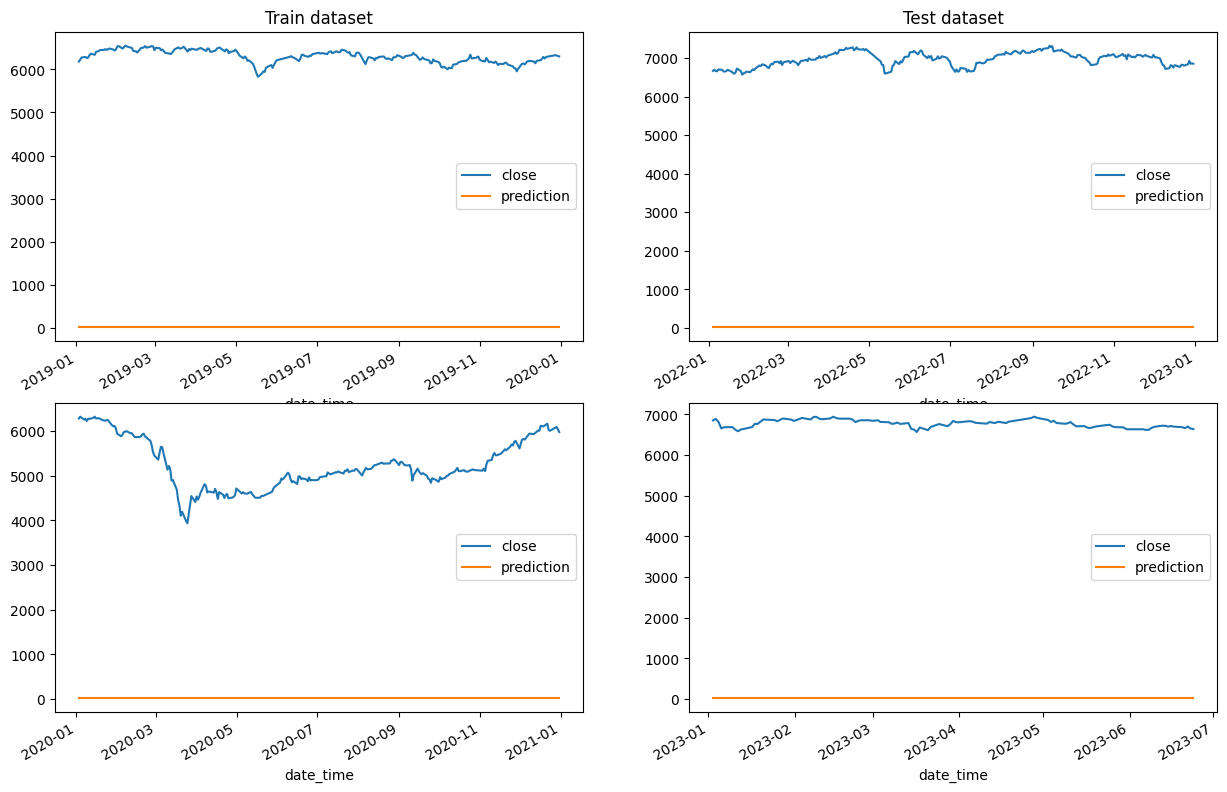

In [60]:
plot_forecast(rnn_1, x_train, y_train, x_test, y_test)

In [61]:
train_score = rnn_1.evaluate(x_train, y_train, verbose=0)
print('Train Score: %.2f MAE' % (train_score))
test_score = rnn_1.evaluate(x_test, y_test, verbose=0)
print('Test Score: %.2f MAE' % (test_score))

Train Score: 2244.90 MAE
Test Score: 6610.88 MAE


<h3 style="text-align:center">LSTM Models</h3>

<p>LSTM models are considered to be better than RNN in capturing time series data. So, I do not train any model on 1-day observations and begin by training my first LSTM model on 3-day time series.</p>

In [62]:
lookback = 3
x_train, y_train, x_test, y_test = train_test_split(lookback, clean_data)
x_train, x_test = scale_train_test(x_train, x_test)
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], 1)

In [63]:
lstm_72 = Sequential()
lstm_72.add(LSTM(24, input_shape = (lookback * 24, 1)))
lstm_72.add(Dense(1))
lstm_72.summary()

C:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 24)                  │           2,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 1)                   │              25 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,521 (9.85 KB)

 Trainable params: 2,521 (9.85 KB)

 Non-trainable params: 0 (0.00 B)

In [64]:
lstm_72.compile(loss = 'mean_absolute_error', optimizer = 'rmsprop')
#the model was trained during 1200 epochs in total
history_lstm_72 = lstm_72.fit(x_train, y_train, epochs = 100, verbose = 1, batch_size = 256, validation_split = 0.1)

Epoch 1/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 7s 119ms/step - loss: 1887.7051 - val_loss: 5858.3027
Epoch 2/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 89ms/step - loss: 1869.9268 - val_loss: 5855.6655
Epoch 3/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 94ms/step - loss: 1877.6592 - val_loss: 5854.1401
Epoch 4/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 84ms/step - loss: 1876.5894 - val_loss: 5852.8892
Epoch 5/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 91ms/step - loss: 1843.3243 - val_loss: 5851.8398
Epoch 6/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 86ms/step - loss: 1862.3024 - val_loss: 5850.9292
Epoch 7/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 1850.5367 - val_loss: 5850.1089
Epoch 8/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 92ms/step - loss: 1829.6124 - val_loss: 5849.3438
Epoch 9/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step - loss: 1844.3945 - val_loss: 5848.6133
Epoch 10/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 81ms/step - loss: 1861.9031 - val_loss: 5847.9043
Epoch 11/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 104ms/step - loss: 1877.7181 - val_

27/27 [==============================] - 3s 103ms/step - loss: 1652.5912 - val_loss: 5658.9683
Epoch 304/500
27/27 [==============================] - 2s 86ms/step - loss: 1651.9165 - val_loss: 5658.2930
Epoch 305/500
27/27 [==============================] - 2s 86ms/step - loss: 1651.2422 - val_loss: 5657.6187
Epoch 306/500
27/27 [==============================] - 3s 96ms/step - loss: 1650.5680 - val_loss: 5656.9434
Epoch 307/500
27/27 [==============================] - 2s 90ms/step - loss: 1649.8938 - val_loss: 5656.2681
Epoch 308/500
27/27 [==============================] - 2s 91ms/step - loss: 1649.2206 - val_loss: 5655.5938
Epoch 309/500
27/27 [==============================] - 2s 93ms/step - loss: 1648.5472 - val_loss: 5654.9189
Epoch 310/500
27/27 [==============================] - 3s 104ms/step - loss: 1647.8740 - val_loss: 5654.2441
Epoch 311/500
27/27 [==============================] - 3s 93ms/step - loss: 1647.2013 - val_loss: 5653.5688
Epoch 312/500
27/27 [===================

27/27 [==============================] - 3s 121ms/step - loss: 1602.8372 - val_loss: 5608.3560
Epoch 379/500
27/27 [==============================] - 3s 99ms/step - loss: 1602.1846 - val_loss: 5607.6797
Epoch 380/500
27/27 [==============================] - 3s 98ms/step - loss: 1601.5355 - val_loss: 5607.0088
Epoch 381/500
27/27 [==============================] - 3s 95ms/step - loss: 1600.8884 - val_loss: 5606.3364
Epoch 382/500
27/27 [==============================] - 3s 97ms/step - loss: 1600.2444 - val_loss: 5605.6602
Epoch 383/500
27/27 [==============================] - 3s 96ms/step - loss: 1599.5996 - val_loss: 5604.9824
Epoch 384/500
27/27 [==============================] - 2s 91ms/step - loss: 1598.9565 - val_loss: 5604.3091
Epoch 385/500
27/27 [==============================] - 2s 87ms/step - loss: 1598.3158 - val_loss: 5603.6343
Epoch 386/500
27/27 [==============================] - 3s 101ms/step - loss: 1597.6758 - val_loss: 5602.9629
Epoch 387/500
27/27 [===================

27/27 [==============================] - 3s 93ms/step - loss: 1556.7336 - val_loss: 5557.7871
Epoch 454/500
27/27 [==============================] - 2s 88ms/step - loss: 1556.1527 - val_loss: 5557.1084
Epoch 455/500
27/27 [==============================] - 2s 89ms/step - loss: 1555.5723 - val_loss: 5556.4331
Epoch 456/500
27/27 [==============================] - 2s 88ms/step - loss: 1554.9926 - val_loss: 5555.7651
Epoch 457/500
27/27 [==============================] - 2s 85ms/step - loss: 1554.4154 - val_loss: 5555.0889
Epoch 458/500
27/27 [==============================] - 2s 84ms/step - loss: 1553.8350 - val_loss: 5554.4136
Epoch 459/500
27/27 [==============================] - 2s 83ms/step - loss: 1553.2554 - val_loss: 5553.7407
Epoch 460/500
27/27 [==============================] - 2s 82ms/step - loss: 1552.6791 - val_loss: 5553.0645
Epoch 461/500
27/27 [==============================] - 2s 87ms/step - loss: 1552.1022 - val_loss: 5552.3916
Epoch 462/500
27/27 [=====================

27/27 [==============================] - 2s 91ms/step - loss: 1514.0767 - val_loss: 5506.5698
Epoch 30/500
27/27 [==============================] - 3s 95ms/step - loss: 1513.5419 - val_loss: 5505.8906
Epoch 31/500
27/27 [==============================] - 3s 103ms/step - loss: 1513.0077 - val_loss: 5505.2202
Epoch 32/500
27/27 [==============================] - 3s 108ms/step - loss: 1512.4786 - val_loss: 5504.5488
Epoch 33/500
27/27 [==============================] - 3s 125ms/step - loss: 1511.9478 - val_loss: 5503.8755
Epoch 34/500
27/27 [==============================] - 3s 93ms/step - loss: 1511.4188 - val_loss: 5503.1963
Epoch 35/500
27/27 [==============================] - 3s 111ms/step - loss: 1510.8879 - val_loss: 5502.5254
Epoch 36/500
27/27 [==============================] - 3s 96ms/step - loss: 1510.3634 - val_loss: 5501.8477
Epoch 37/500
27/27 [==============================] - 2s 88ms/step - loss: 1509.8409 - val_loss: 5501.1831
Epoch 38/500
27/27 [==========================

27/27 [==============================] - 3s 112ms/step - loss: 1478.4495 - val_loss: 5455.4854
Epoch 106/500
27/27 [==============================] - 3s 102ms/step - loss: 1478.0513 - val_loss: 5454.8120
Epoch 107/500
27/27 [==============================] - 3s 97ms/step - loss: 1477.6544 - val_loss: 5454.1577
Epoch 108/500
27/27 [==============================] - 3s 98ms/step - loss: 1477.2631 - val_loss: 5453.4775
Epoch 109/500
27/27 [==============================] - 2s 81ms/step - loss: 1476.8669 - val_loss: 5452.8091
Epoch 110/500
27/27 [==============================] - 3s 117ms/step - loss: 1476.4744 - val_loss: 5452.1494
Epoch 111/500
27/27 [==============================] - 3s 110ms/step - loss: 1476.0872 - val_loss: 5451.4946
Epoch 112/500
27/27 [==============================] - 3s 103ms/step - loss: 1475.7009 - val_loss: 5450.8018
Epoch 113/500
27/27 [==============================] - 3s 110ms/step - loss: 1475.3093 - val_loss: 5450.1333
Epoch 114/500
27/27 [===============

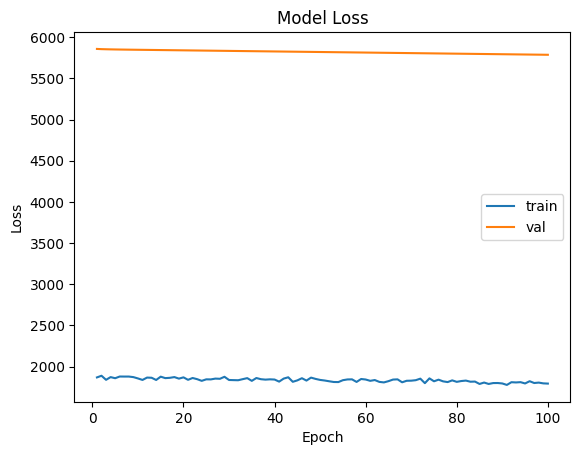

In [65]:
plot_loss(history_lstm_72)

In [66]:
lstm_72.save("models/lstm_72.h5")

232/232 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


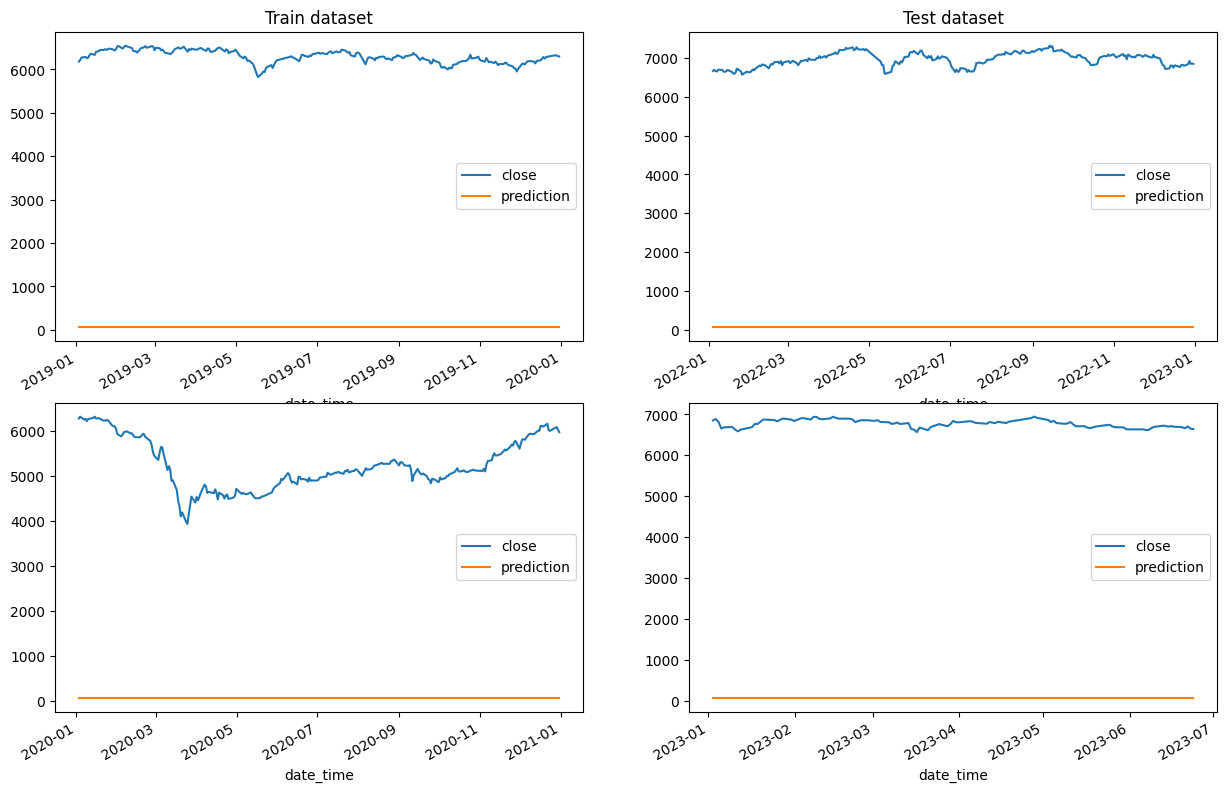

In [67]:
plot_forecast(lstm_72, x_train, y_train, x_test, y_test)

In [68]:
train_score = lstm_72.evaluate(x_train, y_train, verbose=0)
print('Train Score: %.2f MAE' % (train_score))
test_score = lstm_72.evaluate(x_test, y_test, verbose=0)
print('Train Score: %.2f MAE' % (test_score))

Train Score: 2207.94 MAE
Train Score: 6610.86 MAE


<h3 style="text-align:center">Models with Attention Mechanism</h3>

<p>Next, I implement Attention Mechanism (module <i>attention.py</i>) and train networks on 3-day and 7-day time series.</p>

In [69]:
lookback = 3
x_train, y_train, x_test, y_test = train_test_split(lookback, clean_data)
x_train, x_test = scale_train_test(x_train, x_test)
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], 1)

In [70]:
attention_72 = Sequential()
attention_72.add(LSTM(24, input_shape = (lookback * 24, 1), return_sequences = True))
attention_72.add(Attention())
attention_72.add(Dense(1))
attention_72.summary()

C:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                        │ (None, 72, 24)              │           2,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ attention (Attention)                │ (None, 24)                  │              96 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 1)                   │              25 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,617 (10.22 KB)

 Trainable params: 2,617 (10.22 KB)

 Non-trainable params: 0 (0.00 B)

In [78]:
attention_72.compile(loss = 'mean_absolute_error', optimizer = 'rmsprop')
#the model was trained during 1500 epochs in total
history_attention_72 = attention_72.fit(x_train, y_train, epochs = 50, verbose = 1, batch_size = 256, validation_split = 0.1)

Epoch 1/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 7s 114ms/step - loss: 1848.6556 - val_loss: 5851.4395
Epoch 2/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 104ms/step - loss: 1860.8574 - val_loss: 5850.6431
Epoch 3/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 101ms/step - loss: 1864.4844 - val_loss: 5849.8999
Epoch 4/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 90ms/step - loss: 1872.2614 - val_loss: 5849.1938
Epoch 5/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 90ms/step - loss: 1843.8696 - val_loss: 5848.5034
Epoch 6/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 91ms/step - loss: 1868.5148 - val_loss: 5847.8218
Epoch 7/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 91ms/step - loss: 1832.6555 - val_loss: 5847.1353
Epoch 8/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 91ms/step - loss: 1885.9407 - val_loss: 5846.4429
Epoch 9/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 92ms/step - loss: 1863.7531 - val_loss: 5845.7480
Epoch 10/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 1883.5758 - val_loss: 5845.0527
Epoch 11/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 99ms/step - loss: 1853.2825 - val_loss: 5844

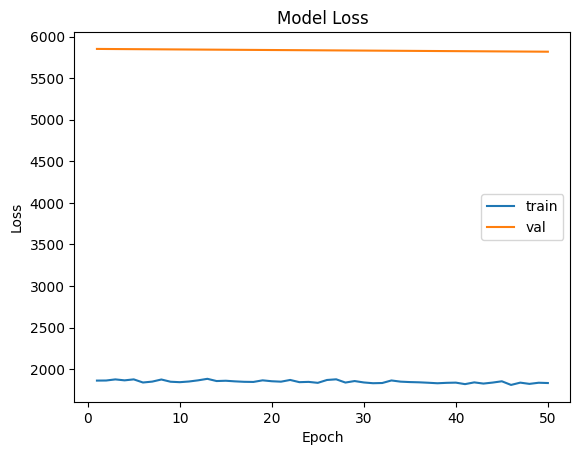

In [79]:
plot_loss(history_attention_72)

In [80]:
attention_72.save("models/attention_72.h5")

232/232 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step


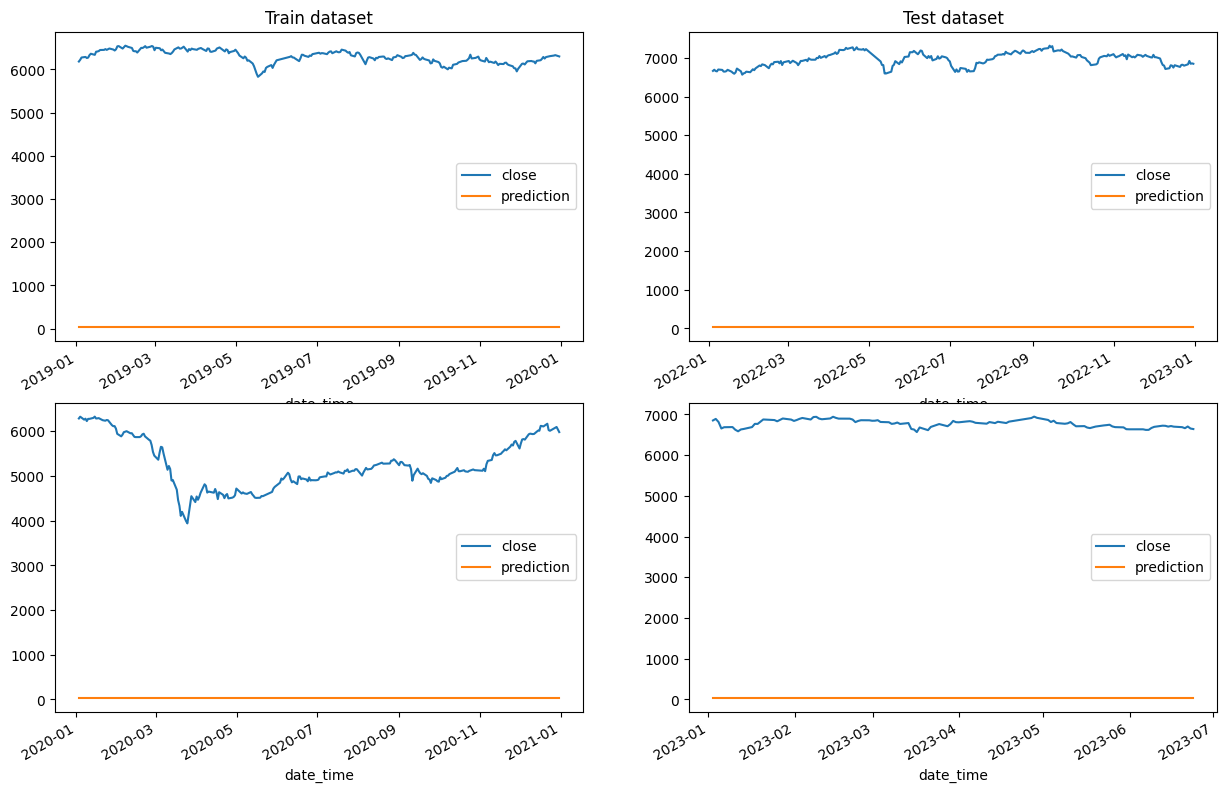

In [81]:
plot_forecast(attention_72, x_train, y_train, x_test, y_test)

In [82]:
train_score = attention_72.evaluate(x_train, y_train, verbose=0)
print('Train Score: %.2f MAE' % (train_score))
test_score = attention_72.evaluate(x_test, y_test, verbose=0)
print('Train Score: %.2f MAE' % (test_score))

Train Score: 2238.82 MAE
Train Score: 6641.76 MAE


<h4 style="text-align:center">China currency exchange rates dataset</h4>

<p>Finally, I train LSTM with Attention on China currency exchange rates. I use the same approach to compute the baseline predictions.</p>

In [83]:
def plot_forecast(model, rates_x_train, rates_y_train, rates_x_test, rates_y_test):
    """Plot the exchange rates model's forecast on the train and test datasets
    """
    if model == 'base':
        train_predict = pd.DataFrame(rates_x_train['lag_1'])
        test_predict = pd.DataFrame(rates_x_test['lag_1'])
    else:
        train_predict = pd.DataFrame(model.predict(rates_x_train))
        test_predict = pd.DataFrame(model.predict(rates_x_test))

    train_predict.columns = ['prediction']
    train_predict['date_time'] = rates_y_train.index.values
    train_predict.set_index('date_time', inplace = True)
    train_plot = pd.concat([rates_y_train, train_predict], axis = 1)

    test_predict.columns = ['prediction']
    test_predict['date_time'] = rates_y_test.index.values
    test_predict.set_index('date_time', inplace = True)
    test_plot = pd.concat([rates_y_test, test_predict], axis = 1)

    fig, axs = plt.subplots(1, 2, figsize = (15, 5))
    axs[0].plot(range(len(train_plot['Jan-2016':'Sep-2016'])), train_plot['Jan-2016':'Sep-2016'])
    axs[1].plot(range(len(test_plot['Jan-2017':'Sep-2017'])), test_plot['Jan-2017':'Sep-2017'])
    axs[0].title.set_text('Train dataset')
    axs[1].title.set_text('Test dataset')
    plt.show()

In [84]:
rates_input_data = pd.read_csv("input/usd_to_china.csv")
rates_clean_data = rates_input_data[rates_input_data['rate'] != 'ND']
rates_clean_data = rates_clean_data.assign(date_time = pd.to_datetime(rates_clean_data['data']))
rates_clean_data.set_index('date_time', inplace = True)
rates_clean_data = pd.DataFrame(rates_clean_data['rate'].astype(float))
rates_clean_data.columns = ['rate']
rates_clean_data.head()

rate
date_time         
1981-01-02  1.5341
1981-01-05  1.5418
1981-01-06  1.5264
1981-01-07  1.5264
1981-01-08  1.5264

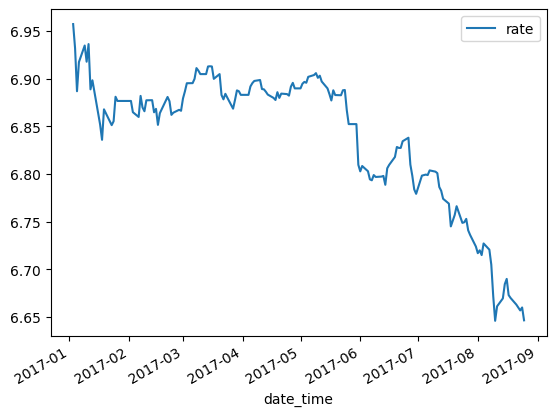

In [85]:
rates_clean_data.loc['2017'].plot(y = 'rate')
plt.show()

In [86]:
lookback = 72
rates_y_train = rates_clean_data[:'2017']['rate']
rates_y_test = rates_clean_data.loc['2017']['rate']
column_names = ['lag_1']
rates_x_train = rates_y_train.shift()
rates_x_test = rates_y_test.shift()
for i in range(2, lookback + 1):
    rates_x_train = pd.concat([rates_x_train, rates_y_train.shift(i)], axis = 1)
    rates_x_test = pd.concat([rates_x_test, rates_y_test.shift(i)], axis = 1)
    column_names.append('lag_' + str(i))
rates_x_train = rates_x_train[lookback:]
rates_x_test = rates_x_test[lookback:]
rates_y_train = rates_y_train[lookback:]
rates_y_test = rates_y_test[lookback:]
rates_x_train.columns = column_names
rates_x_test.columns = column_names

Mean squared error of a naive predictor 6.191050908890603


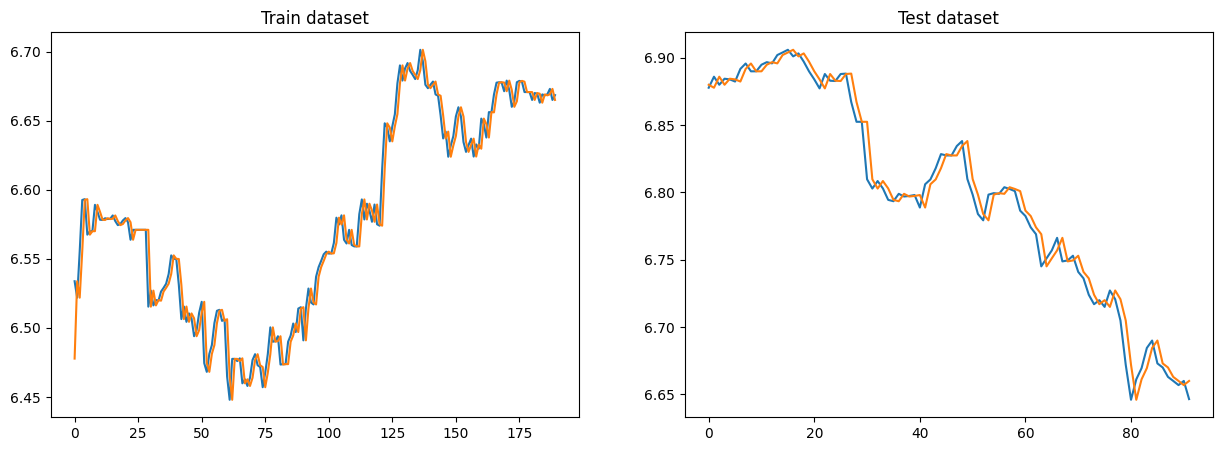

In [87]:
print("Mean squared error of a naive predictor", np.mean(rates_y_train))
plot_forecast('base', rates_x_train, rates_y_train, rates_x_test, rates_y_test)

In [88]:
rates_x_train, rates_x_test = scale_train_test(rates_x_train, rates_x_test)
rates_x_train = rates_x_train.reshape(rates_x_train.shape[0], rates_x_train.shape[1], 1)
rates_x_test = rates_x_test.reshape(rates_x_test.shape[0], rates_x_test.shape[1], 1)

rates_72 = Sequential()
rates_72.add(LSTM(24, input_shape = (lookback, 1), return_sequences = True))
rates_72.add(Attention())
rates_72.add(Dense(1))
rates_72.summary()

C:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                        │ (None, 72, 24)              │           2,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ attention_1 (Attention)              │ (None, 24)                  │              96 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 1)                   │              25 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,617 (10.22 KB)

 Trainable params: 2,617 (10.22 KB)

 Non-trainable params: 0 (0.00 B)

In [89]:
rates_72.compile(loss = 'mean_absolute_error', optimizer = 'rmsprop')
#the model was trained during 1000 epochs in total
rates_72.fit(rates_x_train, rates_y_train, epochs = 2, batch_size = 256, verbose = 1)

Epoch 1/2
36/36 ━━━━━━━━━━━━━━━━━━━━ 7s 84ms/step - loss: 5.7801
Epoch 2/2
36/36 ━━━━━━━━━━━━━━━━━━━━ 6s 101ms/step - loss: 3.0484


In [90]:
rates_72.save("models/rates_72.h5")

Train Score: 1.62 MAE
Train Score: 1.63 MAE
284/284 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


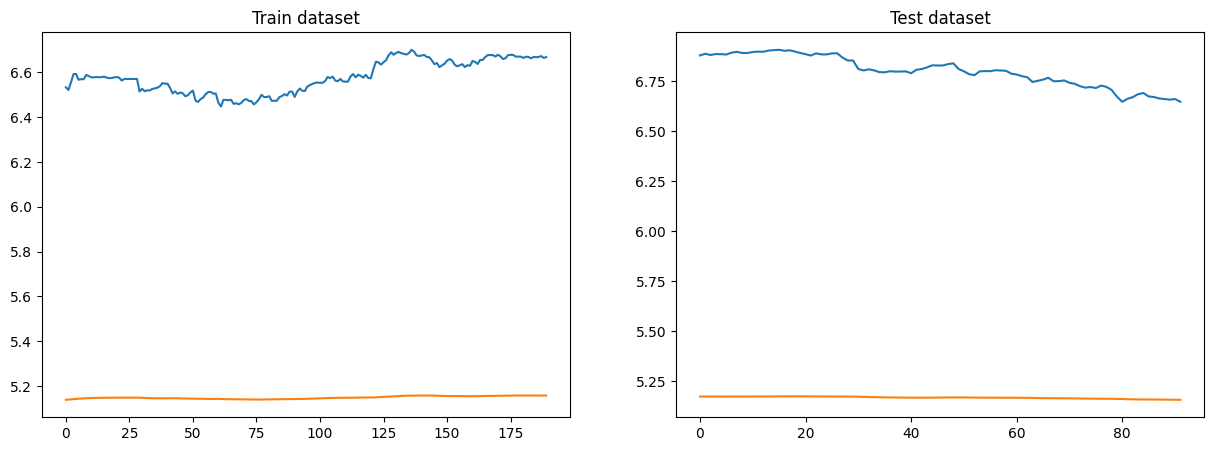

In [91]:
train_score = rates_72.evaluate(rates_x_train, rates_y_train, verbose=0)
print('Train Score: %.2f MAE' % (train_score))
test_score = rates_72.evaluate(rates_x_test, rates_y_test, verbose=0)
print('Train Score: %.2f MAE' % (test_score))
plot_forecast(rates_72, rates_x_train, rates_y_train, rates_x_test, rates_y_test)

<p>The model does not echo its input. However, the MSE became a bit higher in comparison to the baseline. In a literature, the authors report much higher accuracy then my exchange rates model. I attribute it to bigger networks and longer training time.</p> 

<h4 style="text-align:center">Smoothed Air Pollution Dataset/h4>

<p>Next, we check if the avaraging of observations can help learning process. We hypothesise air polution dataset contains a lot of missing values which impedes the learning.</p> 

In [92]:
day_data = clean_data.resample('D').mean().bfill()

lookback = 3
x_train, y_train, x_test, y_test = train_test_split(lookback, day_data)
base_mse = base_line_mse(x_train, y_train)
print("Mean squared error of a naive predictor", base_mse)

x_train, x_test = scale_train_test(x_train, x_test)
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], 1)

day_lstm_72 = Sequential()
day_lstm_72.add(LSTM(24, input_shape = (lookback * 24, 1)))
day_lstm_72.add(Dense(1))
day_lstm_72.summary()

Mean squared error of a naive predictor 752.0852869963294


C:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                        │ (None, 24)                  │           2,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 1)                   │              25 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,521 (9.85 KB)

 Trainable params: 2,521 (9.85 KB)

 Non-trainable params: 0 (0.00 B)

In [93]:
day_lstm_72.compile(loss = 'mean_absolute_error', optimizer = 'rmsprop')
#the model was trained during 20000 epochs in total
history_lstm_72 = day_lstm_72.fit(x_train, y_train, epochs = 50, verbose = 1, batch_size = 128, validation_split = 0.1)

Epoch 1/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 8s 61ms/step - loss: 1874.5692 - val_loss: 5861.7832
Epoch 2/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 5s 57ms/step - loss: 1864.9563 - val_loss: 5858.2505
Epoch 3/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 5s 57ms/step - loss: 1857.9752 - val_loss: 5855.8174
Epoch 4/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 5s 59ms/step - loss: 1857.2949 - val_loss: 5853.7295
Epoch 5/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 5s 56ms/step - loss: 1861.5907 - val_loss: 5851.7285
Epoch 6/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 5s 56ms/step - loss: 1873.3199 - val_loss: 5849.7476
Epoch 7/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 6s 65ms/step - loss: 1841.3342 - val_loss: 5847.7710
Epoch 8/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 5s 57ms/step - loss: 1842.1312 - val_loss: 5845.7954
Epoch 9/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 5s 58ms/step - loss: 1837.6622 - val_loss: 5843.8208
Epoch 10/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 5s 59ms/step - loss: 1882.7292 - val_loss: 5841.8452
Epoch 11/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 5s 56ms/step - loss: 1852.5728 - val_loss: 5839.86

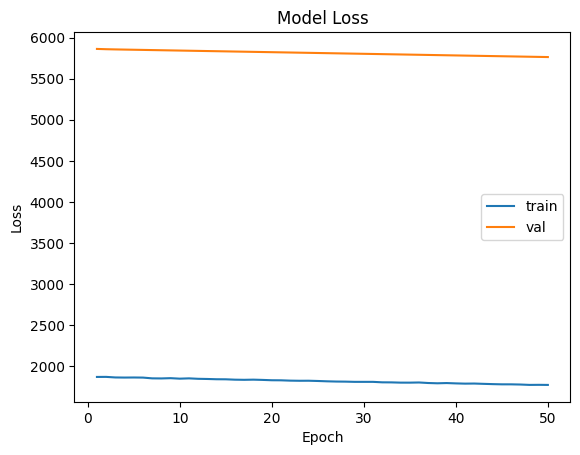

In [94]:
plot_loss(history_lstm_72)

In [95]:
day_lstm_72.save("models/history_lstm_72.h5")

Train Score: 2176.87 MAE
Test Score: 6554.46 MAE
349/349 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


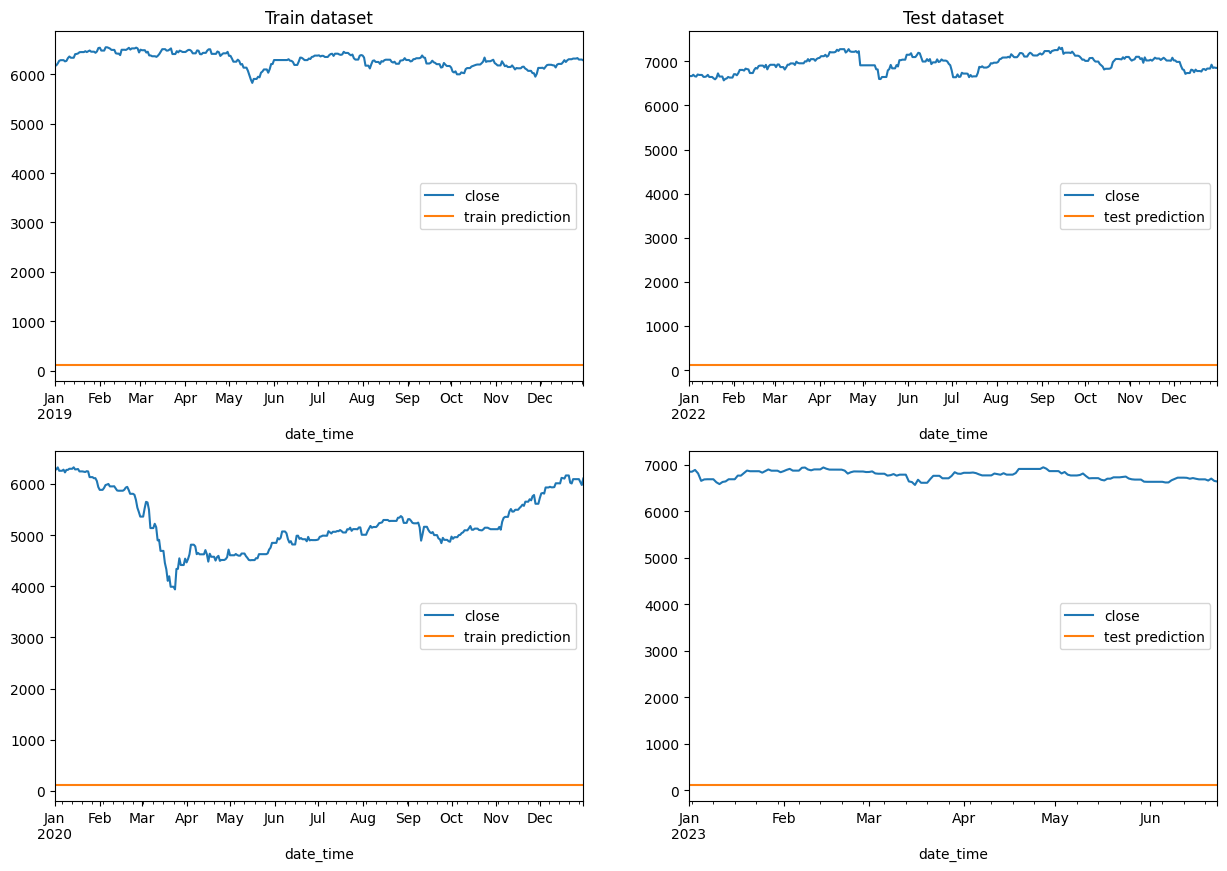

In [113]:
train_score = day_lstm_72.evaluate(x_train, y_train, verbose=0)
print('Train Score: %.2f MAE' % train_score)

test_score = day_lstm_72.evaluate(x_test, y_test, verbose=0)
print('Test Score: %.2f MAE' % test_score)

train_predict = pd.DataFrame(day_lstm_72.predict(x_train))
test_predict = pd.DataFrame(day_lstm_72.predict(x_test))

train_predict.columns = ['train prediction']
test_predict.columns = ['test prediction']

train_predict['date_time'] = y_train.index.values
train_predict.set_index('date_time', inplace=True)

test_predict['date_time'] = y_test.index.values
test_predict.set_index('date_time', inplace=True)

train_plot = pd.concat([y_train, train_predict], axis=1)
test_plot = pd.concat([y_test, test_predict], axis=1)

fig, axs = plt.subplots(2, 2, figsize=(15, 10))

train_plot.loc['2019'].plot(ax=axs[0, 0])
test_plot.loc['2022'].plot(ax=axs[0, 1])
train_plot.loc['2020'].plot(ax=axs[1, 0])
test_plot.loc['2023'].plot(ax=axs[1, 1])

axs[0, 0].set_title('Train dataset')
axs[0, 1].set_title('Test dataset')

plt.show()


In [114]:
day_attention_72 = Sequential()
day_attention_72.add(LSTM(24, input_shape = (lookback * 24, 1), return_sequences = True))
day_attention_72.add(Attention())
day_attention_72.add(Dense(1))
day_attention_72.summary()

C:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_5 (LSTM)                        │ (None, 72, 24)              │           2,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ attention_3 (Attention)              │ (None, 24)                  │              96 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 1)                   │              25 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,617 (10.22 KB)

 Trainable params: 2,617 (10.22 KB)

 Non-trainable params: 0 (0.00 B)

In [115]:
day_attention_72.compile(loss = 'mean_absolute_error', optimizer = 'rmsprop')
#the model was trained during 20000 epochs in total
day_attention_72.fit(x_train, y_train, epochs = 10, verbose = 1, batch_size = 128, validation_split = 0.1)

Epoch 1/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 10s 82ms/step - loss: 1914.5602 - val_loss: 5860.6138
Epoch 2/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 9s 70ms/step - loss: 1868.6003 - val_loss: 5857.4702
Epoch 3/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 13s 105ms/step - loss: 1869.9711 - val_loss: 5855.2207
Epoch 4/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 9s 80ms/step - loss: 1848.6945 - val_loss: 5853.2217
Epoch 5/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 9s 67ms/step - loss: 1865.8645 - val_loss: 5851.2944
Epoch 6/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 10s 66ms/step - loss: 1865.0850 - val_loss: 5849.3818
Epoch 7/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 11s 69ms/step - loss: 1867.6658 - val_loss: 5847.4775
Epoch 8/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 10s 70ms/step - loss: 1845.9696 - val_loss: 5845.5410
Epoch 9/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 11s 70ms/step - loss: 1883.1531 - val_loss: 5843.4741
Epoch 10/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 11s 75ms/step - loss: 1858.0458 - val_loss: 5841.4248


In [117]:
day_attention_72.save("models/history_attention_72.h5")

Train Score: 2255.46 MAE
Test Score: 6633.04 MAE
349/349 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


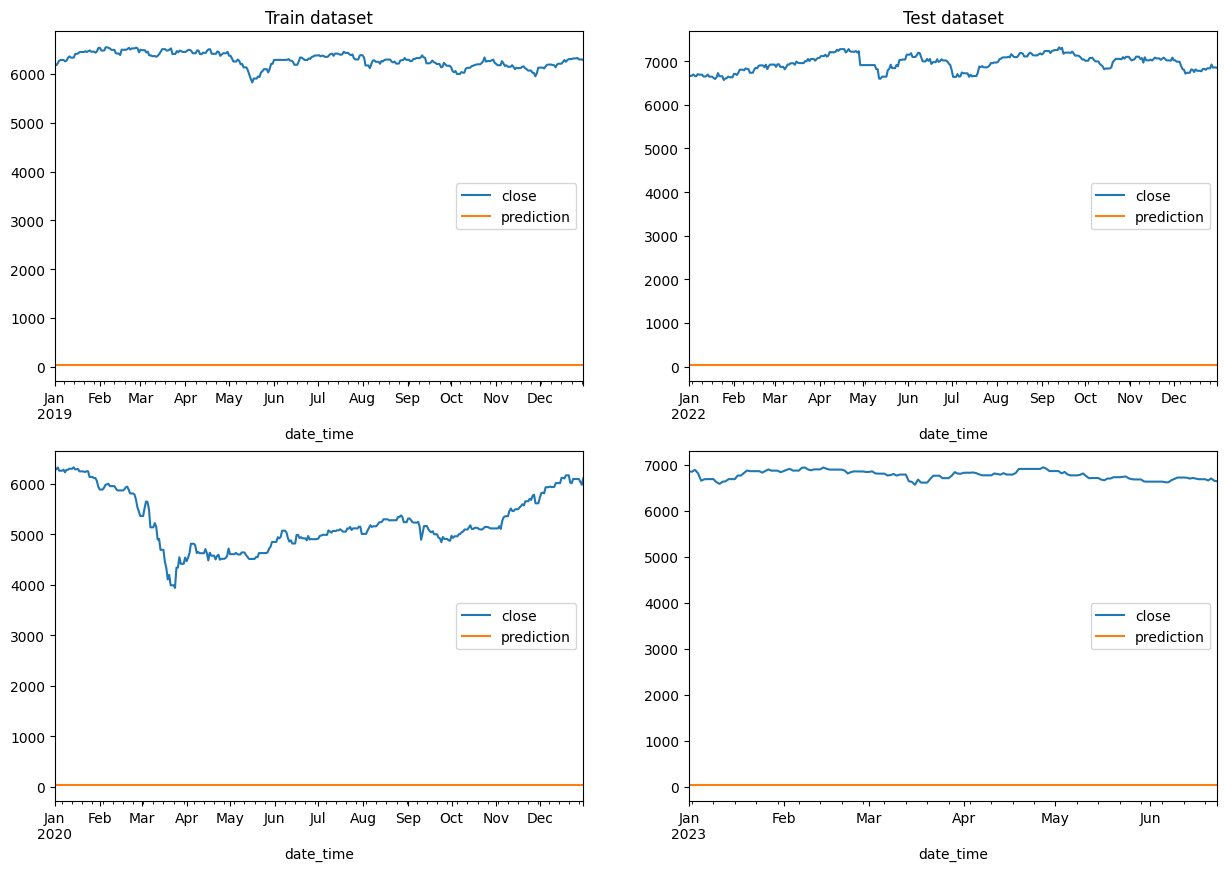

In [118]:
train_score = day_attention_72.evaluate(x_train, y_train, verbose=0)
print('Train Score: %.2f MAE' % train_score)

test_score = day_attention_72.evaluate(x_test, y_test, verbose=0)
print('Test Score: %.2f MAE' % test_score)

model = day_attention_72
train_predict = pd.DataFrame(model.predict(x_train))
test_predict = pd.DataFrame(model.predict(x_test))
train_predict.columns = ['prediction']
train_predict['date_time'] = y_train.index.values
train_predict.set_index('date_time', inplace=True)
train_plot = pd.concat([y_train, train_predict], axis=1)

test_predict.columns = ['prediction']
test_predict['date_time'] = y_test.index.values
test_predict.set_index('date_time', inplace=True)
test_plot = pd.concat([y_test, test_predict], axis=1)

fig, axs = plt.subplots(2, 2, figsize=(15, 10))
train_plot.loc['2019'].plot(ax=axs[0, 0])
test_plot.loc['2022'].plot(ax=axs[0, 1])
train_plot.loc['2020'].plot(ax=axs[1, 0])
test_plot.loc['2023'].plot(ax=axs[1, 1])

axs[0, 0].set_title('Train dataset')
axs[0, 1].set_title('Test dataset')

plt.show()


<p>Both models performed well and outperformed the baseline model with a significant margin.</p>

<p>To summarise, on the first data set when the output variable varied significantly it was easy to bit a baseline model. In fact, fully connected ANNs could outperform the baseline. Next, RNNs were more difficult to train but they were a bit more accurate than fully connected ANNs. LSTM models were more powerful than RNNs and easier to train. For example, I could train an LSTM with 7-day time series input which was not possible with an RNN. Finally, Attent Mechanism further improves LSTM models. The resulting networks were faster to train and produced good results.</p>

<p>In contrast, on China exchange rates dataset the model with Attention Mechanism did not show an improvement over the baseline model. I assume that for such a slowly changing time series more sophisticated models are required. Additionally, it is clear that predicting exchange rates are more difficult task than predicting air pollution.</p>